In [19]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import MonthLocator, DateFormatter

**Set Up:**
This part just sets up the dictionaries and data frames we are going to use

In [20]:




citiesL = ["Durban", "Richards Bay", "Cape Town", "Dar Es Salaam", 
           "Mombasa", "Maputo", "Beira", "Walvis Bay", "Douala", 
           "Tangier-Mediterranean", "Jorf Lasfar", "Alexandria", 
           "Port Said", "Lagos-Apapa-Tin Can Island", "Bonny", "Tema", 
           "Abidjan", "San Pedro", "Bissau", "Mogadishu", "Berbera", 
           "Djibouti", "Ningbo"]

city_to_pair = {
    # South Africa
    "Durban": "ZARUSD=X",
    "Richards Bay": "ZARUSD=X",
    "Cape Town": "ZARUSD=X",

    # Tanzania
    "Dar Es Salaam": "TZSUSD=X",

    # Kenya
    "Mombasa": "KESUSD=X",

    # Mozambique
    "Maputo": "MZNUSD=X",
    "Beira": "MZNUSD=X",

    # Namibia
    "Walvis Bay": "NADUSD=X",

    # Cameroon
    "Douala": "XAFUSD=X",       

    # Morocco
    "Tangier-Mediterranean": "MADUSD=X",
    "Jorf Lasfar": "MADUSD=X",

    # Egypt
    "Alexandria": "EGPUSD=X",
    "Port Said": "EGPUSD=X",

    # Nigeria
    "Lagos-Apapa-Tin Can Island": "NGNUSD=X",
    "Bonny": "NGNUSD=X",

    # Ghana
    "Tema": "GHSUSD=X",

    # Côte d’Ivoire
    "Abidjan": "XOFUSD=X",    

    # Côte d’Ivoire (San Pedro)
    "San Pedro": "XOFUSD=X",

    # Guinea-Bissau 
    "Bissau": "XOFUSD=X",

    # Somalia
    "Mogadishu": "SOSUSD=X",

    # Somaliland (Berbera) — may not be valid since this port uses somaliland shilling
    "Berbera": "SOSUSD=X",

    # Djibouti
    "Djibouti": "DJFUSD=X",


    # China
    "Ningbo": "CNYUSD=X",
}
cities = {}


durban = portData[portData.get('portname')=='Durban']
#durban.plot(kind='line', x='Date', y=')

#Take a look at any shocks of Nigerian ports around key oil changes 
# Dangote - 2023-2024 and check if anything vaused that
# Correlation between distance of two ports (Does distance play a role)

In [28]:
portData = pd.read_csv('portactivity.csv')
for c in citiesL:
    cities[c] = [portData[portData.get('portname')==c], city_to_pair[c]]

**Presenting Time Series data with shocks for different ports**

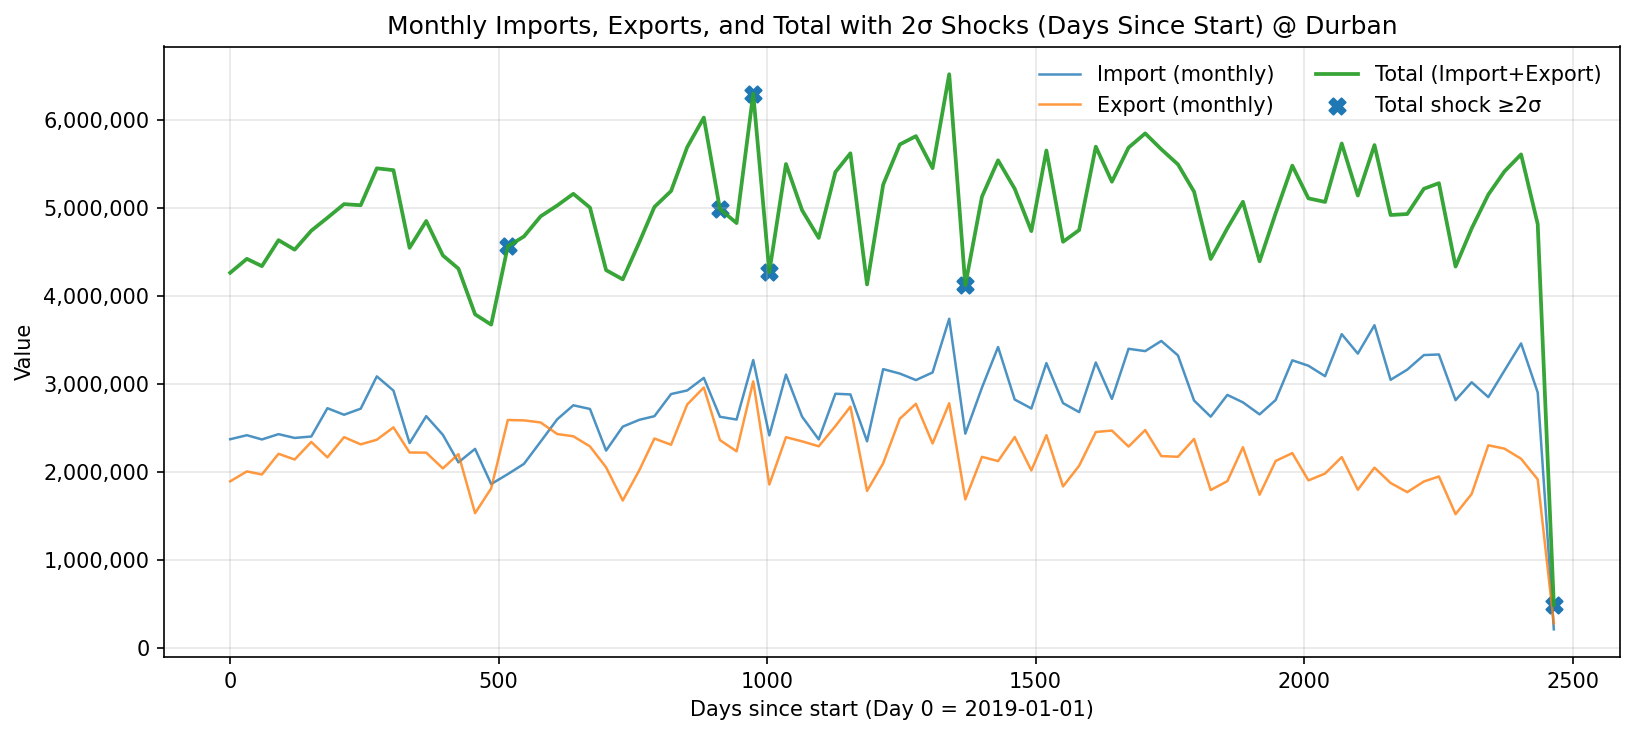

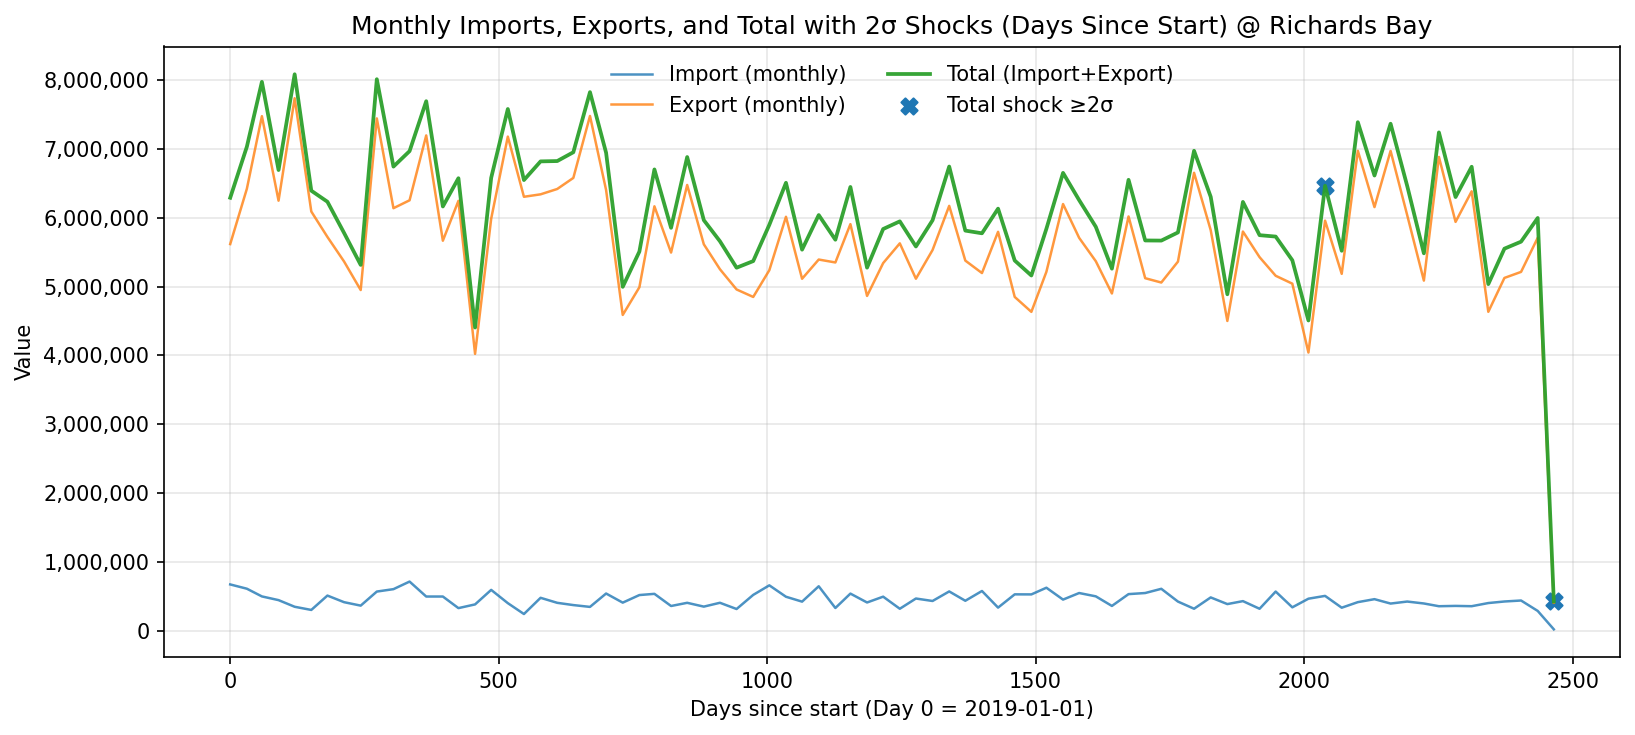

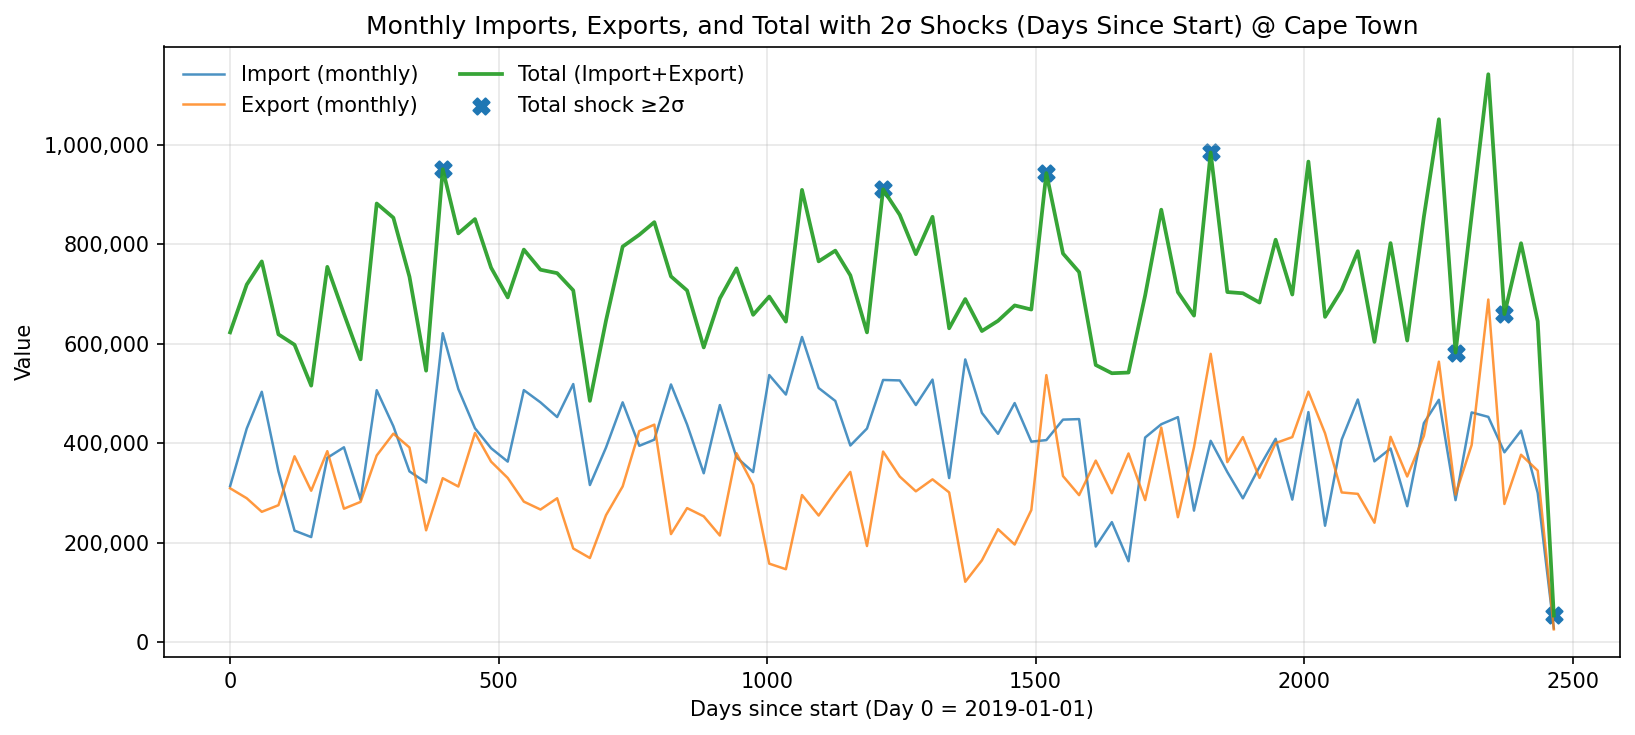

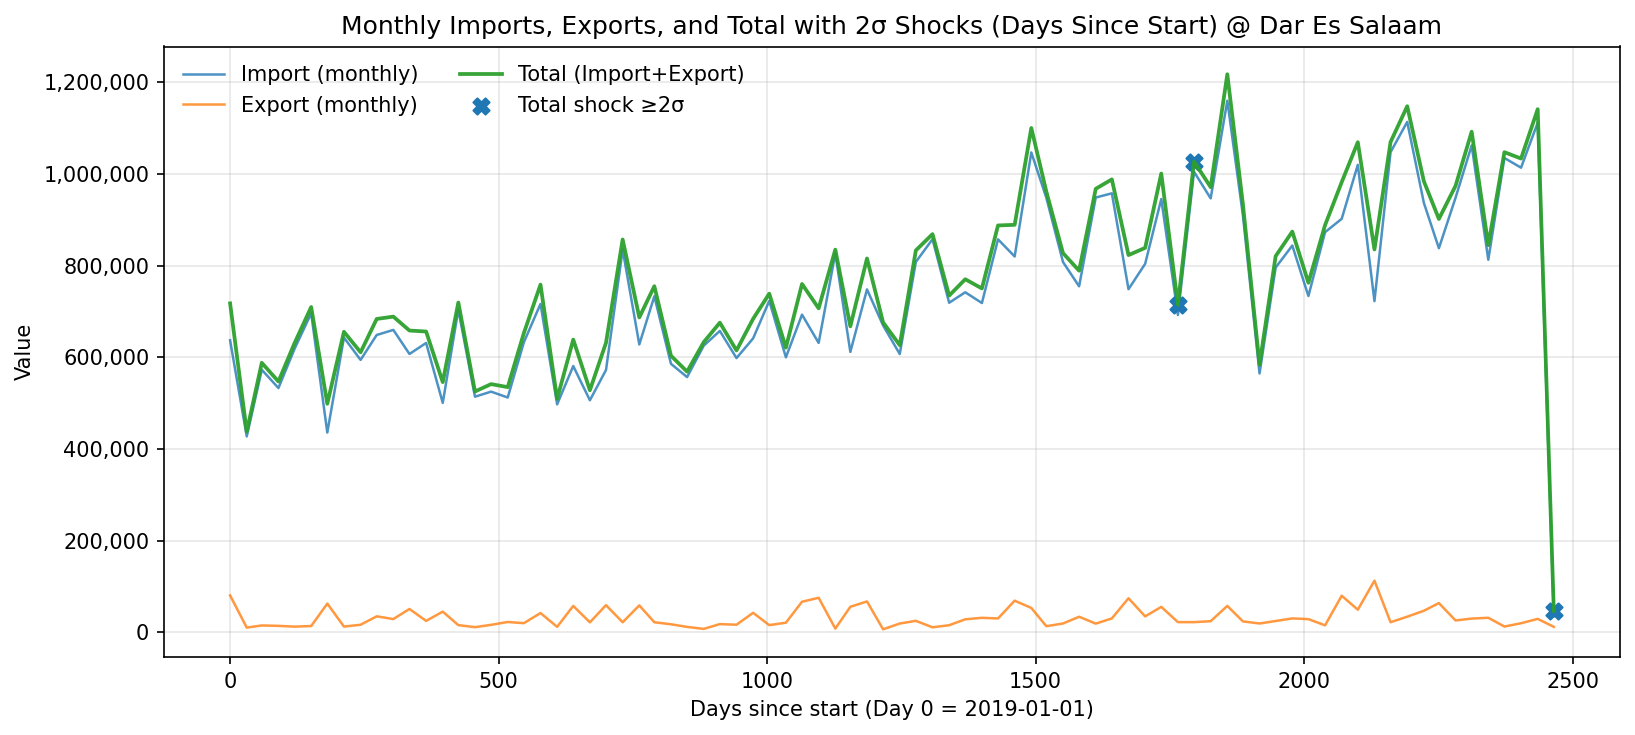

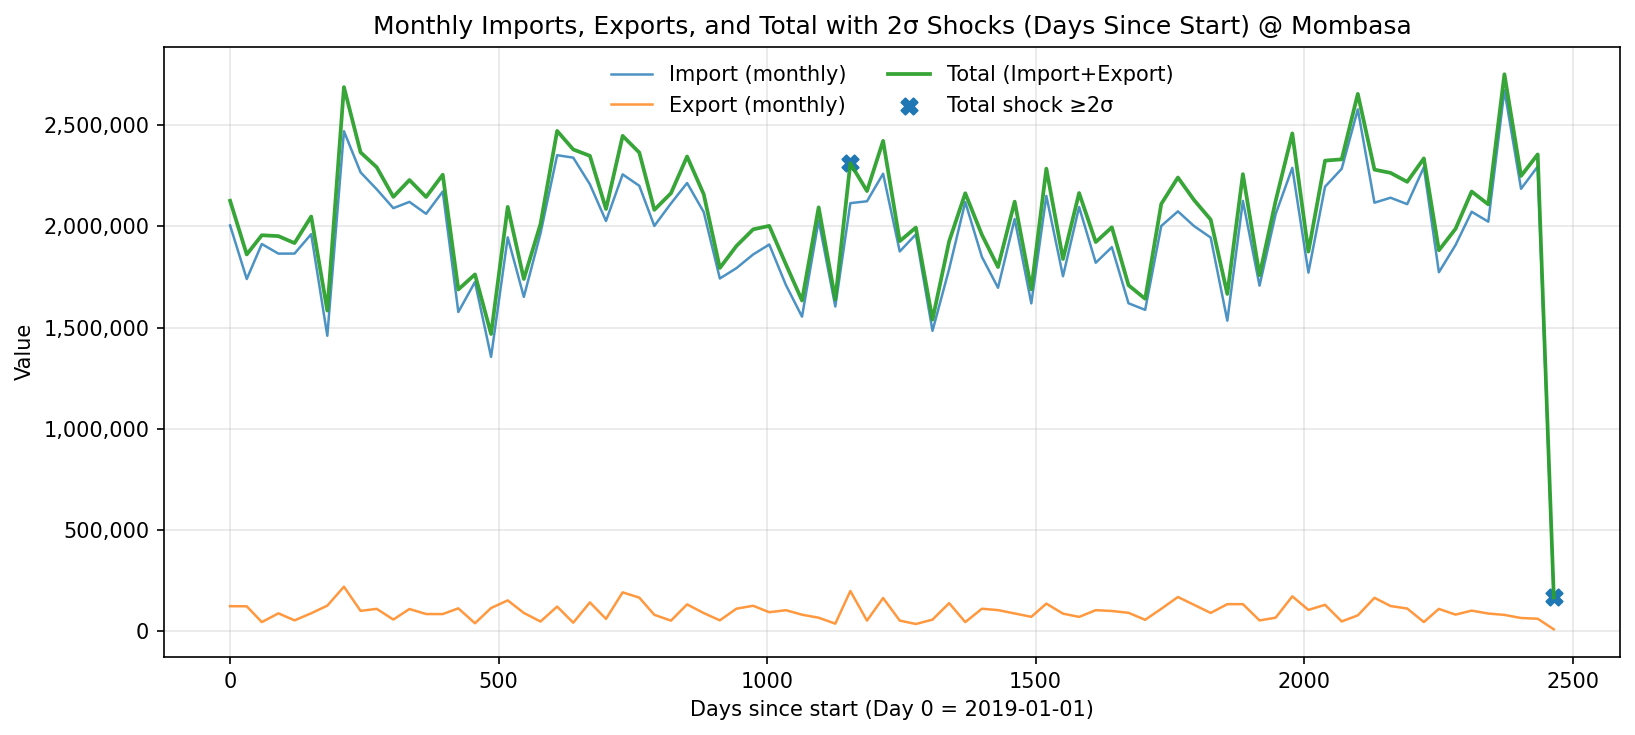

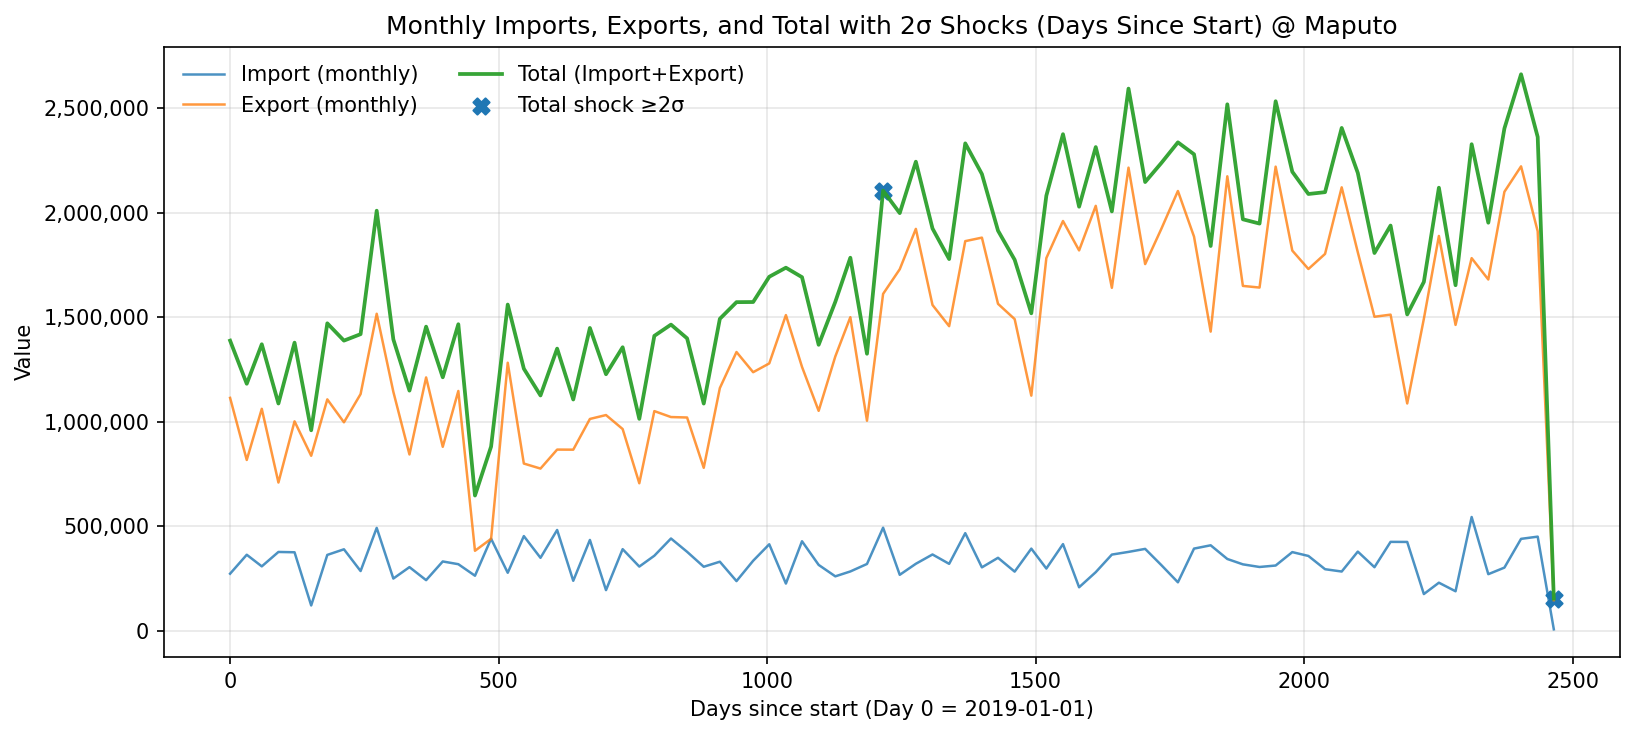

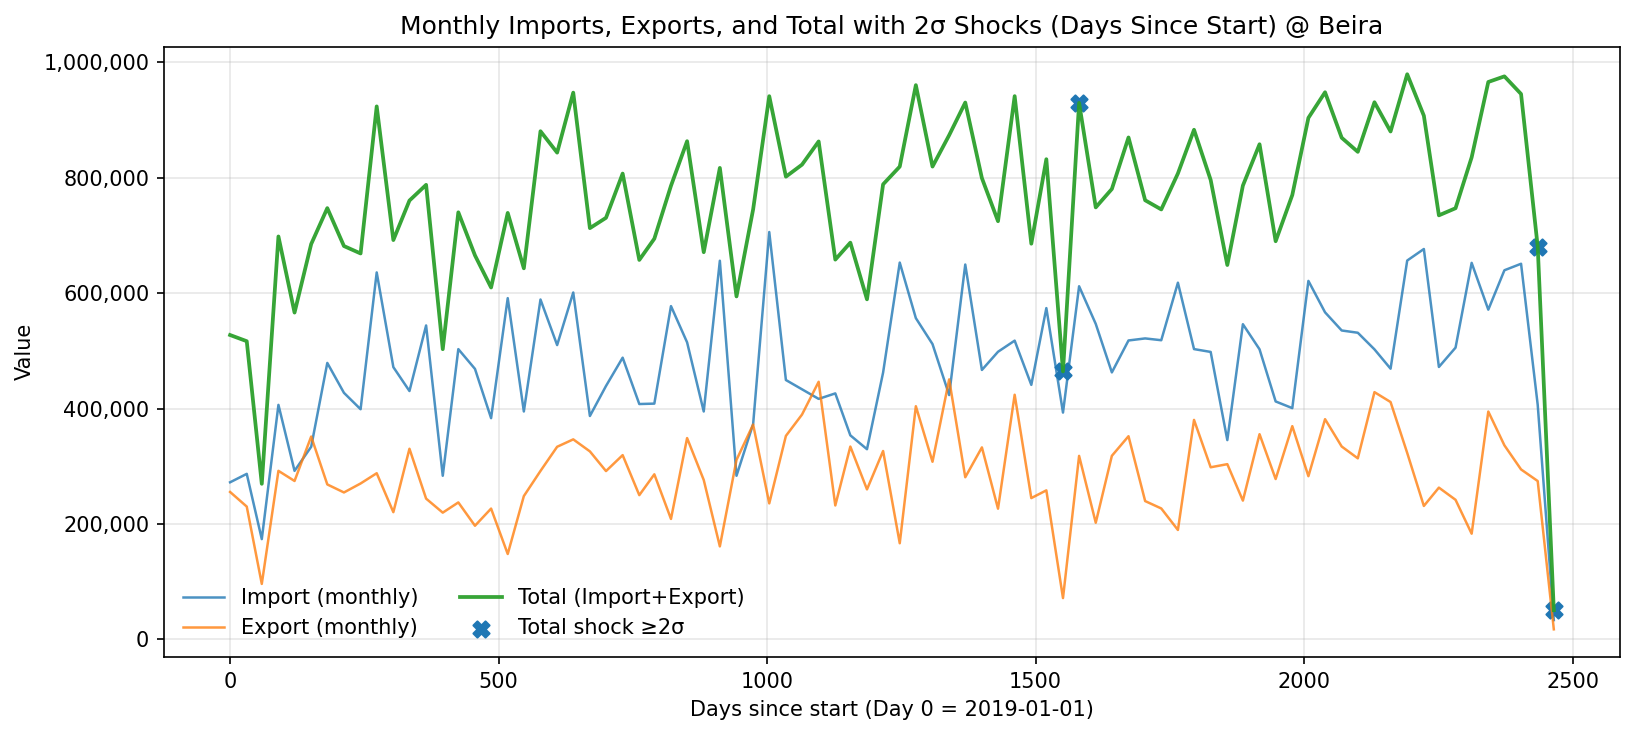

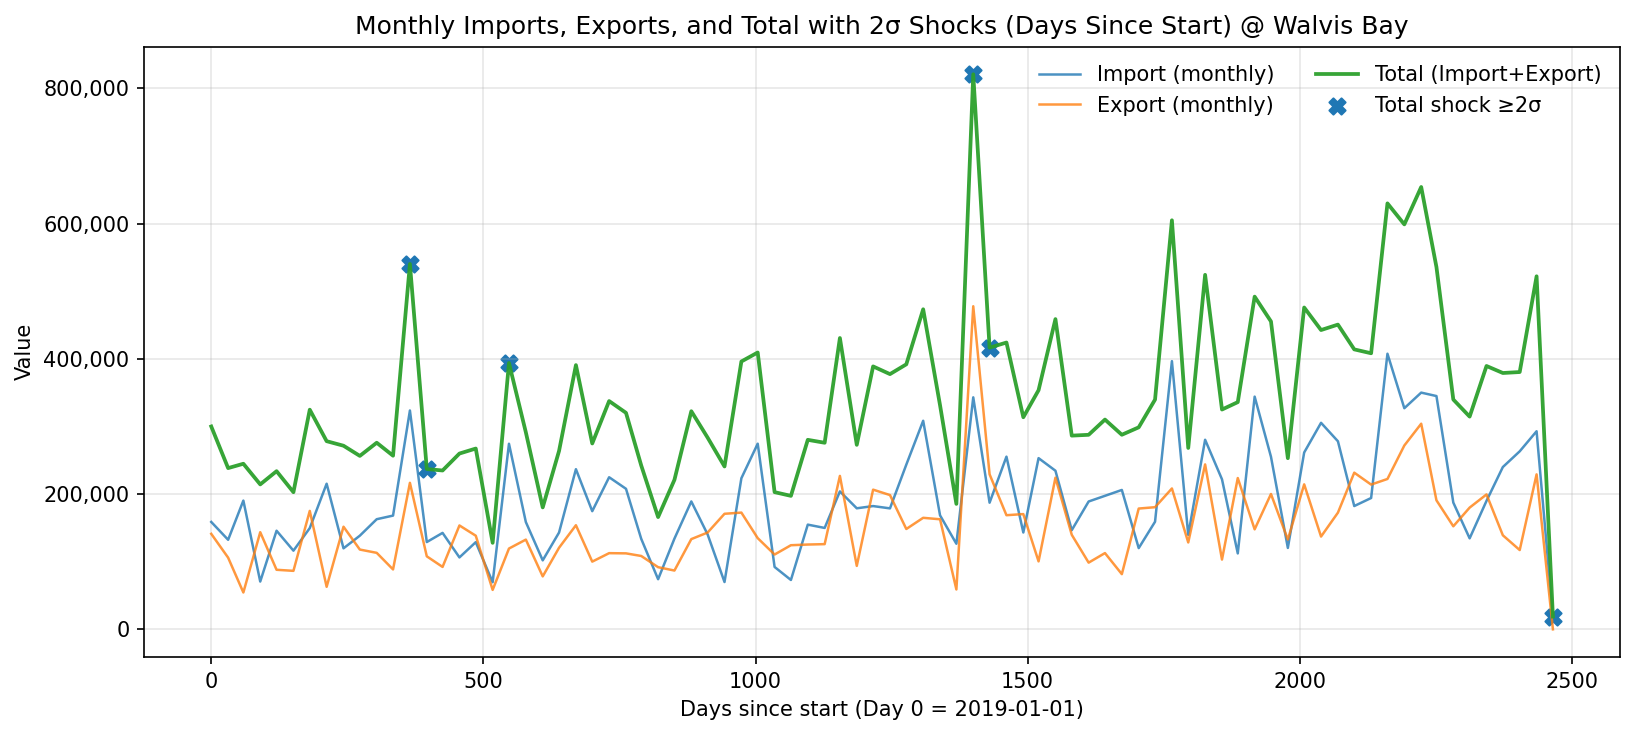

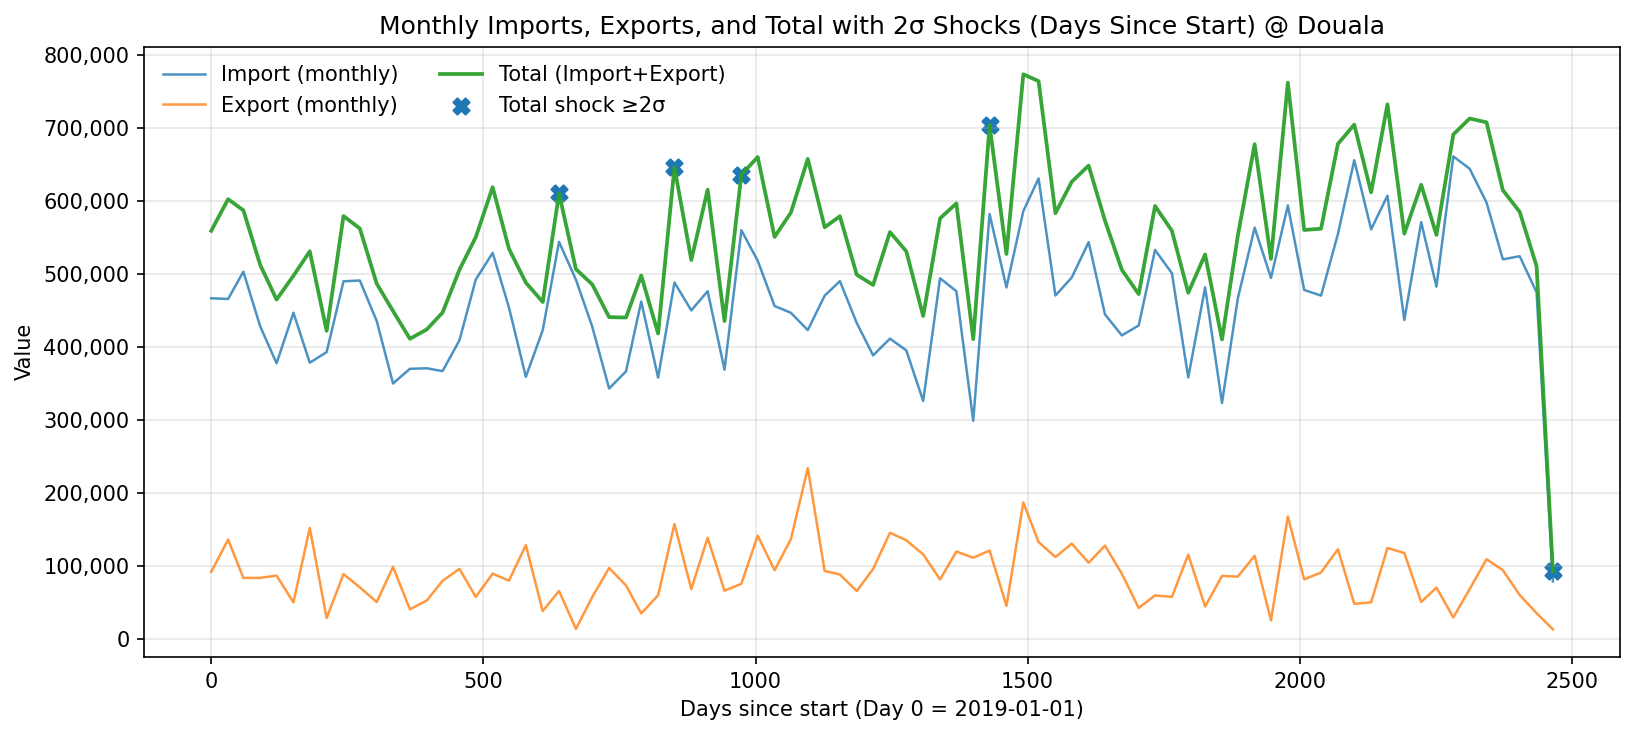

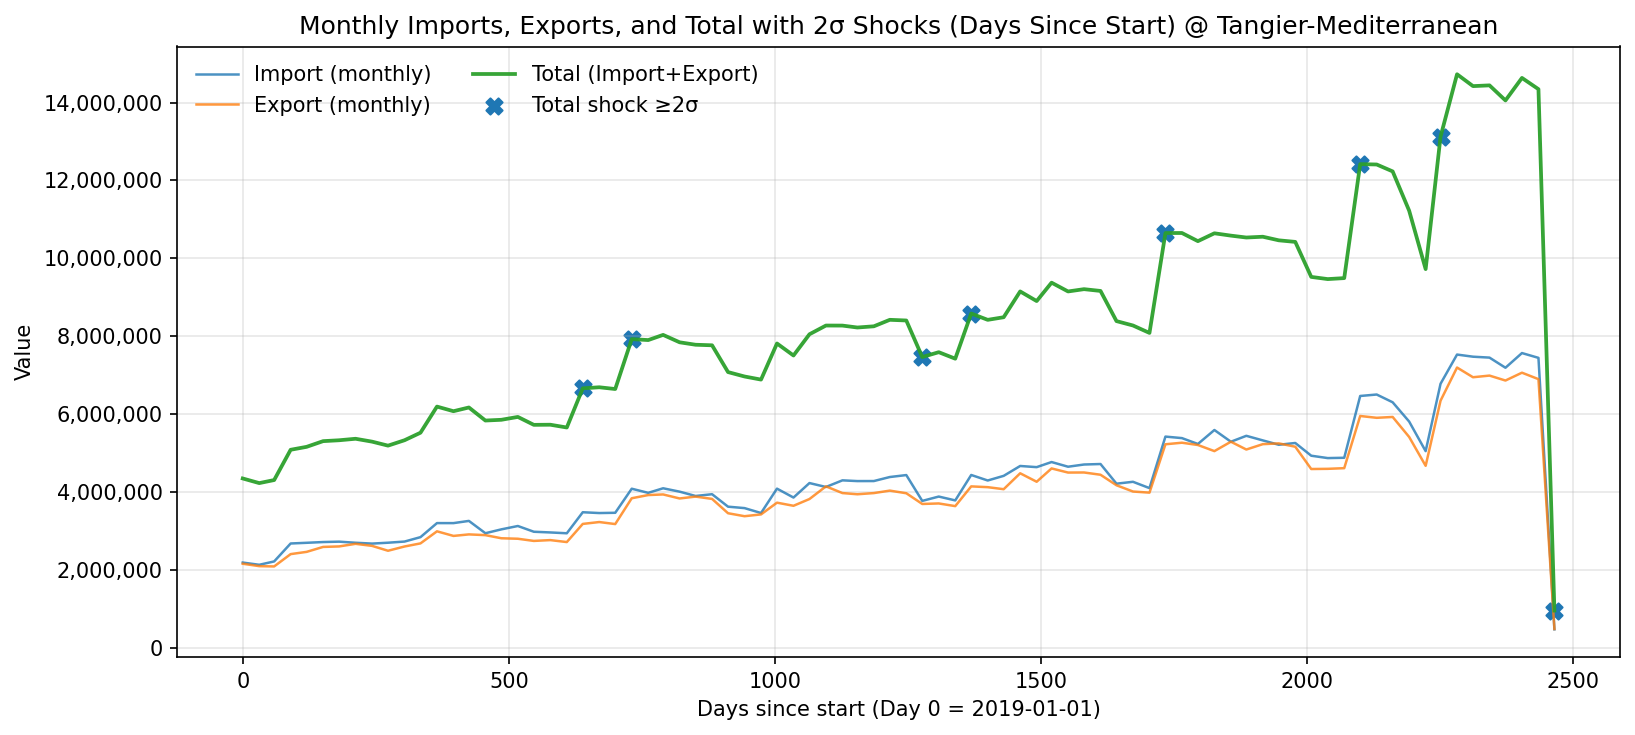

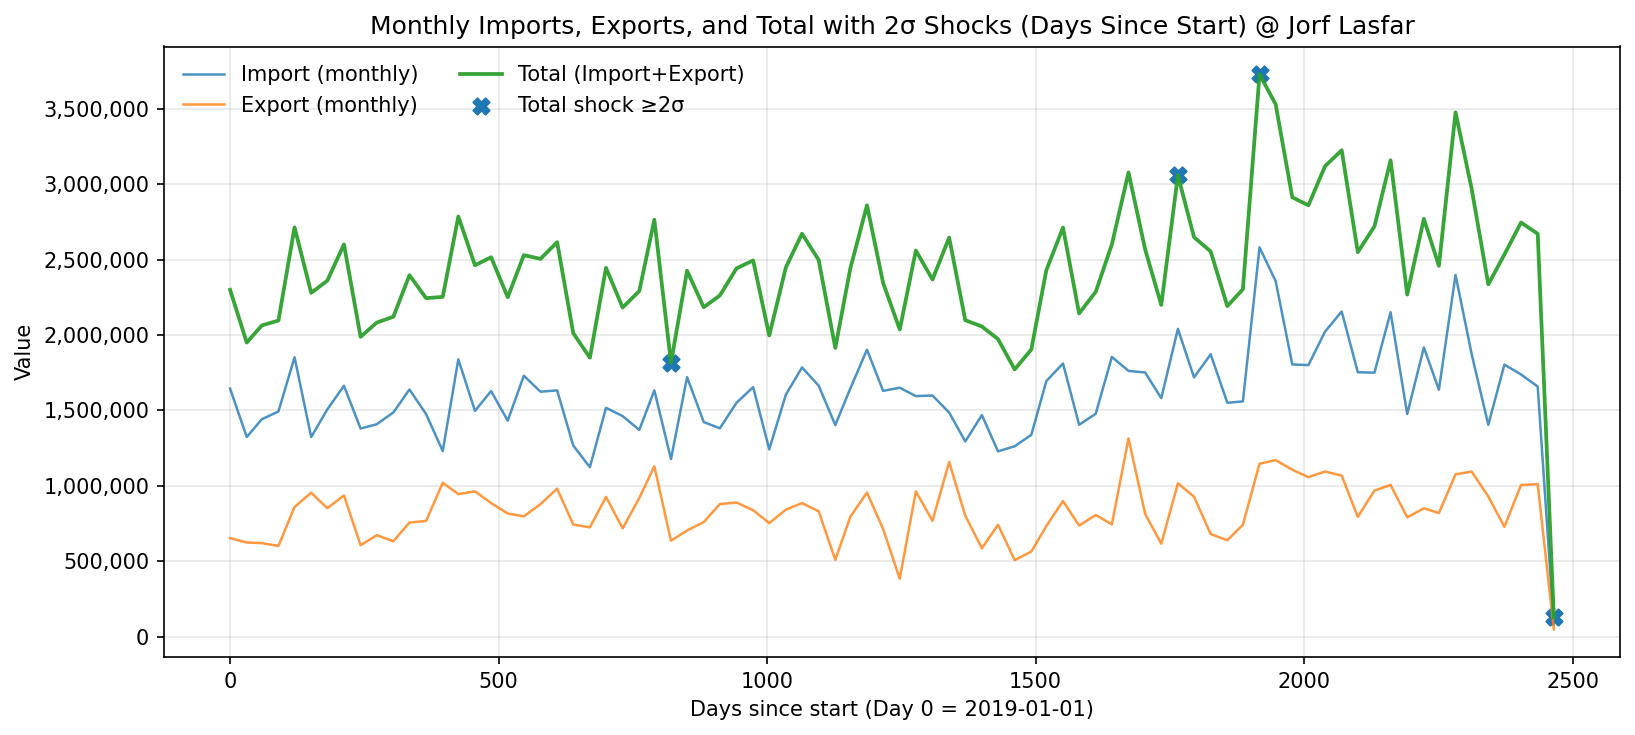

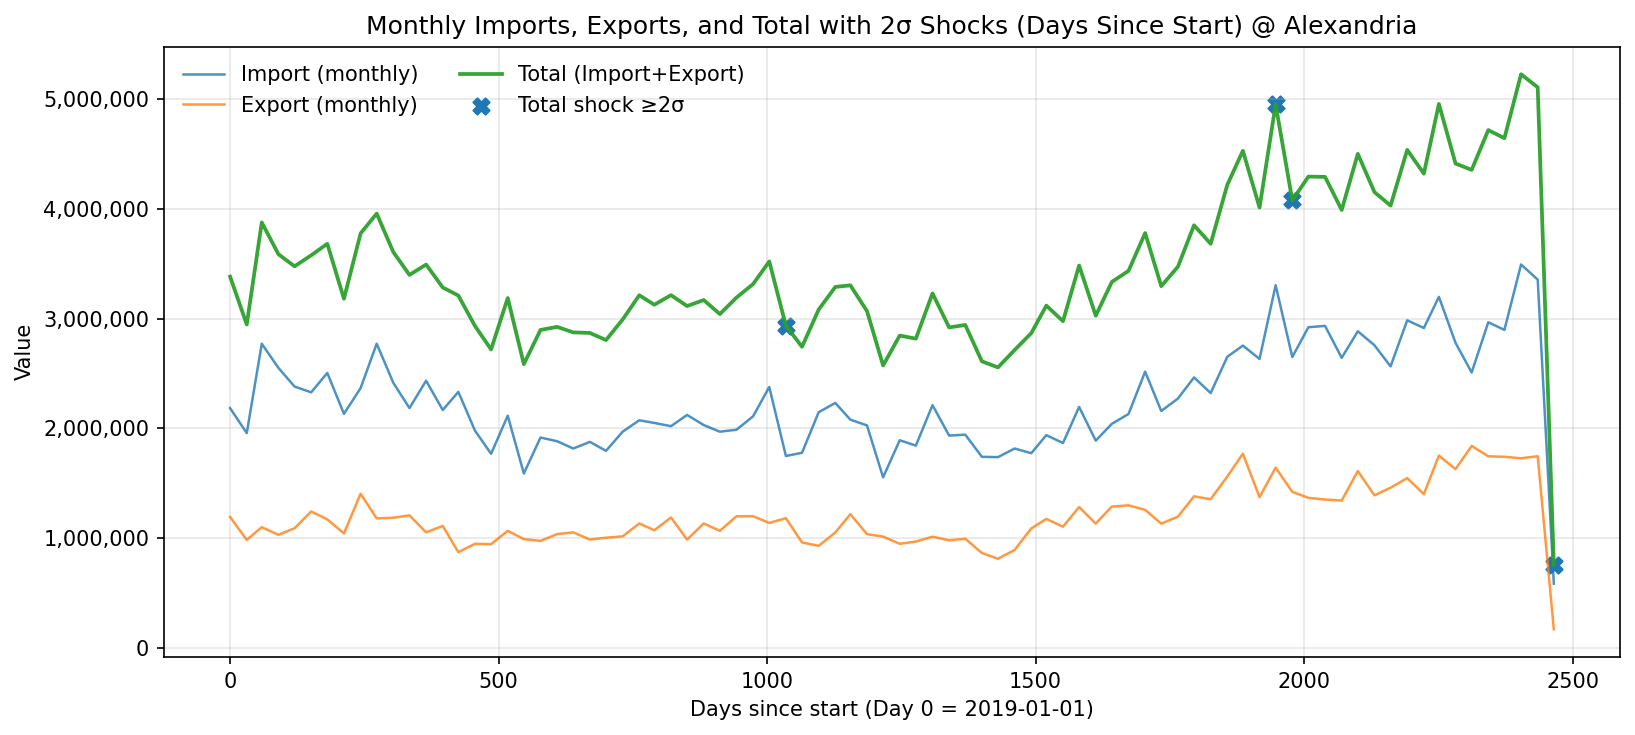

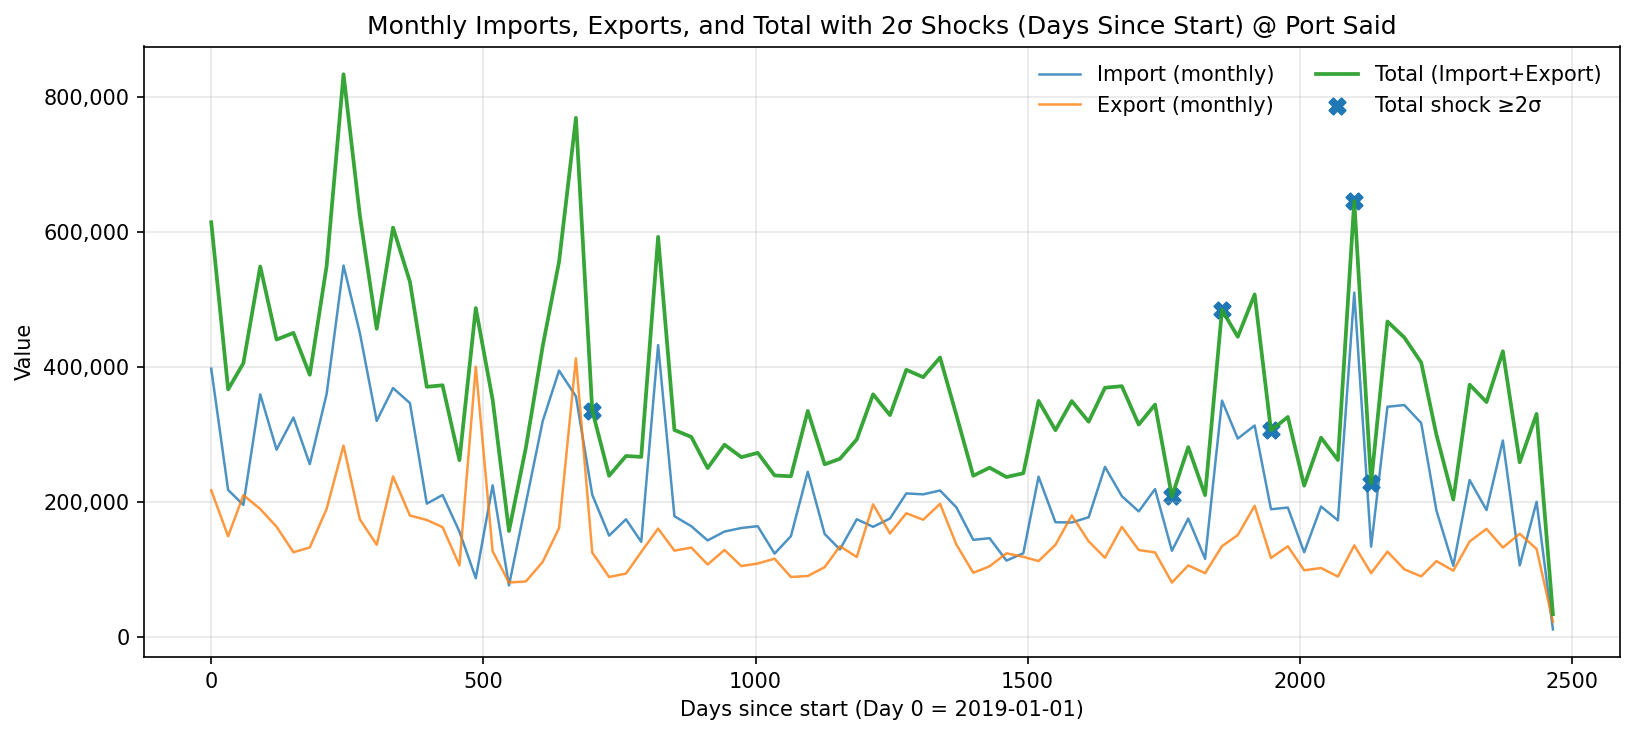

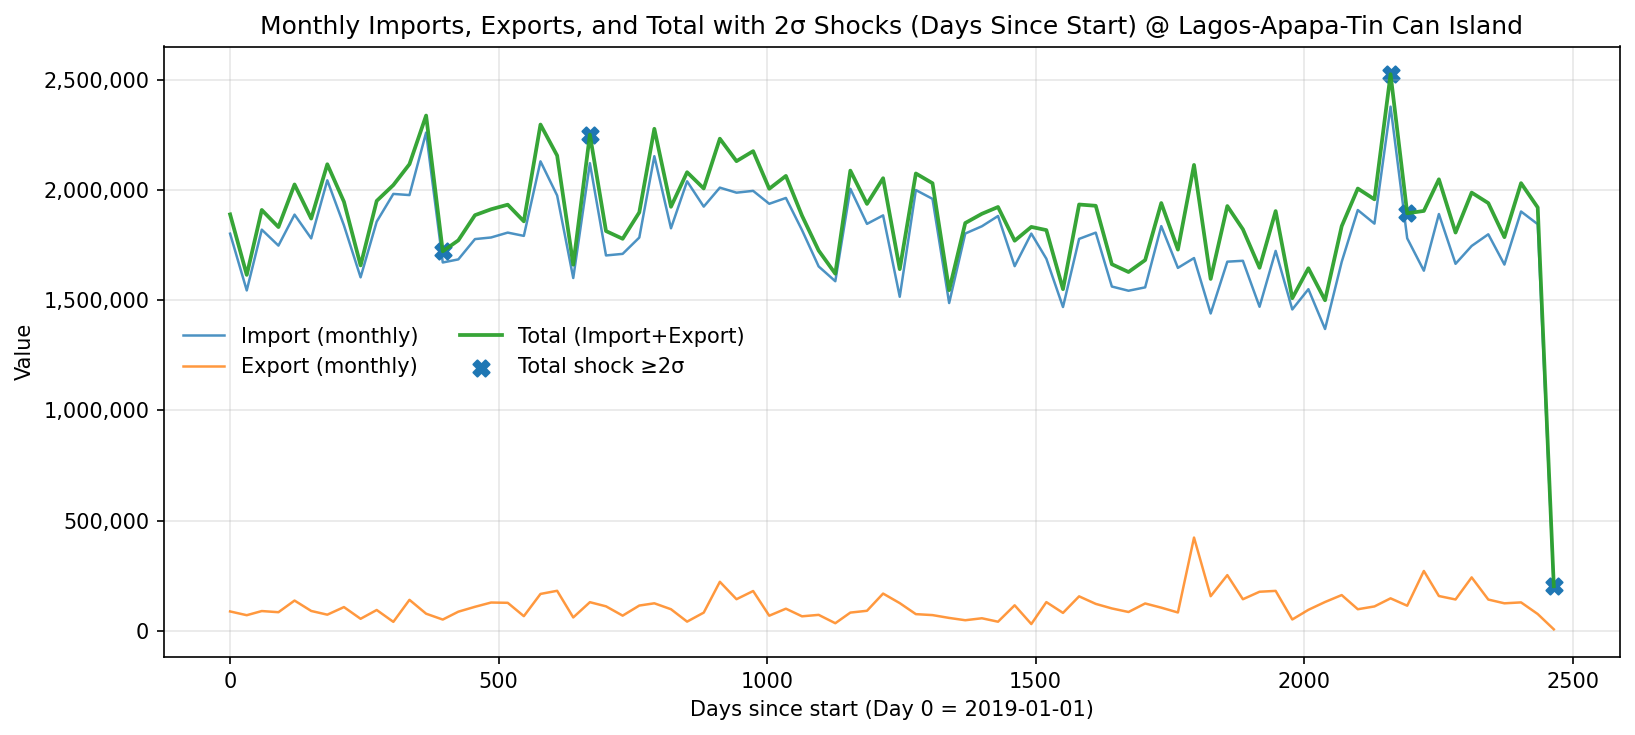

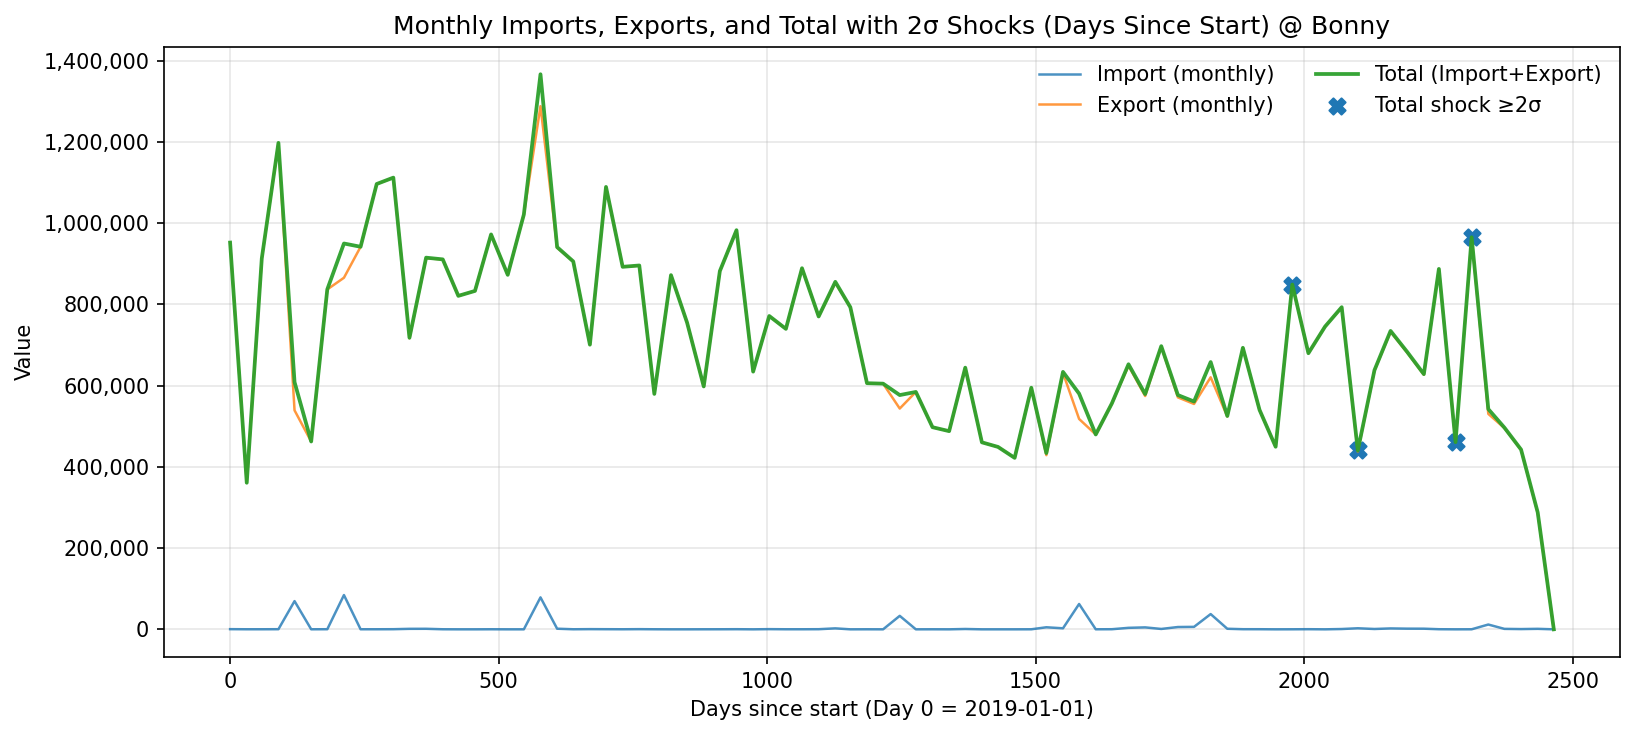

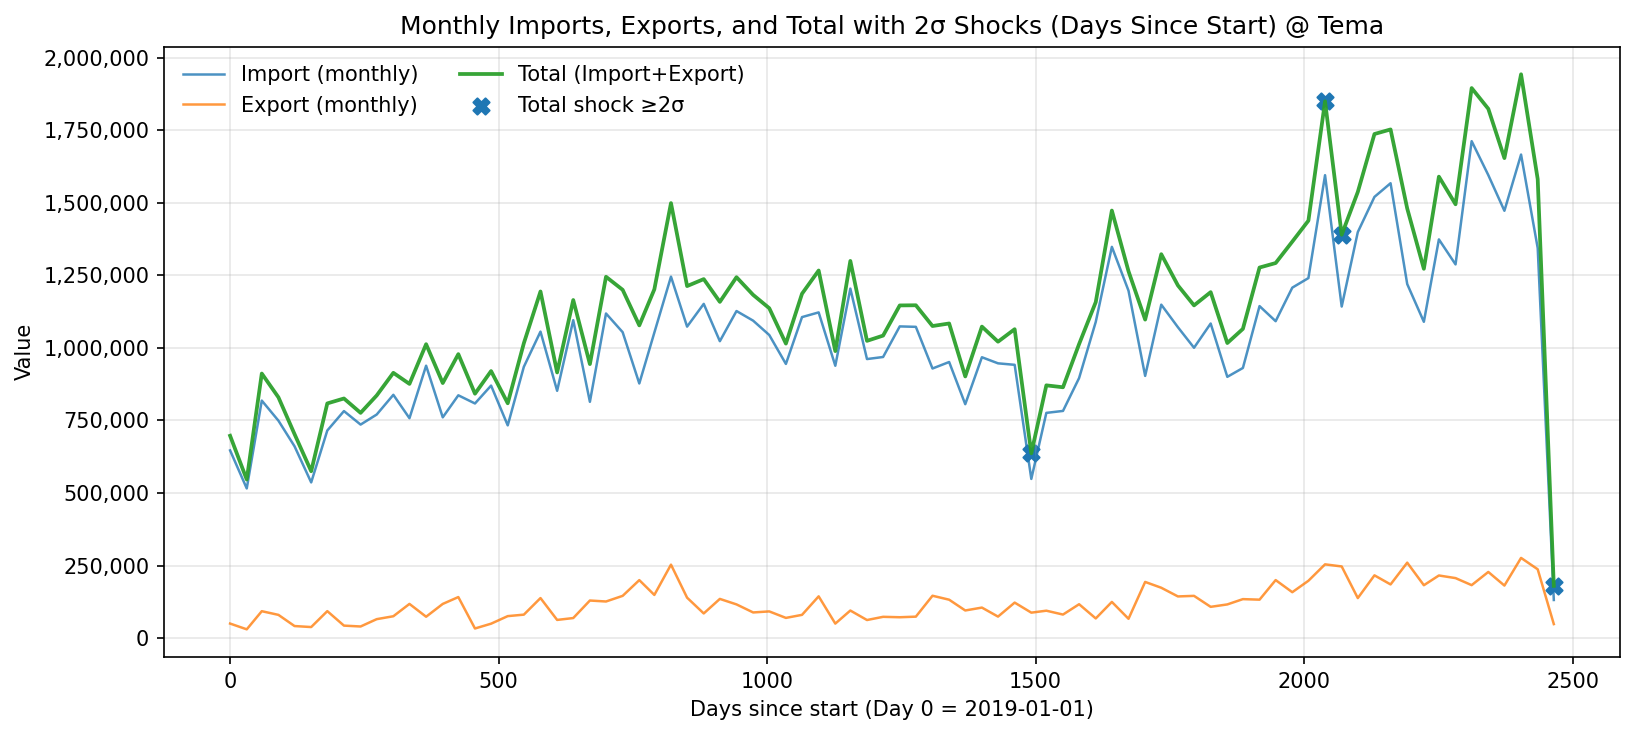

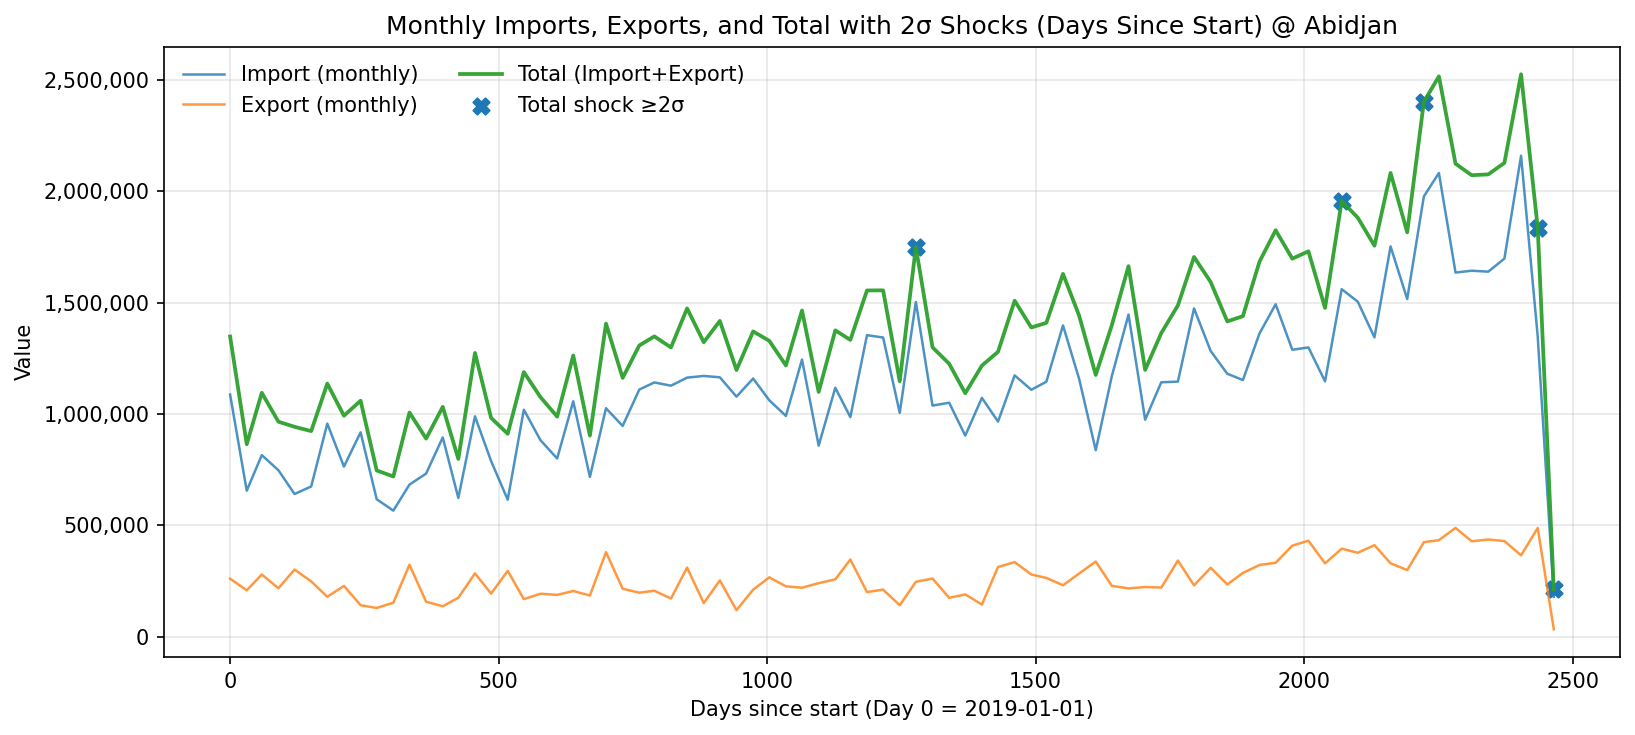

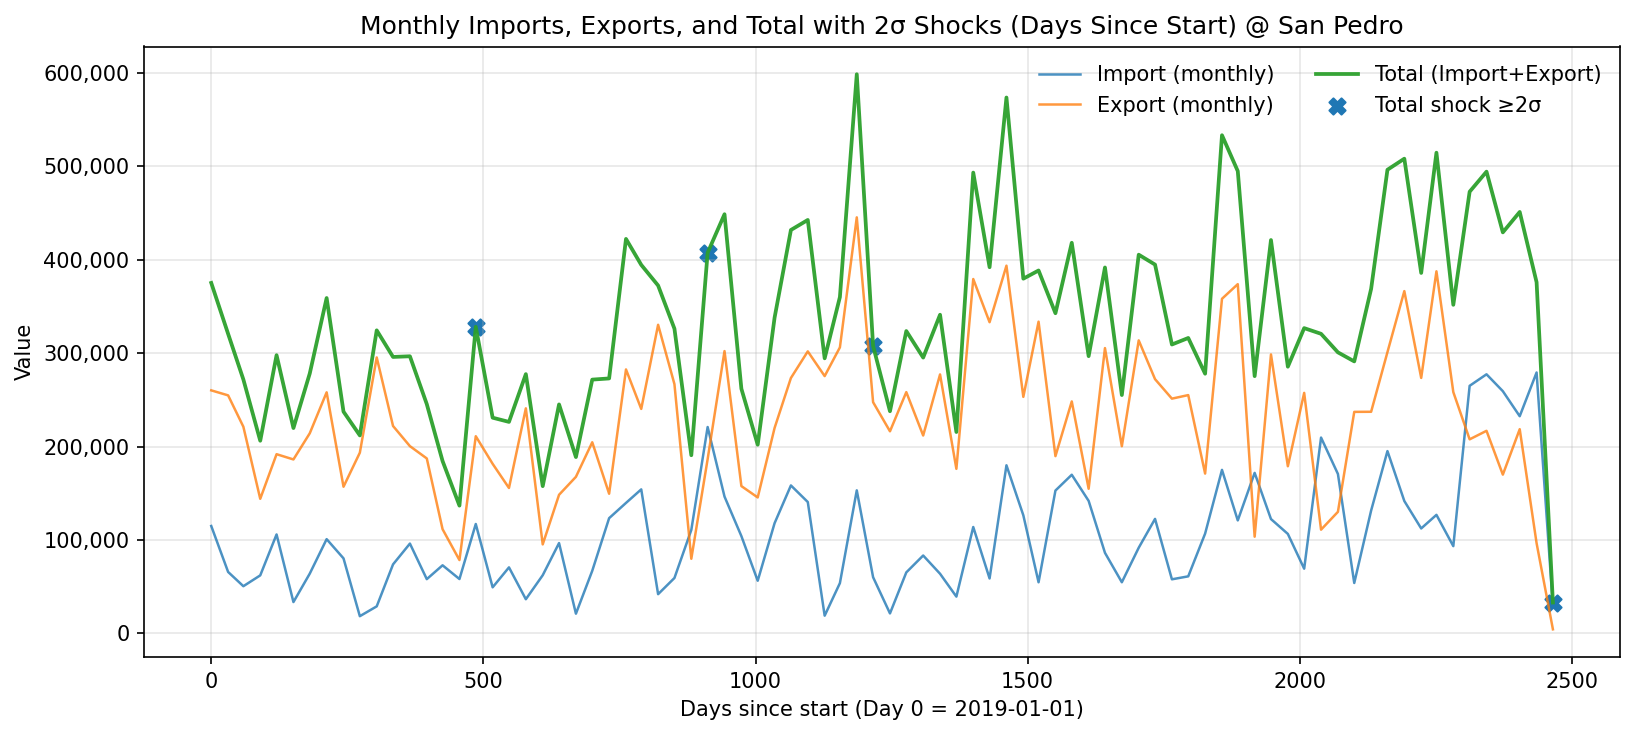

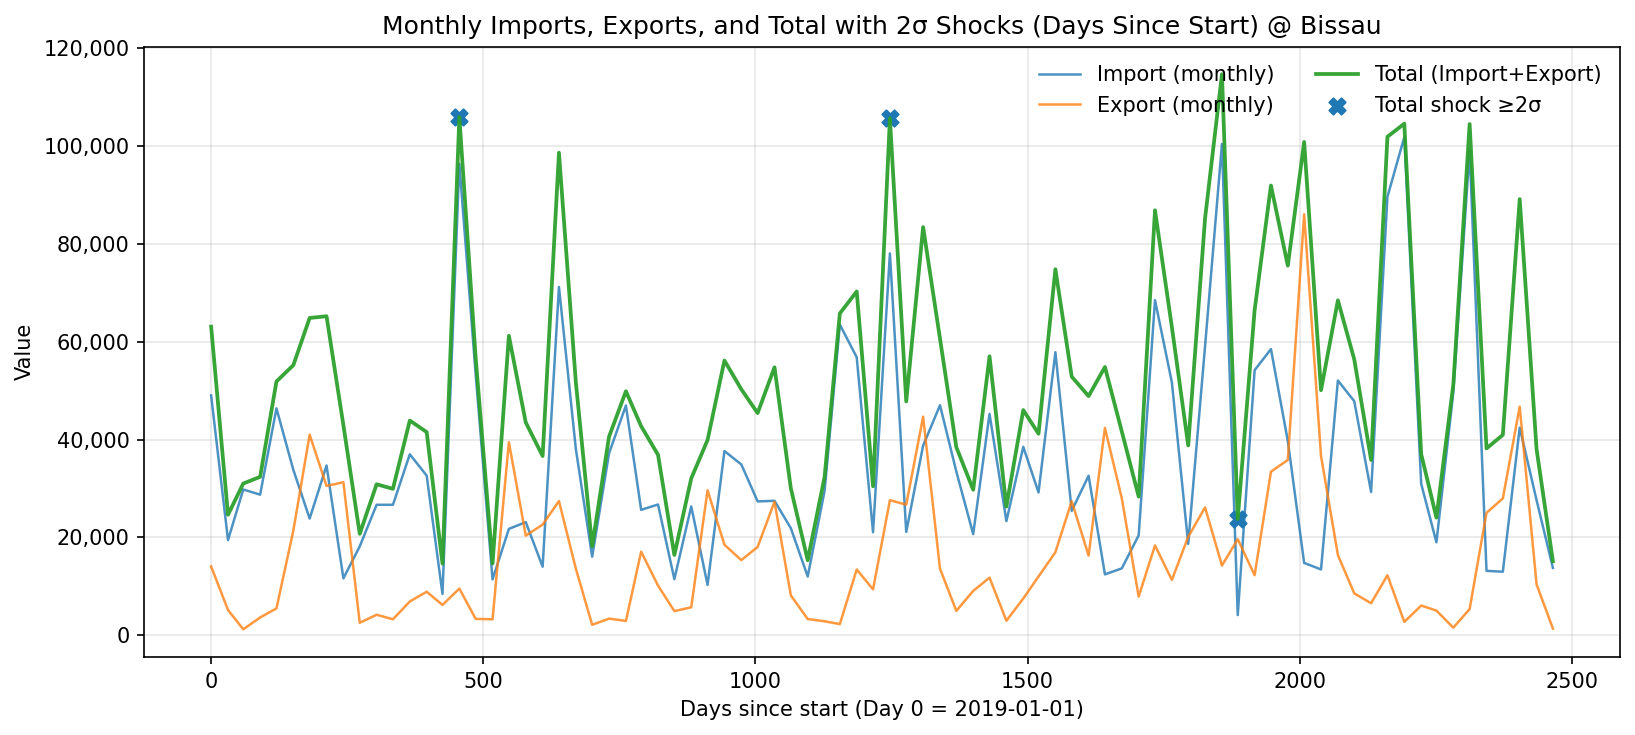

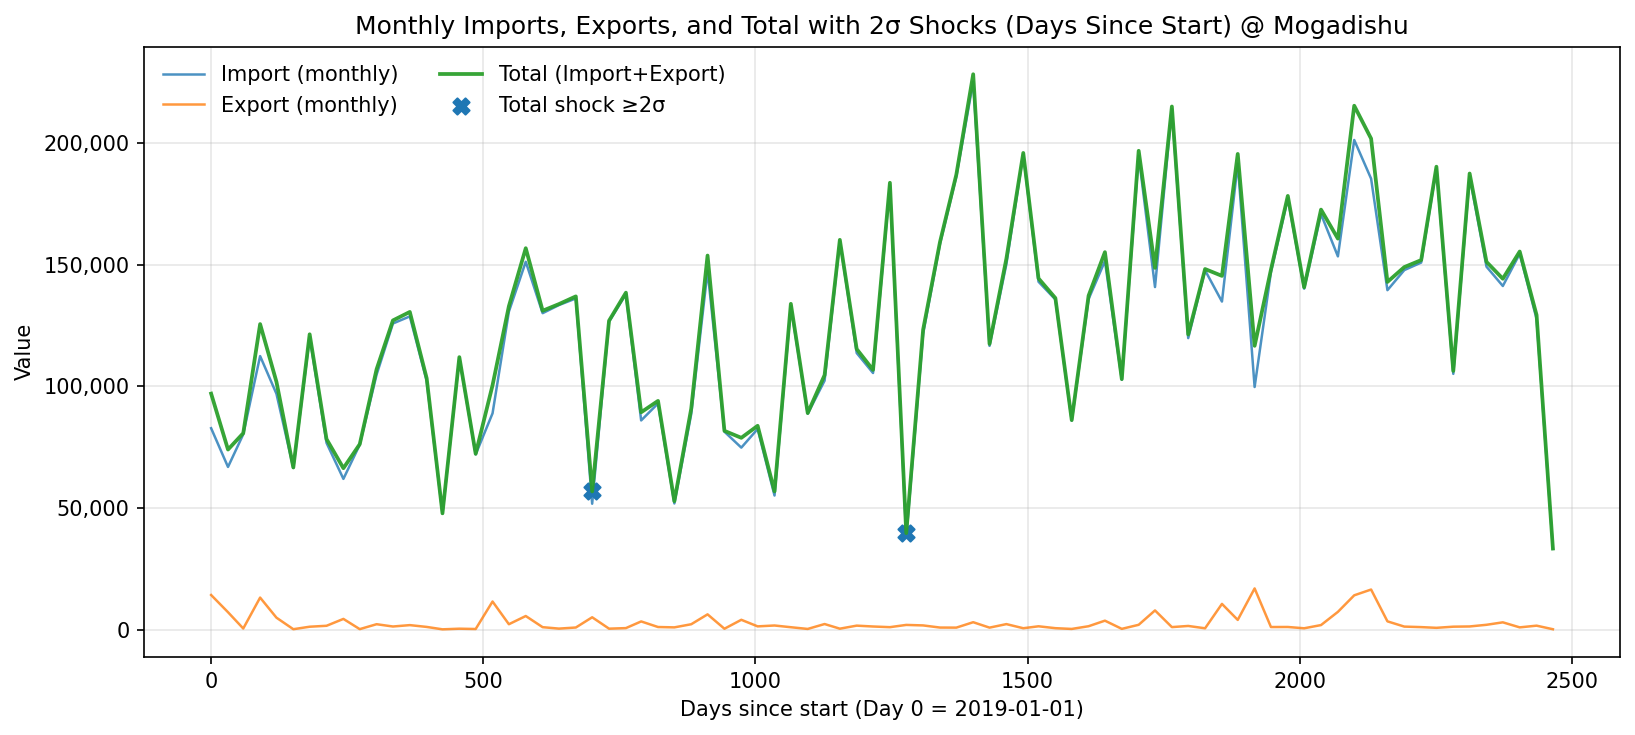

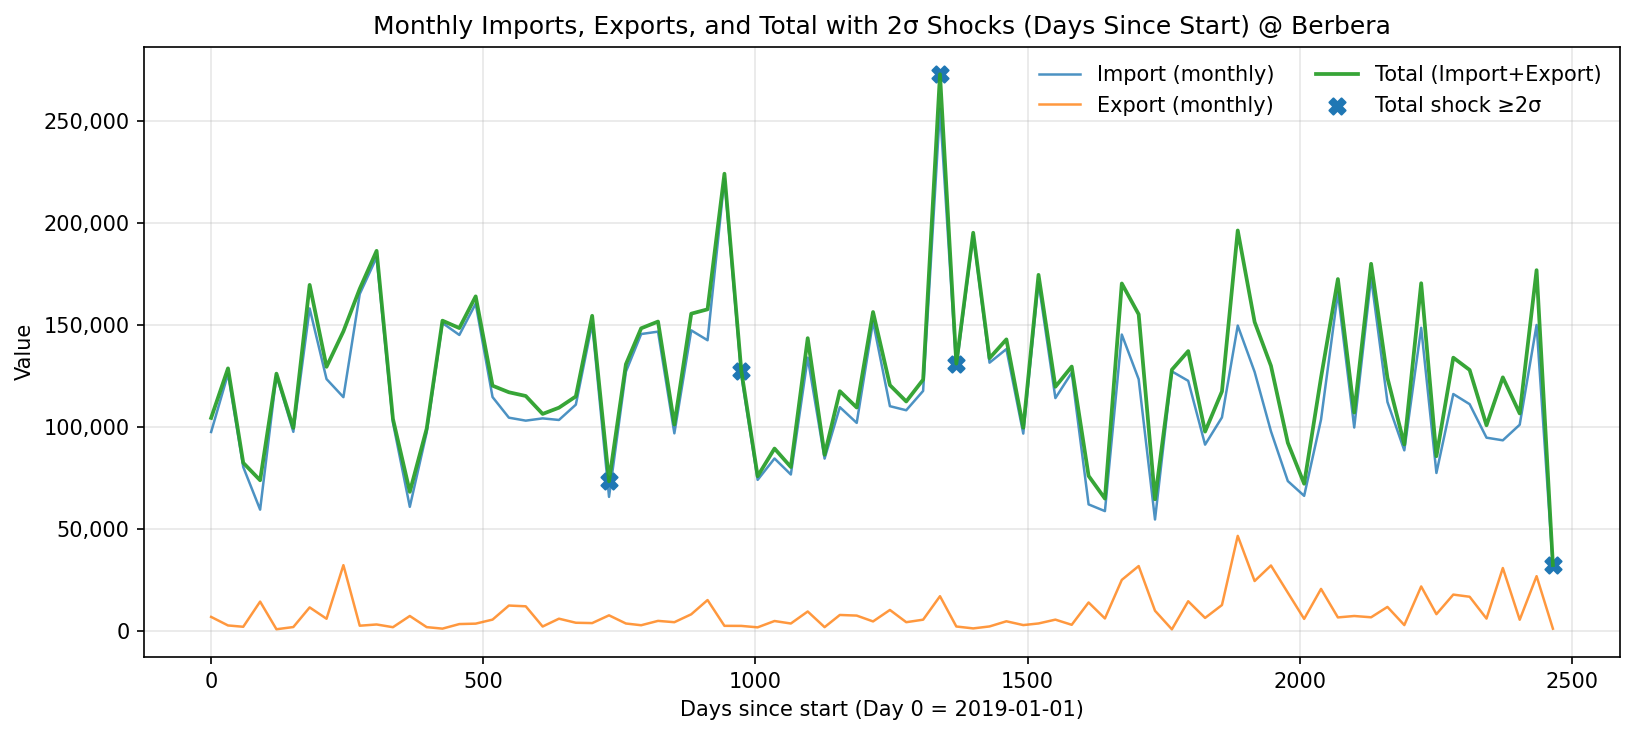

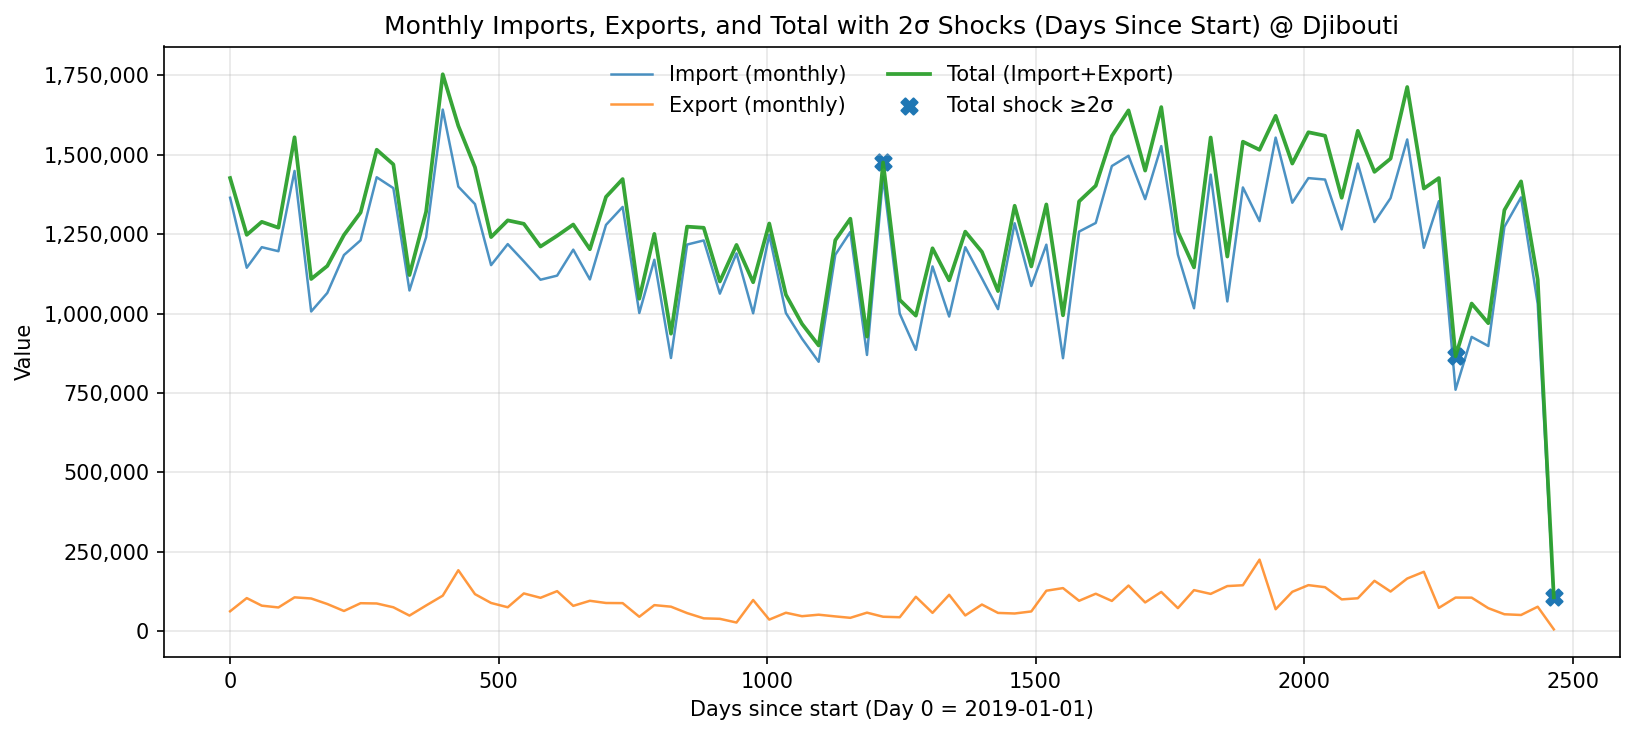

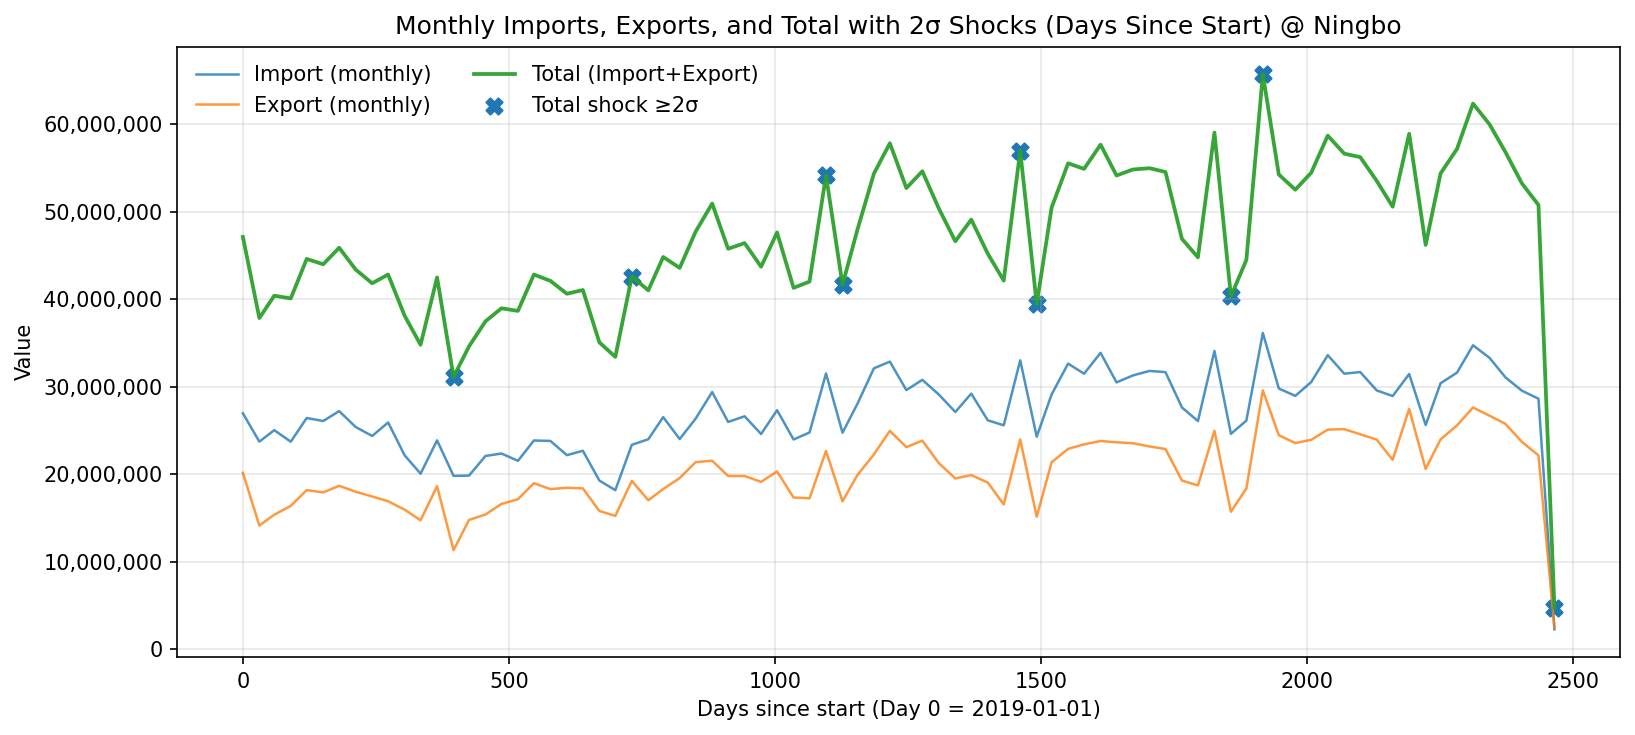

In [34]:
for city in cities:
    df = cities[city][0].copy()
    # normalize possible column name
    if "exports" in df.columns and "export" not in df.columns:
        df = df.rename(columns={"exports": "export"})
    
    need = ["date", "import", "export"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required column(s): {missing}")
    
    # Parse "YYYY/MM/DD 00:00:00+00" -> datetime (prevents 1971 issue)
    df["date"] = pd.to_datetime(
        df["date"].astype(str).str.slice(0, 10),  # keep YYYY/MM/DD
        format="%Y/%m/%d",
        errors="raise"
    )
    df = df.sort_values("date")
    
    # -------- 2) Monthly totals --------
    monthly = (
        df.set_index("date")[["import", "export"]]
          .resample("MS").sum()
    )
    
    monthly["total"] = monthly["import"] + monthly["export"]
    
    # -------- 3) Shocks based on TOTAL only (2σ) --------
    ROLL_WINDOW = 24           # months used to estimate typical change
    USE_PERCENT = False        # set True to use percent changes
    
    chg_total = monthly["total"].pct_change() if USE_PERCENT else monthly["total"].diff()
    mu  = chg_total.rolling(ROLL_WINDOW, min_periods=max(6, ROLL_WINDOW//2)).mean()
    sig = chg_total.rolling(ROLL_WINDOW, min_periods=max(6, ROLL_WINDOW//2)).std(ddof=0)
    
    z_total = (chg_total - mu) / sig
    mask_2sigma = z_total.abs() >= 2.0
    
    # Tidy table of total shocks (optional)
    total_shocks = (
        pd.DataFrame({
            "date": monthly.index,
            "total": monthly["total"].values,
            "MoM_change_total": chg_total.values,
            "z_total": z_total.values,
            "is_2sigma": mask_2sigma.values,
        })
        .dropna(subset=["z_total"])
        .query("is_2sigma")
        .reset_index(drop=True)
    )
    
    # -------- 4) X axis as days since start --------
    t0 = monthly.index.min()
    x_days = (monthly.index - t0).days
    
    # -------- 5) Plot --------
    fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
    
    # Monthly lines
    ax.plot(x_days, monthly["import"].values, lw=1.2, alpha=0.8, label="Import (monthly)")
    ax.plot(x_days, monthly["export"].values, lw=1.2, alpha=0.8, label="Export (monthly)")
    ax.plot(x_days, monthly["total"].values,  lw=1.8, alpha=0.95, label="Total (Import+Export)")
    
    # Shock markers (based on TOTAL only)
    m = mask_2sigma.reindex(monthly.index, fill_value=False).values
    ax.scatter(x_days[m], monthly["total"].values[m], s=60, marker="X", label="Total shock ≥2σ")
    
    ax.set_title("Monthly Imports, Exports, and Total with 2σ Shocks (Days Since Start) @ " + city)
    ax.set_xlabel(f"Days since start (Day 0 = {t0:%Y-%m-%d})")
    ax.set_ylabel("Value")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _ : f"{int(v):,}"))
    ax.grid(True, which="both", alpha=0.3)
    ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    plt.show()

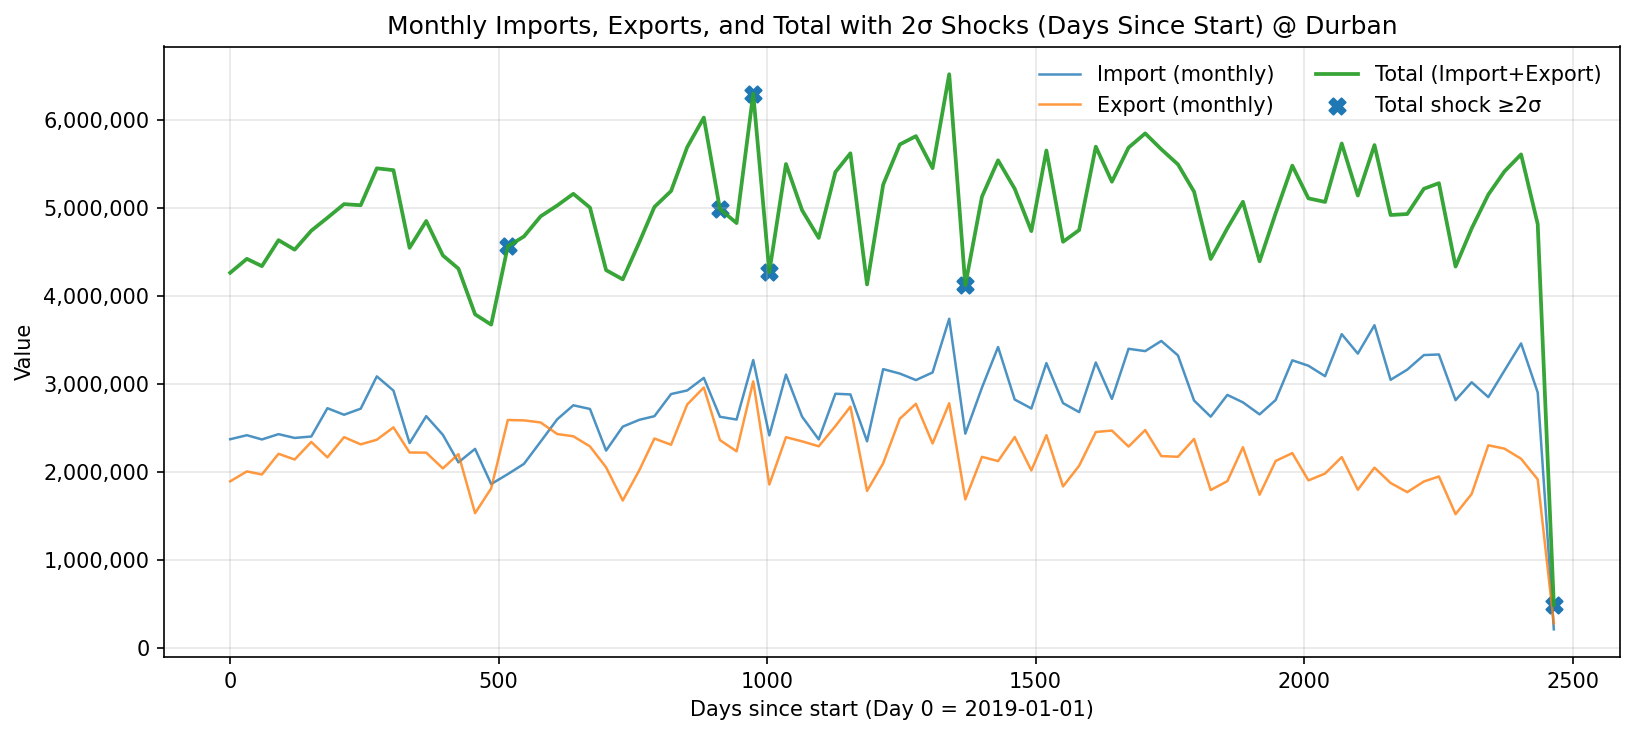

In [29]:
df = durban.copy()

# normalize possible column name
if "exports" in df.columns and "export" not in df.columns:
    df = df.rename(columns={"exports": "export"})

need = ["date", "import", "export"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise KeyError(f"Missing required column(s): {missing}")

# Parse "YYYY/MM/DD 00:00:00+00" -> datetime (prevents 1971 issue)
df["date"] = pd.to_datetime(
    df["date"].astype(str).str.slice(0, 10),  # keep YYYY/MM/DD
    format="%Y/%m/%d",
    errors="raise"
)
df = df.sort_values("date")

# -------- 2) Monthly totals --------
monthly = (
    df.set_index("date")[["import", "export"]]
      .resample("MS").sum()
)

monthly["total"] = monthly["import"] + monthly["export"]

# -------- 3) Shocks based on TOTAL only (2σ) --------
ROLL_WINDOW = 24           # months used to estimate typical change
USE_PERCENT = False        # set True to use percent changes

chg_total = monthly["total"].pct_change() if USE_PERCENT else monthly["total"].diff()
mu  = chg_total.rolling(ROLL_WINDOW, min_periods=max(6, ROLL_WINDOW//2)).mean()
sig = chg_total.rolling(ROLL_WINDOW, min_periods=max(6, ROLL_WINDOW//2)).std(ddof=0)

z_total = (chg_total - mu) / sig
mask_2sigma = z_total.abs() >= 2.0

# Tidy table of total shocks (optional)
total_shocks = (
    pd.DataFrame({
        "date": monthly.index,
        "total": monthly["total"].values,
        "MoM_change_total": chg_total.values,
        "z_total": z_total.values,
        "is_2sigma": mask_2sigma.values,
    })
    .dropna(subset=["z_total"])
    .query("is_2sigma")
    .reset_index(drop=True)
)

# -------- 4) X axis as days since start --------
t0 = monthly.index.min()
x_days = (monthly.index - t0).days

# -------- 5) Plot --------
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)

# Monthly lines
ax.plot(x_days, monthly["import"].values, lw=1.2, alpha=0.8, label="Import (monthly)")
ax.plot(x_days, monthly["export"].values, lw=1.2, alpha=0.8, label="Export (monthly)")
ax.plot(x_days, monthly["total"].values,  lw=1.8, alpha=0.95, label="Total (Import+Export)")

# Shock markers (based on TOTAL only)
m = mask_2sigma.reindex(monthly.index, fill_value=False).values
ax.scatter(x_days[m], monthly["total"].values[m], s=60, marker="X", label="Total shock ≥2σ")

ax.set_title("Monthly Imports, Exports, and Total with 2σ Shocks (Days Since Start) @ Durban")
ax.set_xlabel(f"Days since start (Day 0 = {t0:%Y-%m-%d})")
ax.set_ylabel("Value")
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _ : f"{int(v):,}"))
ax.grid(True, which="both", alpha=0.3)
ax.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

**Correlation between ports**: Includes currency and volume correlation

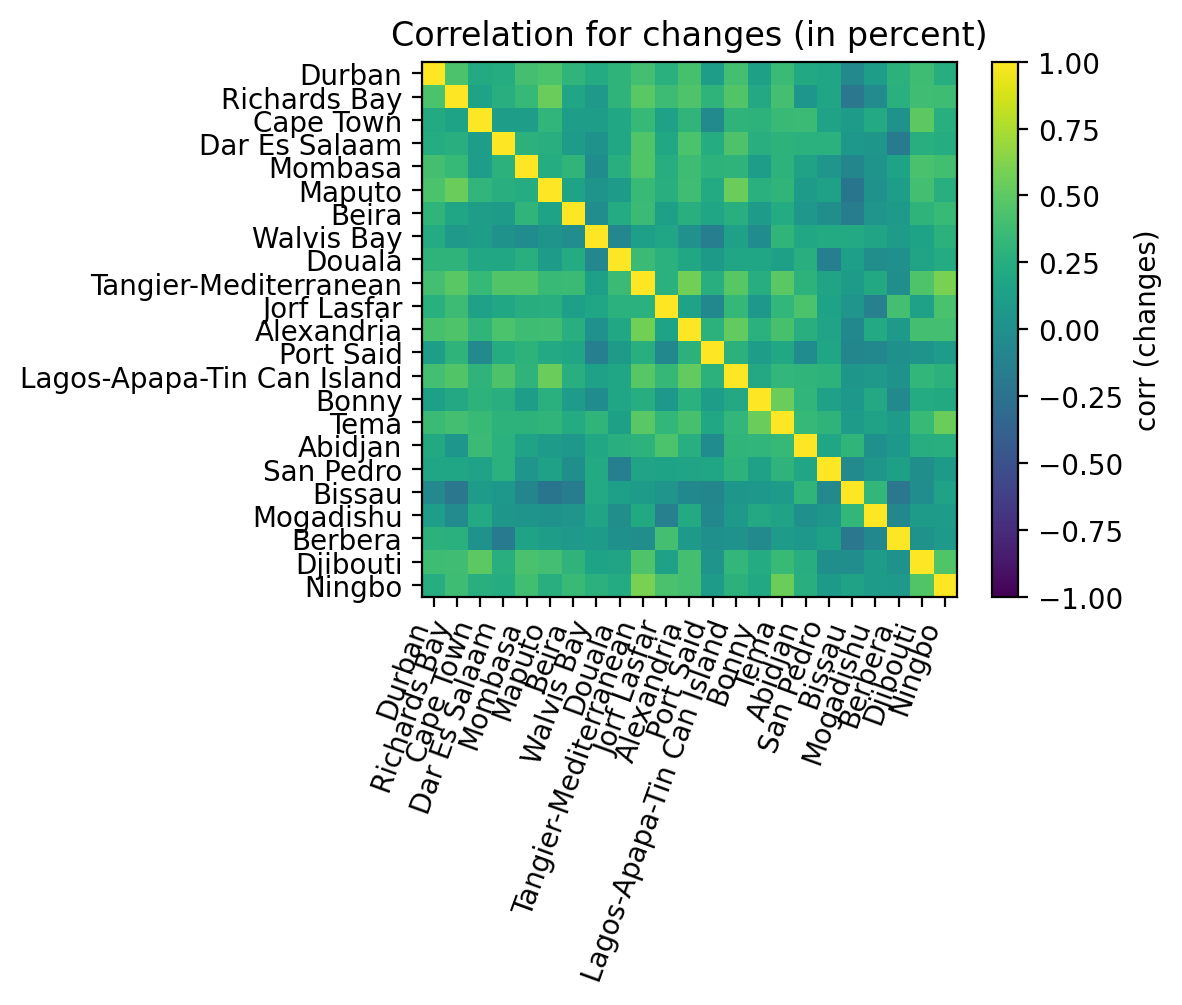

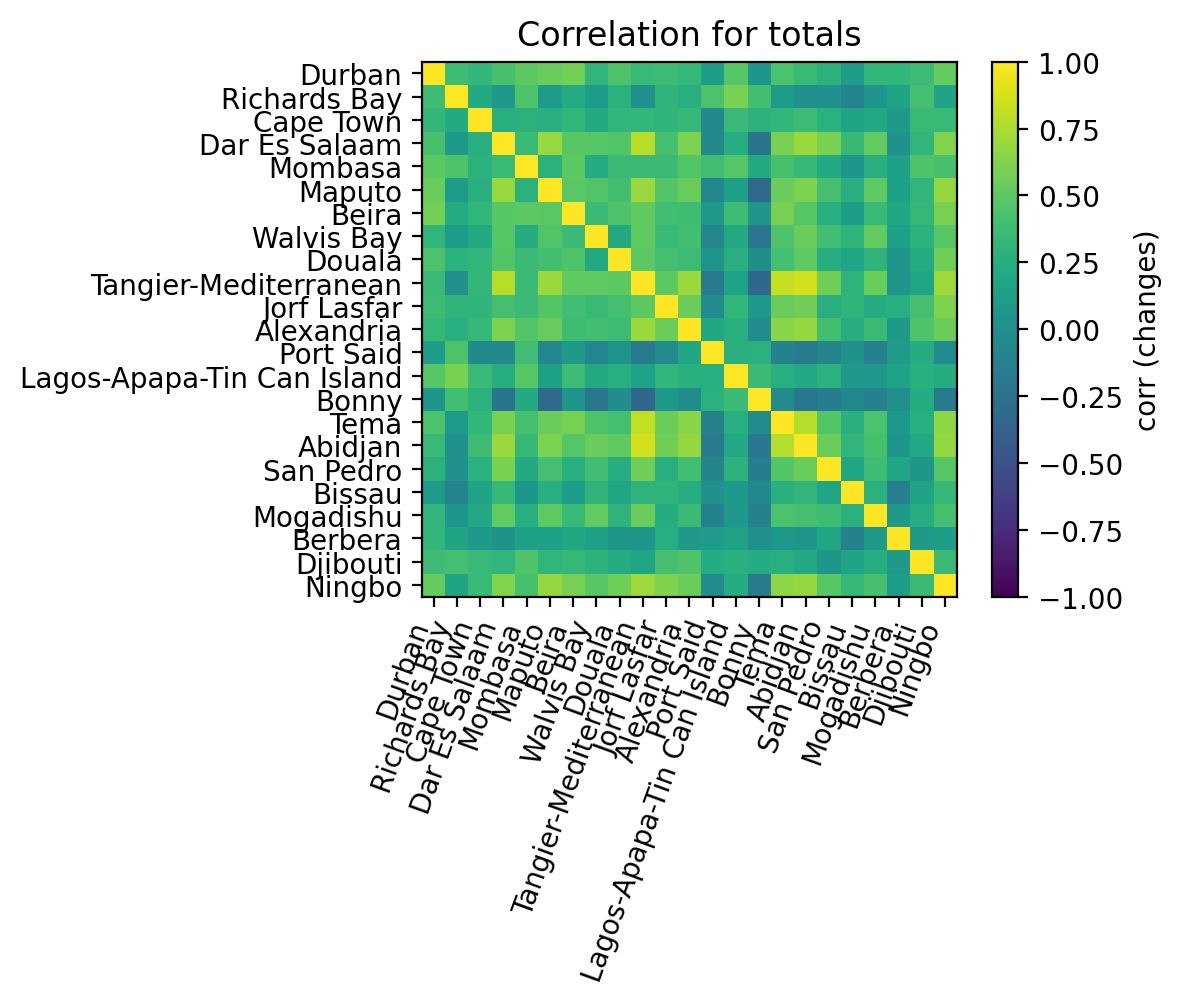

In [36]:
from functools import reduce

ROLL_WINDOW = 24
USE_PERCENT = True

all_totals = {}        # monthly total per city
all_changes = {}       # monthly change per city (for “shock-ish” corr)

for city in cities:   # cities is your dict: {city_name: df}
    df = cities[city][0].copy()


    need = ["date", "import", "export"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"{city}: missing {missing}")

    # dates
    df["date"] = pd.to_datetime(
        df["date"].astype(str).str.slice(0, 10),
        format="%Y/%m/%d",
        errors="raise"
    )
    df = df.sort_values("date")

    # monthly aggregation
    monthly = (
        df.set_index("date")[["import", "export"]]
          .resample("MS").sum()
    )
    monthly["total"] = monthly["import"] + monthly["export"]

    # store TOTAL series
    all_totals[city] = monthly["total"]

    # also store change series (often better for corr)
    chg = monthly["total"].pct_change() if USE_PERCENT else monthly["total"].diff()
    all_changes[city] = chg

    # align on the monthly index (outer join so ports with different start dates still appear)
    totals_df = pd.concat(all_totals, axis=1)   # columns will be a MultiIndex (city,). Let's flatten:
    totals_df.columns = totals_df.columns.get_level_values(0)
    
    changes_df = pd.concat(all_changes, axis=1)
    changes_df.columns = changes_df.columns.get_level_values(0)
    
# 1) Correlation of levels (volumes)
corr_totals = totals_df.corr()

# 2) Correlation of changes (usually more meaningful)
corr_changes = changes_df.corr()

#Correlation for changes
fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
im = ax.imshow(corr_changes, vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_changes.columns)))
ax.set_xticklabels(corr_changes.columns, rotation=70, ha="right")
ax.set_yticks(range(len(corr_changes.index)))
ax.set_yticklabels(corr_changes.index)
fig.colorbar(im, ax=ax, label="corr (changes)")
plt.title("Correlation for changes (in percent)")
plt.tight_layout()
plt.show()

#Correlation for totals
fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
im = ax.imshow(corr_totals, vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_totals.columns)))
ax.set_xticklabels(corr_totals.columns, rotation=70, ha="right")
ax.set_yticks(range(len(corr_totals.index)))
ax.set_yticklabels(corr_totals.index)
fig.colorbar(im, ax=ax, label="corr (changes)")
plt.title("Correlation for totals")
plt.tight_layout()
plt.show()

In [ ]:
print(corr_totals.round(2))


In [ ]:
for c in citiesL:
    print(cities[c][1])

In [ ]:
#To Display port
# for c in citiesL:
#     ticker_symbol = cities[c][1]
#     # Convert ticker_symbol to string if it's a DataFrame
#     if isinstance(ticker_symbol, pd.DataFrame):
#         ticker_symbol = str(ticker_symbol)  # Convert DataFrame to string
    
#     start_date = "2019-01-01"
#     end_date = "2025-05-18"
#     forex_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    
#     # assuming you already have: forex_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    
#     s = forex_data['Close'].dropna()
#     ma = s.rolling(30, min_periods=1).mean()  # ~30 trading days ≈ 1.5 months
    
#     fig, ax = plt.subplots(figsize=(12, 6), dpi=160)
    
#     # main line + optional rolling mean
#     ax.plot(s.index, s.values, linewidth=1.6, label="Close")
#     ax.plot(ma.index, ma.values, linewidth=1.2, alpha=0.8, linestyle="--", label="30-day Moving Average")
    
#     # x-axis formatting: year ticks + monthly minor ticks
#     ax.xaxis.set_major_locator(mdates.YearLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
#     ax.xaxis.set_minor_locator(mdates.MonthLocator())
#     for label in ax.get_xticklabels(which='major'):
#         label.set(rotation=0, ha='center')
    
#     # tidy labels/titles
#     ax.set_title(f"{ticker_symbol} — Close", pad=10)  # Now ticker_symbol is a string
#     ax.set_xlabel("Date")
#     ax.set_ylabel("Price")
    
#     # grid and margins
#     ax.grid(True, which="major", alpha=0.25)
#     ax.grid(True, which="minor", alpha=0.10)
#     ax.margins(x=0.01, y=0.05)
    
#     # de-clutter spines
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    
#     # legend (only if you keep the MA line)
#     ax.legend(frameon=True, loc="upper left")
    
#     plt.tight_layout()
#     plt.show()

In [37]:
top = cities["Durban"][0].copy()
top["date"] = (
    pd.to_datetime(top["date"].astype(str).str[:10], format="%Y/%m/%d", utc=True)  # parse as UTC
      .dt.tz_localize(None)                              # drop tz -> tz-naive
      .dt.normalize() 
)
top

date  year  month  day   portid portname       country ISO3  \
2504802 2019-01-31  2019      1   31  port311   Durban  South Africa  ZAF   
2504852 2019-03-22  2019      3   22  port311   Durban  South Africa  ZAF   
2504857 2019-03-23  2019      3   23  port311   Durban  South Africa  ZAF   
2504859 2019-02-01  2019      2    1  port311   Durban  South Africa  ZAF   
2504863 2019-03-24  2019      3   24  port311   Durban  South Africa  ZAF   
...            ...   ...    ...  ...      ...      ...           ...  ...   
2507595 2025-07-07  2025      7    7  port311   Durban  South Africa  ZAF   
2507596 2025-05-15  2025      5   15  port311   Durban  South Africa  ZAF   
2507597 2025-05-16  2025      5   16  port311   Durban  South Africa  ZAF   
2507598 2025-05-17  2025      5   17  port311   Durban  South Africa  ZAF   
2507599 2025-05-18  2025      5   18  port311   Durban  South Africa  ZAF   

         portcalls_container  portcalls_dry_bulk  ...   import_cargo  \
2504802                    5                   5  ...   49178.219267   
2504852                    2                   2  ...   55729.291935   
2504857                    2                   1  ...  188420.922992   
2504859                    3                   4  ...  119919.052404   
2504863                    1                   1  ...    3240.380983   
...                      ...                 ...  ...            ...   
2507595                    2                   2  ...   66320.957002   
2507596                    3                   2  ...  184093.103362   
2507597                    2                   0  ...  103529.009669   
2507598                    0                   0  ...    3866.725236   
2507599                    5                   1  ...   91521.274731   

                import  export_container  export_dry_bulk  \
2504802   61135.185957     124243.804661     85610.369508   
2504852   61983.710383       2647.732792     11493.119701   
2504857  229387.989055      31032.412710         0.000000   
2504859  119919.052404      39522.673571     14336.024969   
2504863    3240.380983      30443.516967     18054.329733   
...                ...               ...              ...   
2507595   89990.082004      20624.394437     61112.351656   
2507596  197192.157545      40505.390367     27889.669926   
2507597  146329.694088      15669.910465         0.000000   
2507598   77319.891522          0.000000         0.000000   
2507599  125232.409550      58207.092410      2060.553674   

         export_general_cargo  export_roro  export_tanker   export_cargo  \
2504802              0.000000     0.000000       0.000000  209854.174169   
2504852              0.000000     0.000000     527.414813   14140.852493   
2504857              0.000000   632.656842       0.000000   31665.069552   
2504859           3114.140740     0.000000       0.000000   56972.839280   
2504863              0.000000     0.000000       0.000000   48497.846700   
...                       ...          ...            ...            ...   
2507595              0.000000   632.656842       0.000000   82369.402935   
2507596              0.000000     0.000000       0.000000   68395.060293   
2507597            938.268489     0.000000       0.000000   16608.178954   
2507598           3855.503110     0.000000       0.000000    3855.503110   
2507599              0.000000     0.000000    5132.891438   60267.646084   

                export  ObjectId  
2504802  209854.174169   2504803  
2504852   14668.267306   2504853  
2504857   31665.069552   2504858  
2504859   56972.839280   2504860  
2504863   48497.846700   2504864  
...                ...       ...  
2507595   82369.402935   2507596  
2507596   68395.060293   2507597  
2507597   16608.178954   2507598  
2507598    3855.503110   2507599  
2507599   65400.537522   2507600  

[2468 rows x 30 columns]

In [38]:
pdc = {}
for c in citiesL:
    ticker_symbol = cities[c][1]
    start_date = "2019-01-01"
    end_date = "2025-05-18"
    fx = (
    yf.download(ticker_symbol, start="2019-01-01", end="2025-10-03", progress=False)["Close"]
      .reset_index()                                     
      .rename(columns={"Date":"date"})
    )
    fx["date"] = pd.to_datetime(fx["date"]).dt.tz_localize(None).dt.normalize()

    top = cities[c][0].copy()
    top["date"] = (
    pd.to_datetime(top["date"].astype(str).str[:10], format="%Y/%m/%d", utc=True)  # parse as UTC
      .dt.tz_localize(None)                              # drop tz -> tz-naive
      .dt.normalize() 
    )

    # Now dates are aligned and merge will work:
    merged = top.merge(fx, on="date", how="left", validate="m:1")
    clean = merged.dropna(subset=[ticker_symbol]).reset_index(drop=True)
    pdc[c] = clean
pdc['Durban']

/var/folders/lx/ddlr7_8s19s00cjxkh6fqgyh0000gn/T/ipykernel_81685/1351490614.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(ticker_symbol, start="2019-01-01", end="2025-10-03", progress=False)["Close"]
/var/folders/lx/ddlr7_8s19s00cjxkh6fqgyh0000gn/T/ipykernel_81685/1351490614.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(ticker_symbol, start="2019-01-01", end="2025-10-03", progress=False)["Close"]
/var/folders/lx/ddlr7_8s19s00cjxkh6fqgyh0000gn/T/ipykernel_81685/1351490614.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(ticker_symbol, start="2019-01-01", end="2025-10-03", progress=False)["Close"]
/var/folders/lx/ddlr7_8s19s00cjxkh6fqgyh0000gn/T/ipykernel_81685/1351490614.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(ticker_symbol, start="2019-01-01", end="2025-10-03", progress=False)["

date  year  month  day   portid portname       country ISO3  \
0    2019-01-31  2019      1   31  port311   Durban  South Africa  ZAF   
1    2019-03-22  2019      3   22  port311   Durban  South Africa  ZAF   
2    2019-02-01  2019      2    1  port311   Durban  South Africa  ZAF   
3    2019-03-25  2019      3   25  port311   Durban  South Africa  ZAF   
4    2019-01-01  2019      1    1  port311   Durban  South Africa  ZAF   
...         ...   ...    ...  ...      ...      ...           ...  ...   
1754 2025-05-13  2025      5   13  port311   Durban  South Africa  ZAF   
1755 2025-05-14  2025      5   14  port311   Durban  South Africa  ZAF   
1756 2025-07-07  2025      7    7  port311   Durban  South Africa  ZAF   
1757 2025-05-15  2025      5   15  port311   Durban  South Africa  ZAF   
1758 2025-05-16  2025      5   16  port311   Durban  South Africa  ZAF   

      portcalls_container  portcalls_dry_bulk  ...         import  \
0                       5                   5  ...   61135.185957   
1                       2                   2  ...   61983.710383   
2                       3                   4  ...  119919.052404   
3                       2                   1  ...   38470.105903   
4                       0                   2  ...   17925.036393   
...                   ...                 ...  ...            ...   
1754                    2                   0  ...   50885.816545   
1755                    1                   2  ...   17895.302336   
1756                    2                   2  ...   89990.082004   
1757                    3                   2  ...  197192.157545   
1758                    2                   0  ...  146329.694088   

      export_container  export_dry_bulk  export_general_cargo  export_roro  \
0        124243.804661     85610.369508              0.000000     0.000000   
1          2647.732792     11493.119701              0.000000     0.000000   
2         39522.673571     14336.024969           3114.140740     0.000000   
3        133274.495583      2194.662052              0.000000     0.000000   
4             0.000000     12017.179343           2117.899210     0.000000   
...                ...              ...                   ...          ...   
1754       4730.200956         0.000000              0.000000     0.000000   
1755      73672.714975     39190.812021              0.000000     0.000000   
1756      20624.394437     61112.351656              0.000000   632.656842   
1757      40505.390367     27889.669926              0.000000     0.000000   
1758      15669.910465         0.000000            938.268489     0.000000   

      export_tanker   export_cargo         export  ObjectId  ZARUSD=X  
0          0.000000  209854.174169  209854.174169   2504803  0.075031  
1        527.414813   14140.852493   14668.267306   2504853  0.070426  
2          0.000000   56972.839280   56972.839280   2504860  0.075479  
3      37260.832618  135469.157635  172729.990253   2504870  0.069102  
4       6402.406692   14135.078552   20537.485244   2504889  0.070792  
...             ...            ...            ...       ...       ...  
1754       0.000000    4730.200956    4730.200956   2507593  0.054813  
1755    2566.445719  112863.526996  115429.972715   2507595  0.054652  
1756       0.000000   82369.402935   82369.402935   2507596  0.056851  
1757       0.000000   68395.060293   68395.060293   2507597  0.054897  
1758       0.000000   16608.178954   16608.178954   2507598  0.055564  

[1759 rows x 31 columns]

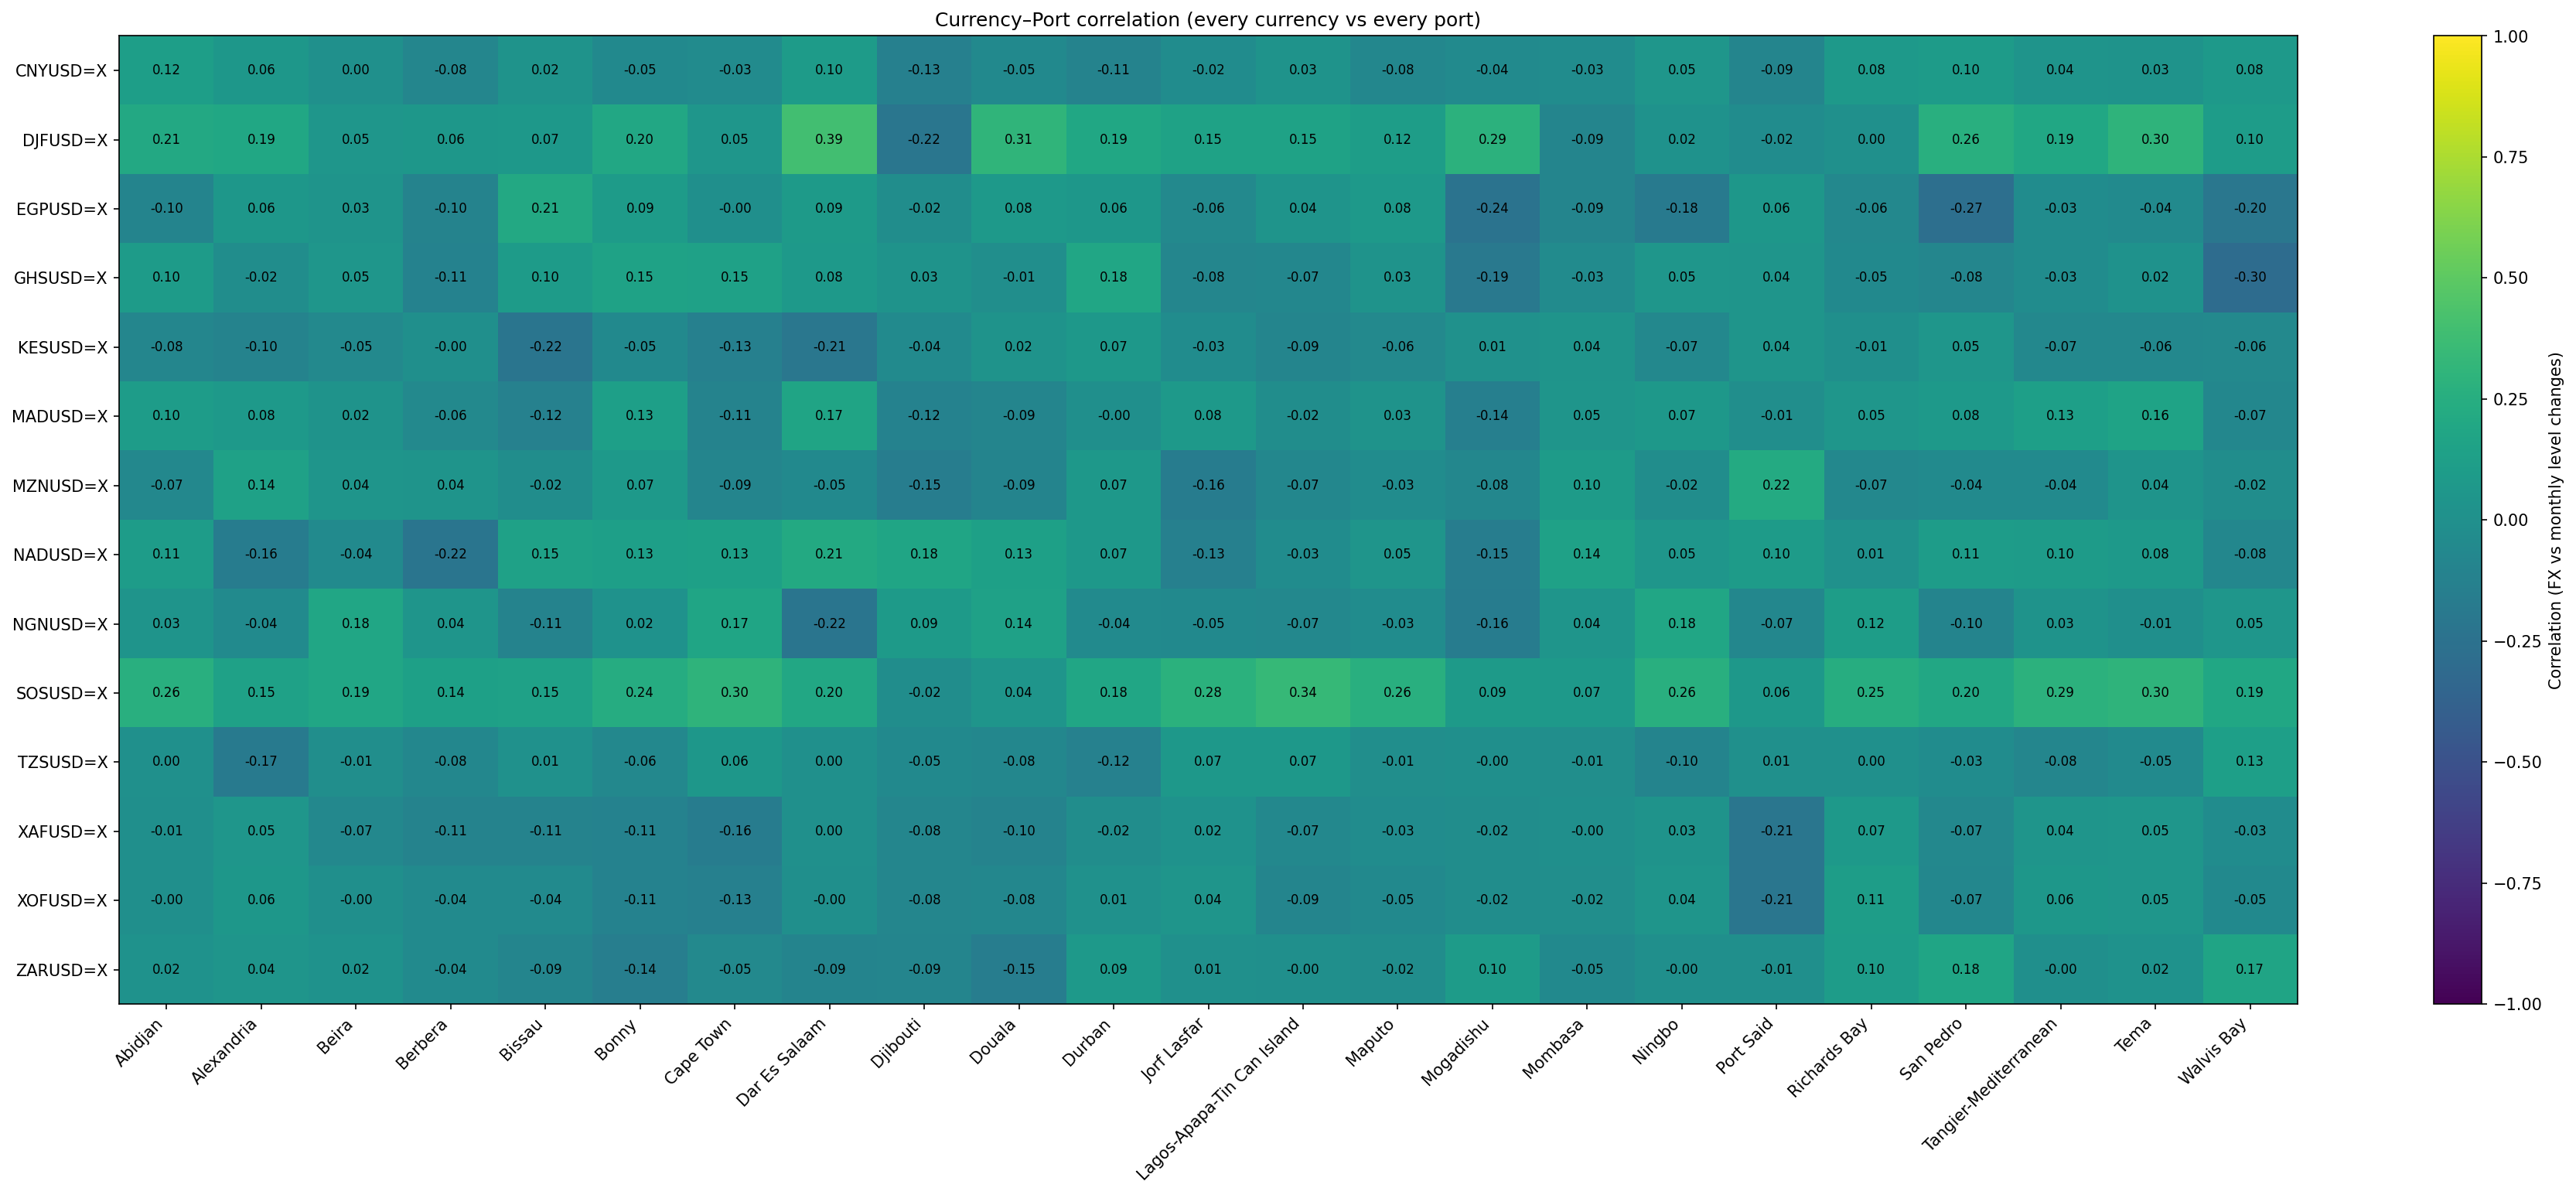

Abidjan  Alexandria  Beira  Berbera  Bissau  Bonny  Cape Town  \
CNYUSD=X    0.118       0.055  0.001   -0.078   0.024 -0.051     -0.031   
DJFUSD=X    0.207       0.188  0.048    0.062   0.067  0.196      0.052   
EGPUSD=X   -0.100       0.057  0.033   -0.102   0.210  0.094     -0.000   
GHSUSD=X    0.096      -0.023  0.054   -0.111   0.096  0.152      0.148   
KESUSD=X   -0.082      -0.102 -0.055   -0.005  -0.224 -0.050     -0.128   
MADUSD=X    0.105       0.076  0.025   -0.056  -0.119  0.125     -0.106   
MZNUSD=X   -0.067       0.144  0.039    0.036  -0.021  0.071     -0.091   
NADUSD=X    0.106      -0.164 -0.043   -0.225   0.148  0.132      0.133   
NGNUSD=X    0.031      -0.044  0.184    0.041  -0.109  0.023      0.173   
SOSUSD=X    0.264       0.147  0.187    0.136   0.145  0.236      0.302   
TZSUSD=X    0.002      -0.174 -0.012   -0.075   0.015 -0.063      0.060   
XAFUSD=X   -0.005       0.049 -0.067   -0.105  -0.107 -0.112     -0.159   
XOFUSD=X   -0.000       0.056 -0.003   -0.041  -0.041 -0.113     -0.128   
ZARUSD=X    0.017       0.044  0.020   -0.043  -0.091 -0.142     -0.055   

          Dar Es Salaam  Djibouti  Douala  ...  Maputo  Mogadishu  Mombasa  \
CNYUSD=X          0.100    -0.125  -0.054  ...  -0.077     -0.042   -0.029   
DJFUSD=X          0.391    -0.219   0.306  ...   0.116      0.285   -0.092   
EGPUSD=X          0.091    -0.022   0.084  ...   0.082     -0.237   -0.092   
GHSUSD=X          0.081     0.025  -0.012  ...   0.028     -0.190   -0.032   
KESUSD=X         -0.206    -0.044   0.024  ...  -0.062      0.014    0.036   
MADUSD=X          0.167    -0.115  -0.088  ...   0.030     -0.140    0.047   
MZNUSD=X         -0.049    -0.151  -0.094  ...  -0.030     -0.075    0.101   
NADUSD=X          0.215     0.179   0.134  ...   0.045     -0.154    0.143   
NGNUSD=X         -0.225     0.088   0.145  ...  -0.026     -0.164    0.041   
SOSUSD=X          0.198    -0.019   0.040  ...   0.263      0.092    0.073   
TZSUSD=X          0.004    -0.048  -0.075  ...  -0.008     -0.004   -0.012   
XAFUSD=X          0.002    -0.081  -0.104  ...  -0.029     -0.019   -0.005   
XOFUSD=X         -0.000    -0.080  -0.077  ...  -0.048     -0.020   -0.015   
ZARUSD=X         -0.095    -0.088  -0.153  ...  -0.018      0.099   -0.052   

          Ningbo  Port Said  Richards Bay  San Pedro  Tangier-Mediterranean  \
CNYUSD=X   0.054     -0.087         0.081      0.099                  0.037   
DJFUSD=X   0.017     -0.024         0.000      0.263                  0.188   
EGPUSD=X  -0.179      0.062        -0.063     -0.273                 -0.025   
GHSUSD=X   0.053      0.043        -0.051     -0.085                 -0.030   
KESUSD=X  -0.067      0.044        -0.007      0.049                 -0.068   
MADUSD=X   0.070     -0.011         0.052      0.084                  0.131   
MZNUSD=X  -0.018      0.225        -0.070     -0.041                 -0.041   
NADUSD=X   0.050      0.101         0.008      0.108                  0.100   
NGNUSD=X   0.185     -0.072         0.117     -0.098                  0.026   
SOSUSD=X   0.259      0.063         0.250      0.203                  0.285   
TZSUSD=X  -0.096      0.006         0.000     -0.026                 -0.079   
XAFUSD=X   0.029     -0.214         0.072     -0.066                  0.043   
XOFUSD=X   0.040     -0.212         0.115     -0.074                  0.059   
ZARUSD=X  -0.005     -0.006         0.105      0.175                 -0.004   

           Tema  Walvis Bay  
CNYUSD=X  0.026       0.077  
DJFUSD=X  0.299       0.103  
EGPUSD=X -0.043      -0.204  
GHSUSD=X  0.021      -0.296  
KESUSD=X -0.064      -0.056  
MADUSD=X  0.158      -0.075  
MZNUSD=X  0.037      -0.017  
NADUSD=X  0.078      -0.076  
NGNUSD=X -0.005       0.053  
SOSUSD=X  0.297       0.190  
TZSUSD=X -0.046       0.132  
XAFUSD=X  0.052      -0.026  
XOFUSD=X  0.048      -0.052  
ZARUSD=X  0.022       0.166  

[14 rows x 23 columns]

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== settings =====
FREQ = "MS"          # monthly start
USE_PCT = False       # True: percent changes; False: level diffs
FX_COL_FINDER = lambda cols: [c for c in cols if isinstance(c, str) and c.endswith("=X")]
FX_AGG = "mean"      # 'mean' or 'last' for monthly FX sampling

# pdc is your dict: {city_name: cleaned_df_with_import_export_and_one_FX_col}

# ---- 1) build monthly port totals and currency FX series ----------------
per_port_total = {}      # city -> monthly total (sum imports+exports)
per_currency_fx = {}     # 'ZARUSD=X' -> monthly FX (mean/last)

for city, df in pdc.items():
    df = df.copy()

    # monthly total
    monthly_total = (
        df.assign(total=df["import"].astype(float) + df["export"].astype(float))
          .set_index("date")["total"]
          .resample(FREQ).sum()
    )
    per_port_total[city] = monthly_total

    # find this DF's FX column(s) and store a currency series we can reuse
    fx_cols = FX_COL_FINDER(df.columns)
    for fx_col in fx_cols:
        fx_monthly = (df.set_index("date")[fx_col]
                        .resample(FREQ)
                        .agg(FX_AGG))       # monthly FX (mean or last)
        # keep the longest (or first) we see
        if fx_col not in per_currency_fx or fx_monthly.index.size > per_currency_fx[fx_col].index.size:
            per_currency_fx[fx_col] = fx_monthly

# optional: if you also want USD as a flat 1.0 series, uncomment:
# per_currency_fx['USDUSD=X'] = pd.Series(1.0, index=pd.date_range(
#     start=min(s.index.min() for s in per_port_total.values()),
#     end=max(s.index.max() for s in per_port_total.values()),
#     freq=FREQ))

cities = sorted(per_port_total.keys())
currencies = sorted(per_currency_fx.keys())

# ---- 2) full currency x port correlation matrix ------------------------
corr_full = pd.DataFrame(index=currencies, columns=cities, dtype=float)

for city in cities:
    total = per_port_total[city]

    for pair in currencies:
        fx = per_currency_fx[pair]

        # align to overlapping months
        df_xy = pd.concat([total.rename("total"), fx.rename("fx")], axis=1).dropna()
        if df_xy.empty or df_xy.shape[0] < 3:
            corr_full.loc[pair, city] = np.nan
            continue

        if USE_PCT:
            x = df_xy["total"].pct_change()
            y = df_xy["fx"].pct_change()
        else:
            x = df_xy["total"].diff()
            y = df_xy["fx"].diff()

        corr_full.loc[pair, city] = x.corr(y)

# ---- 3) visualize -------------------------------------------------------
fig, ax = plt.subplots(figsize=(0.9*len(cities)+4, 0.6*len(currencies)+2), dpi=150)
im = ax.imshow(corr_full.values, vmin=-1, vmax=1, aspect="auto", cmap="viridis")

ax.set_xticks(range(len(cities)));  ax.set_xticklabels(cities, rotation=45, ha="right")
ax.set_yticks(range(len(currencies))); ax.set_yticklabels(currencies)

cbar = fig.colorbar(im, ax=ax); cbar.set_label(
    f"Correlation (FX vs monthly {'pct changes' if USE_PCT else 'level changes'})"
)
ax.set_title("Currency–Port correlation (every currency vs every port)")

# annotate cell values (optional, can be slow on big matrices)
for i in range(len(currencies)):
    for j in range(len(cities)):
        v = corr_full.iat[i, j]
        if pd.notna(v):
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout(); plt.show()

# corr table for inspection
corr_full.round(3)


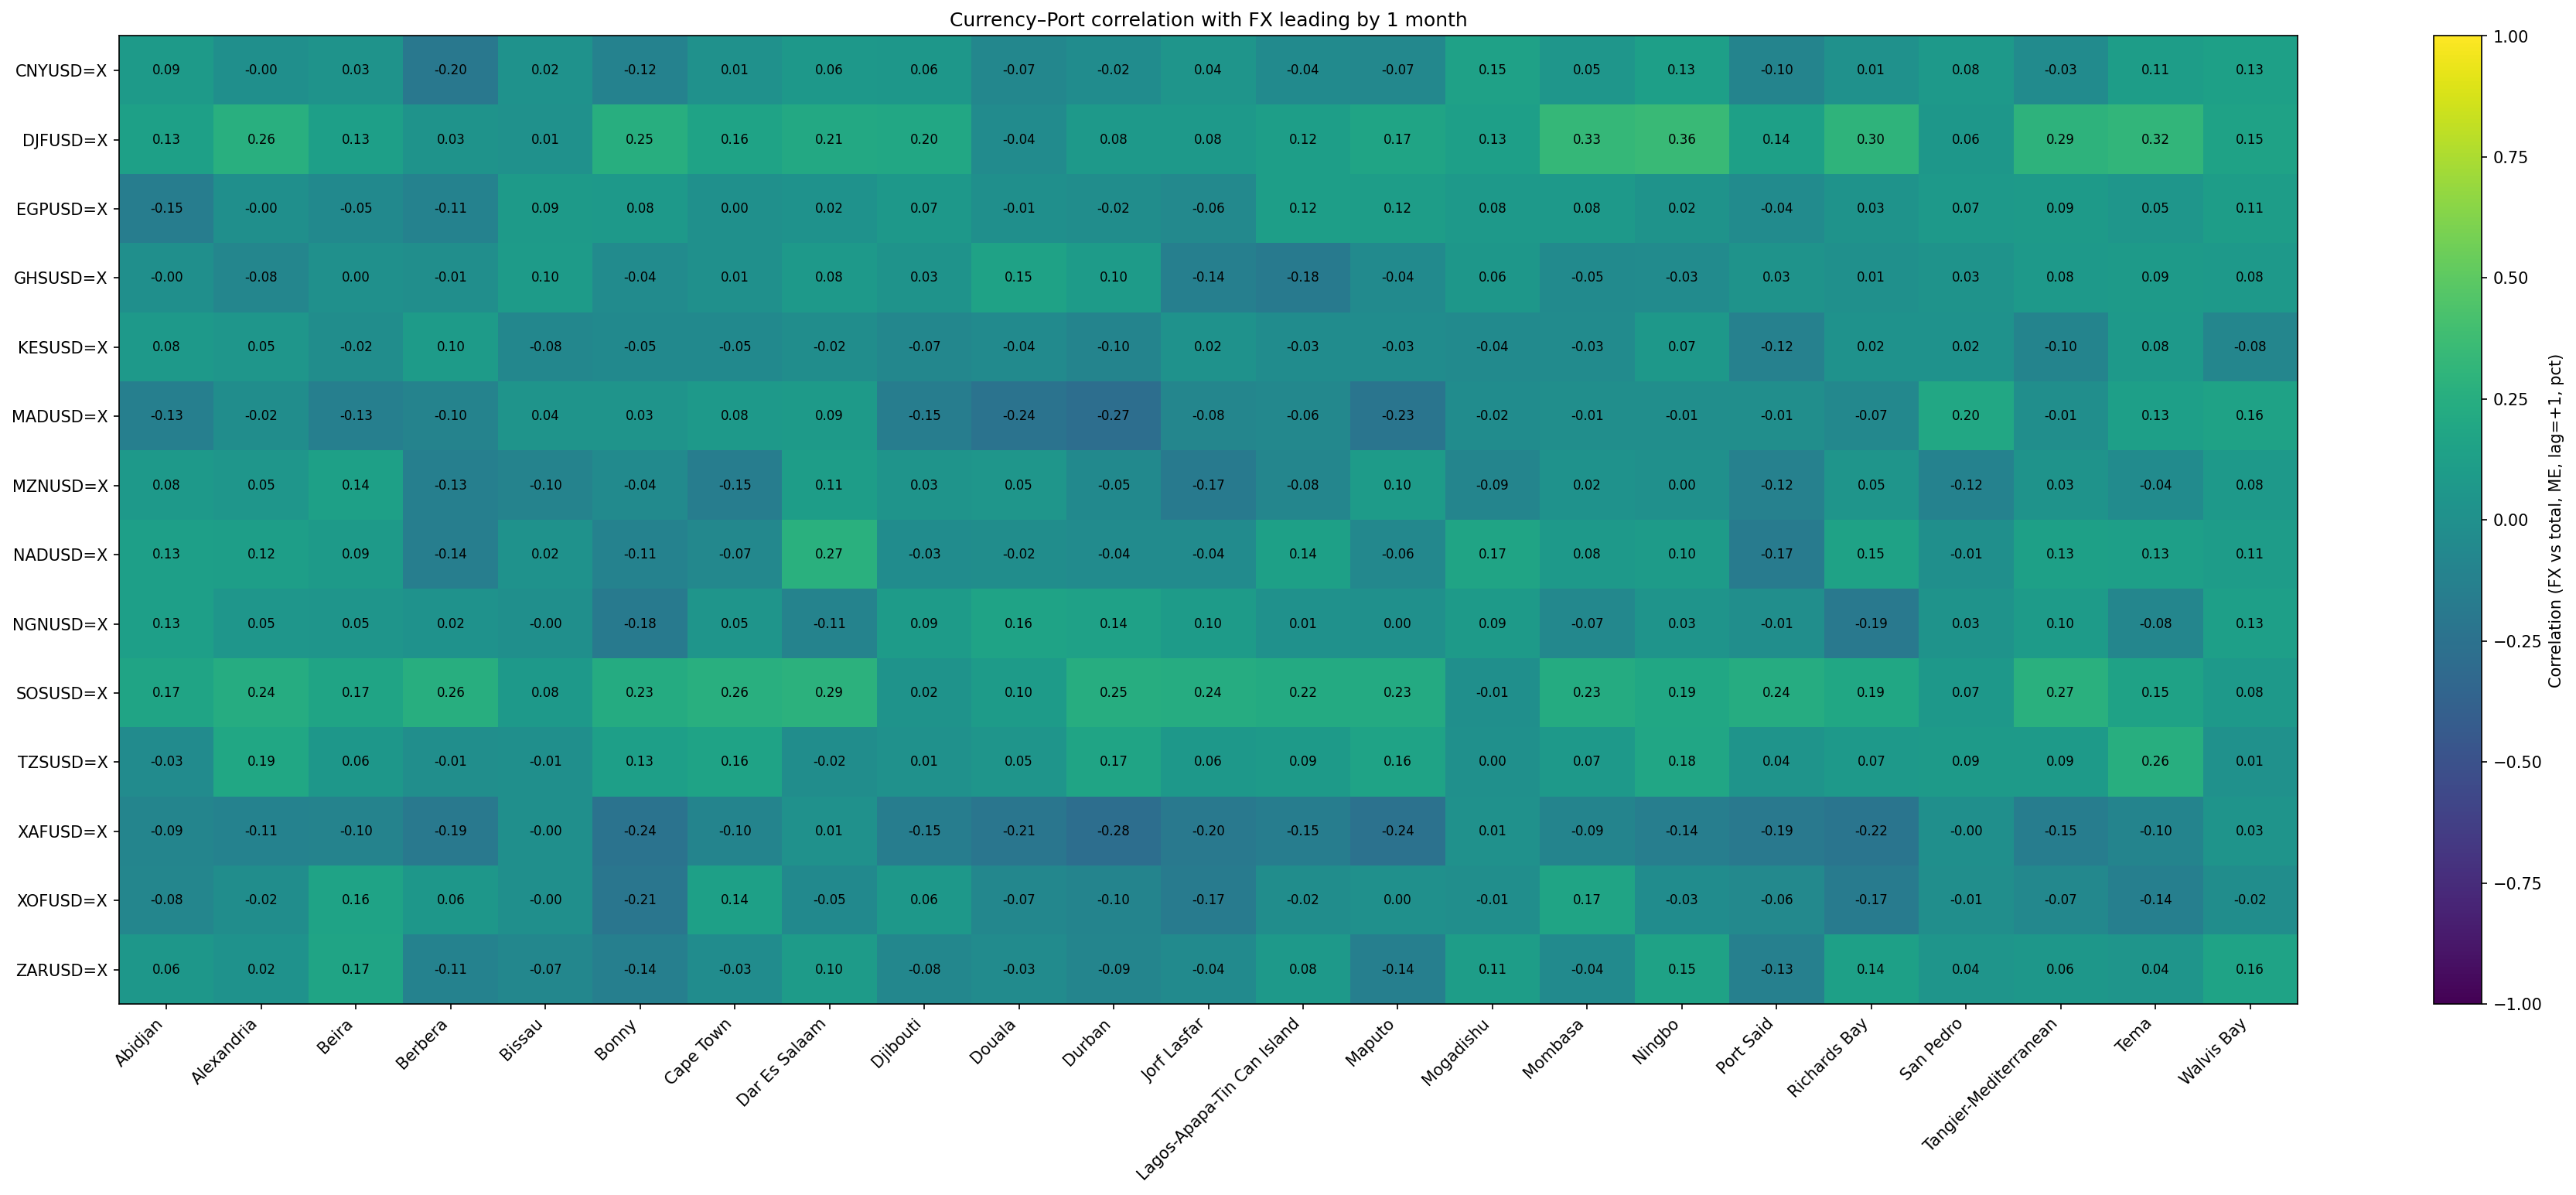

Abidjan  Alexandria  Beira  Berbera  Bissau  Bonny  Cape Town  \
CNYUSD=X    0.088      -0.003  0.026   -0.203   0.023 -0.116      0.011   
DJFUSD=X    0.134       0.262  0.131    0.031   0.008  0.252      0.161   
EGPUSD=X   -0.149      -0.002 -0.048   -0.113   0.089  0.083      0.004   
GHSUSD=X   -0.000      -0.083  0.003   -0.008   0.095 -0.039      0.007   
KESUSD=X    0.080       0.053 -0.021    0.099  -0.078 -0.054     -0.052   
MADUSD=X   -0.134      -0.020 -0.134   -0.103   0.035  0.032      0.079   
MZNUSD=X    0.081       0.054  0.140   -0.134  -0.104 -0.042     -0.149   
NADUSD=X    0.127       0.119  0.090   -0.143   0.019 -0.114     -0.068   
NGNUSD=X    0.129       0.051  0.046    0.016  -0.002 -0.176      0.045   
SOSUSD=X    0.170       0.235  0.168    0.255   0.075  0.233      0.263   
TZSUSD=X   -0.035       0.189  0.059   -0.013  -0.007  0.129      0.159   
XAFUSD=X   -0.087      -0.113 -0.105   -0.194  -0.001 -0.242     -0.099   
XOFUSD=X   -0.079      -0.021  0.157    0.055  -0.001 -0.214      0.137   
ZARUSD=X    0.062       0.016  0.169   -0.113  -0.073 -0.135     -0.025   

          Dar Es Salaam  Djibouti  Douala  ...  Maputo  Mogadishu  Mombasa  \
CNYUSD=X          0.064     0.055  -0.073  ...  -0.066      0.148    0.047   
DJFUSD=X          0.209     0.201  -0.037  ...   0.166      0.128    0.334   
EGPUSD=X          0.018     0.068  -0.006  ...   0.117      0.079    0.085   
GHSUSD=X          0.084     0.027   0.152  ...  -0.043      0.062   -0.046   
KESUSD=X         -0.019    -0.073  -0.045  ...  -0.029     -0.042   -0.033   
MADUSD=X          0.092    -0.151  -0.239  ...  -0.226     -0.025   -0.010   
MZNUSD=X          0.112     0.033   0.051  ...   0.100     -0.090    0.020   
NADUSD=X          0.268    -0.027  -0.022  ...  -0.063      0.168    0.084   
NGNUSD=X         -0.107     0.094   0.159  ...   0.004      0.087   -0.065   
SOSUSD=X          0.285     0.024   0.099  ...   0.225     -0.006    0.230   
TZSUSD=X         -0.018     0.011   0.047  ...   0.156      0.003    0.071   
XAFUSD=X          0.012    -0.152  -0.214  ...  -0.244      0.010   -0.094   
XOFUSD=X         -0.047     0.063  -0.073  ...   0.004     -0.012    0.166   
ZARUSD=X          0.097    -0.077  -0.032  ...  -0.139      0.110   -0.040   

          Ningbo  Port Said  Richards Bay  San Pedro  Tangier-Mediterranean  \
CNYUSD=X   0.126     -0.101         0.008      0.078                 -0.031   
DJFUSD=X   0.356      0.140         0.299      0.061                  0.293   
EGPUSD=X   0.024     -0.038         0.030      0.072                  0.092   
GHSUSD=X  -0.033      0.028         0.006      0.030                  0.078   
KESUSD=X   0.070     -0.120         0.023      0.020                 -0.101   
MADUSD=X  -0.014     -0.012        -0.068      0.199                 -0.013   
MZNUSD=X   0.005     -0.121         0.046     -0.116                  0.030   
NADUSD=X   0.101     -0.165         0.153     -0.008                  0.134   
NGNUSD=X   0.034     -0.014        -0.194      0.026                  0.101   
SOSUSD=X   0.189      0.238         0.194      0.070                  0.267   
TZSUSD=X   0.182      0.035         0.071      0.093                  0.087   
XAFUSD=X  -0.142     -0.190        -0.221     -0.000                 -0.151   
XOFUSD=X  -0.029     -0.060        -0.170     -0.011                 -0.065   
ZARUSD=X   0.152     -0.125         0.136      0.044                  0.059   

           Tema  Walvis Bay  
CNYUSD=X  0.111       0.134  
DJFUSD=X  0.319       0.149  
EGPUSD=X  0.050       0.114  
GHSUSD=X  0.089       0.079  
KESUSD=X  0.079      -0.083  
MADUSD=X  0.131       0.156  
MZNUSD=X -0.038       0.079  
NADUSD=X  0.128       0.105  
NGNUSD=X -0.083       0.126  
SOSUSD=X  0.154       0.085  
TZSUSD=X  0.255       0.010  
XAFUSD=X -0.095       0.034  
XOFUSD=X -0.138      -0.019  
ZARUSD=X  0.041       0.158  

[14 rows x 23 columns]

In [40]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ---- settings ----
FREQ = "ME"             # month-end
CHANGE = "pct"      # "pct", "diff", "logret", or "level"
FX_AGG = "last"        # month-end FX; use "mean" if preferred
FX_COL_FINDER = lambda cols: [c for c in cols if isinstance(c, str) and c.endswith("=X")]

# pdc: dict {city: cleaned_df with 'date','import','export', and one FX column like 'ZARUSD=X'}

# 1) build monthly totals per port + monthly FX per currency
per_port_total, per_currency_fx = {}, {}
for city, df in pdc.items():
    df = df.copy()
    per_port_total[city] = (
        df.assign(total=df["import"].astype(float) + df["export"].astype(float))
          .set_index("date")["total"]
          .resample(FREQ).sum()
    )
    for fx_col in FX_COL_FINDER(df.columns):
        fx_m = df.set_index("date")[fx_col].resample(FREQ).agg(FX_AGG)
        if fx_col not in per_currency_fx or fx_m.size > per_currency_fx[fx_col].size:
            per_currency_fx[fx_col] = fx_m

cities     = sorted(per_port_total.keys())
currencies = sorted(per_currency_fx.keys())

def transform(s, how):
    s = s.sort_index().astype(float)
    if how == "level": out = s
    elif how == "diff": out = s.diff()
    elif how == "pct": out = s.pct_change()
    elif how == "logret": out = np.log(s).diff()
    else: raise ValueError("CHANGE must be 'level','diff','pct','logret'")
    return out

# 2) fixed lag=+1 month: FX leads volume by 1 month (shift FX forward)
corr_mat = pd.DataFrame(index=currencies, columns=cities, dtype=float)

for city in cities:
    total_t = transform(per_port_total[city], CHANGE)
    for pair in currencies:
        fx_t = transform(per_currency_fx[pair], CHANGE).shift(6)  # <-- the lag
        df_xy = pd.concat([total_t.rename("tot"), fx_t.rename("fx")], axis=1).dropna()
        corr_mat.loc[pair, city] = df_xy["tot"].corr(df_xy["fx"]) if len(df_xy) >= 6 else np.nan

# 3) visualize
fig, ax = plt.subplots(figsize=(0.9*len(cities)+4, 0.6*len(currencies)+2), dpi=150)
im = ax.imshow(corr_mat.values, vmin=-1, vmax=1, aspect="auto", cmap="viridis")
ax.set_xticks(range(len(cities)));  ax.set_xticklabels(cities, rotation=45, ha="right")
ax.set_yticks(range(len(currencies))); ax.set_yticklabels(currencies)
fig.colorbar(im, ax=ax).set_label(f"Correlation (FX vs total, {FREQ}, lag=+1, {CHANGE})")
ax.set_title("Currency–Port correlation with FX leading by 1 month")

# optional annotations
for i in range(len(currencies)):
    for j in range(len(cities)):
        v = corr_mat.iat[i, j]
        if pd.notna(v): ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout(); plt.show()

# table if you want to inspect
corr_mat.round(3)


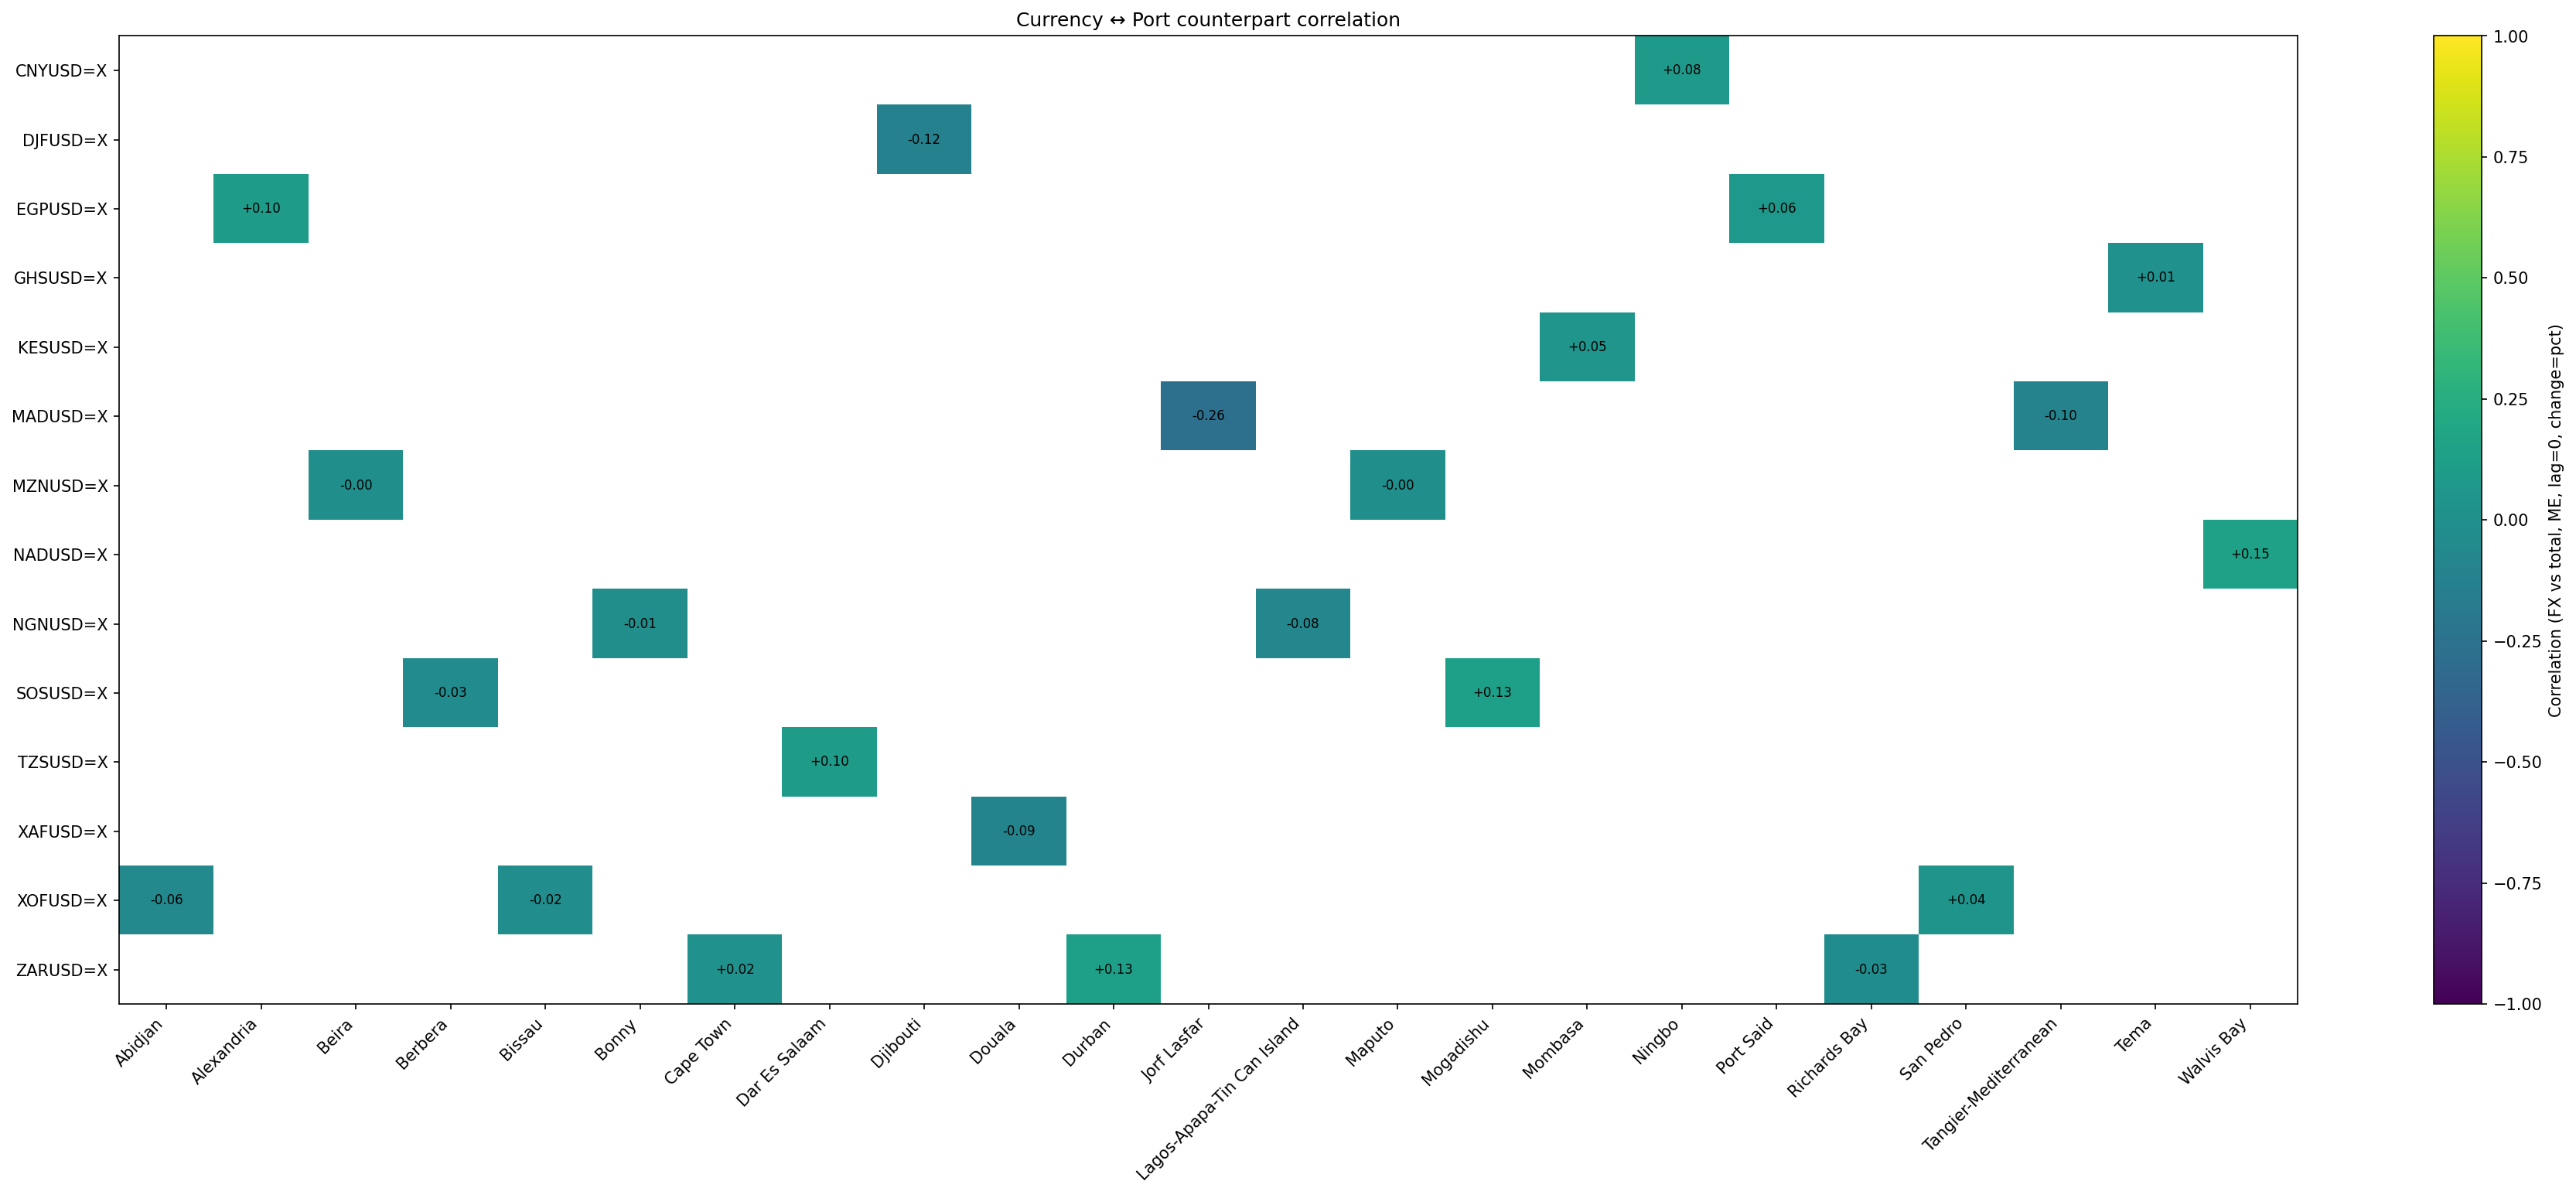

In [42]:


# ==== knobs ====
FREQ    = "ME"         # "M" month-end, or "W-FRI" for weekly
FX_AGG  = "last"      # FX period value: "last" or "mean"
CHANGE  = "pct"    # "level", "diff", "pct", or "logret"
LAG     = 0           # +1 => FX leads volume by 1 period
FX_COL_FINDER = lambda cols: [c for c in cols if isinstance(c, str) and c.endswith("=X")]

# pdc: your dict {city: cleaned_df} with columns: 'date','import','export', and one FX col like 'ZARUSD=X'

# ---- 1) build monthly series and the port→currency map ----
per_port_total = {}
per_port_fx    = {}
port_ccy       = {}

for city, df in pdc.items():
    # unwrap [df] if your dict stores lists
    if isinstance(df, list):
        if not df: 
            continue
        df = df[0]
    if not isinstance(df, pd.DataFrame):
        continue

    # find this port's FX column (assume exactly one)
    fx_cols = FX_COL_FINDER(df.columns)
    if not fx_cols:
        print(f"[WARN] No FX column found in {city}; skipping")
        continue
    fx_col = fx_cols[0]
    port_ccy[city] = fx_col

    # monthly totals (sum imports+exports) and FX (mean/last)
    tot_m = (
        df.assign(total=pd.to_numeric(df["import"], errors="coerce")
                         + pd.to_numeric(df["export"], errors="coerce"))
          .set_index("date")["total"]
          .resample(FREQ).sum()
    )
    fx_m = (
        df.set_index("date")[fx_col]
          .resample(FREQ)
          .agg(FX_AGG)
    )

    per_port_total[city] = tot_m
    per_port_fx[city]    = fx_m

cities     = sorted(per_port_total.keys())
currencies = sorted(set(port_ccy.values()))  # only currencies that actually appear

# ---- 2) transform helper (changes vs levels) ----
def transform(s, how):
    s = s.sort_index().astype(float)
    if   how == "level":  out = s
    elif how == "diff":   out = s.diff()
    elif how == "pct":    out = s.pct_change()
    elif how == "logret": out = np.log(s).diff()
    else: raise ValueError("CHANGE must be one of: level, diff, pct, logret")
    return out

# ---- 3) corr matrix with only counterpart cells filled ----
corr_mat = pd.DataFrame(np.nan, index=currencies, columns=cities, dtype=float)

for city in cities:
    ccy = port_ccy[city]                       # the city's own currency pair
    tot_t = transform(per_port_total[city], CHANGE)
    fx_t  = transform(per_port_fx[city], CHANGE).shift(LAG)  # LAG>0: FX leads

    df_xy = pd.concat([tot_t.rename("tot"), fx_t.rename("fx")], axis=1).dropna()
    corr  = df_xy["tot"].corr(df_xy["fx"]) if len(df_xy) >= 6 else np.nan
    corr_mat.loc[ccy, city] = corr

# ---- 4) plot: show only those counterpart squares ----
fig, ax = plt.subplots(figsize=(0.9*len(cities)+4, 0.6*len(currencies)+2), dpi=150)

# mask NaNs so non-counterpart cells appear blank
data   = corr_mat.values.astype(float)
masked = np.ma.masked_invalid(data)
cmap   = plt.cm.viridis.copy()
cmap.set_bad(color=(1,1,1,0))  # transparent for NaNs

im = ax.imshow(masked, vmin=-1, vmax=1, cmap=cmap, aspect="auto")
ax.set_xticks(range(len(cities)));     ax.set_xticklabels(cities, rotation=45, ha="right")
ax.set_yticks(range(len(currencies))); ax.set_yticklabels(currencies)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(f"Correlation (FX vs total, {FREQ}, lag={LAG}, change={CHANGE})")
ax.set_title("Currency ↔ Port counterpart correlation")

# annotate only the real cells
for i, ccy in enumerate(currencies):
    for j, city in enumerate(cities):
        v = corr_mat.iat[i, j]
        if pd.notna(v):
            ax.text(j, i, f"{v:+.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()



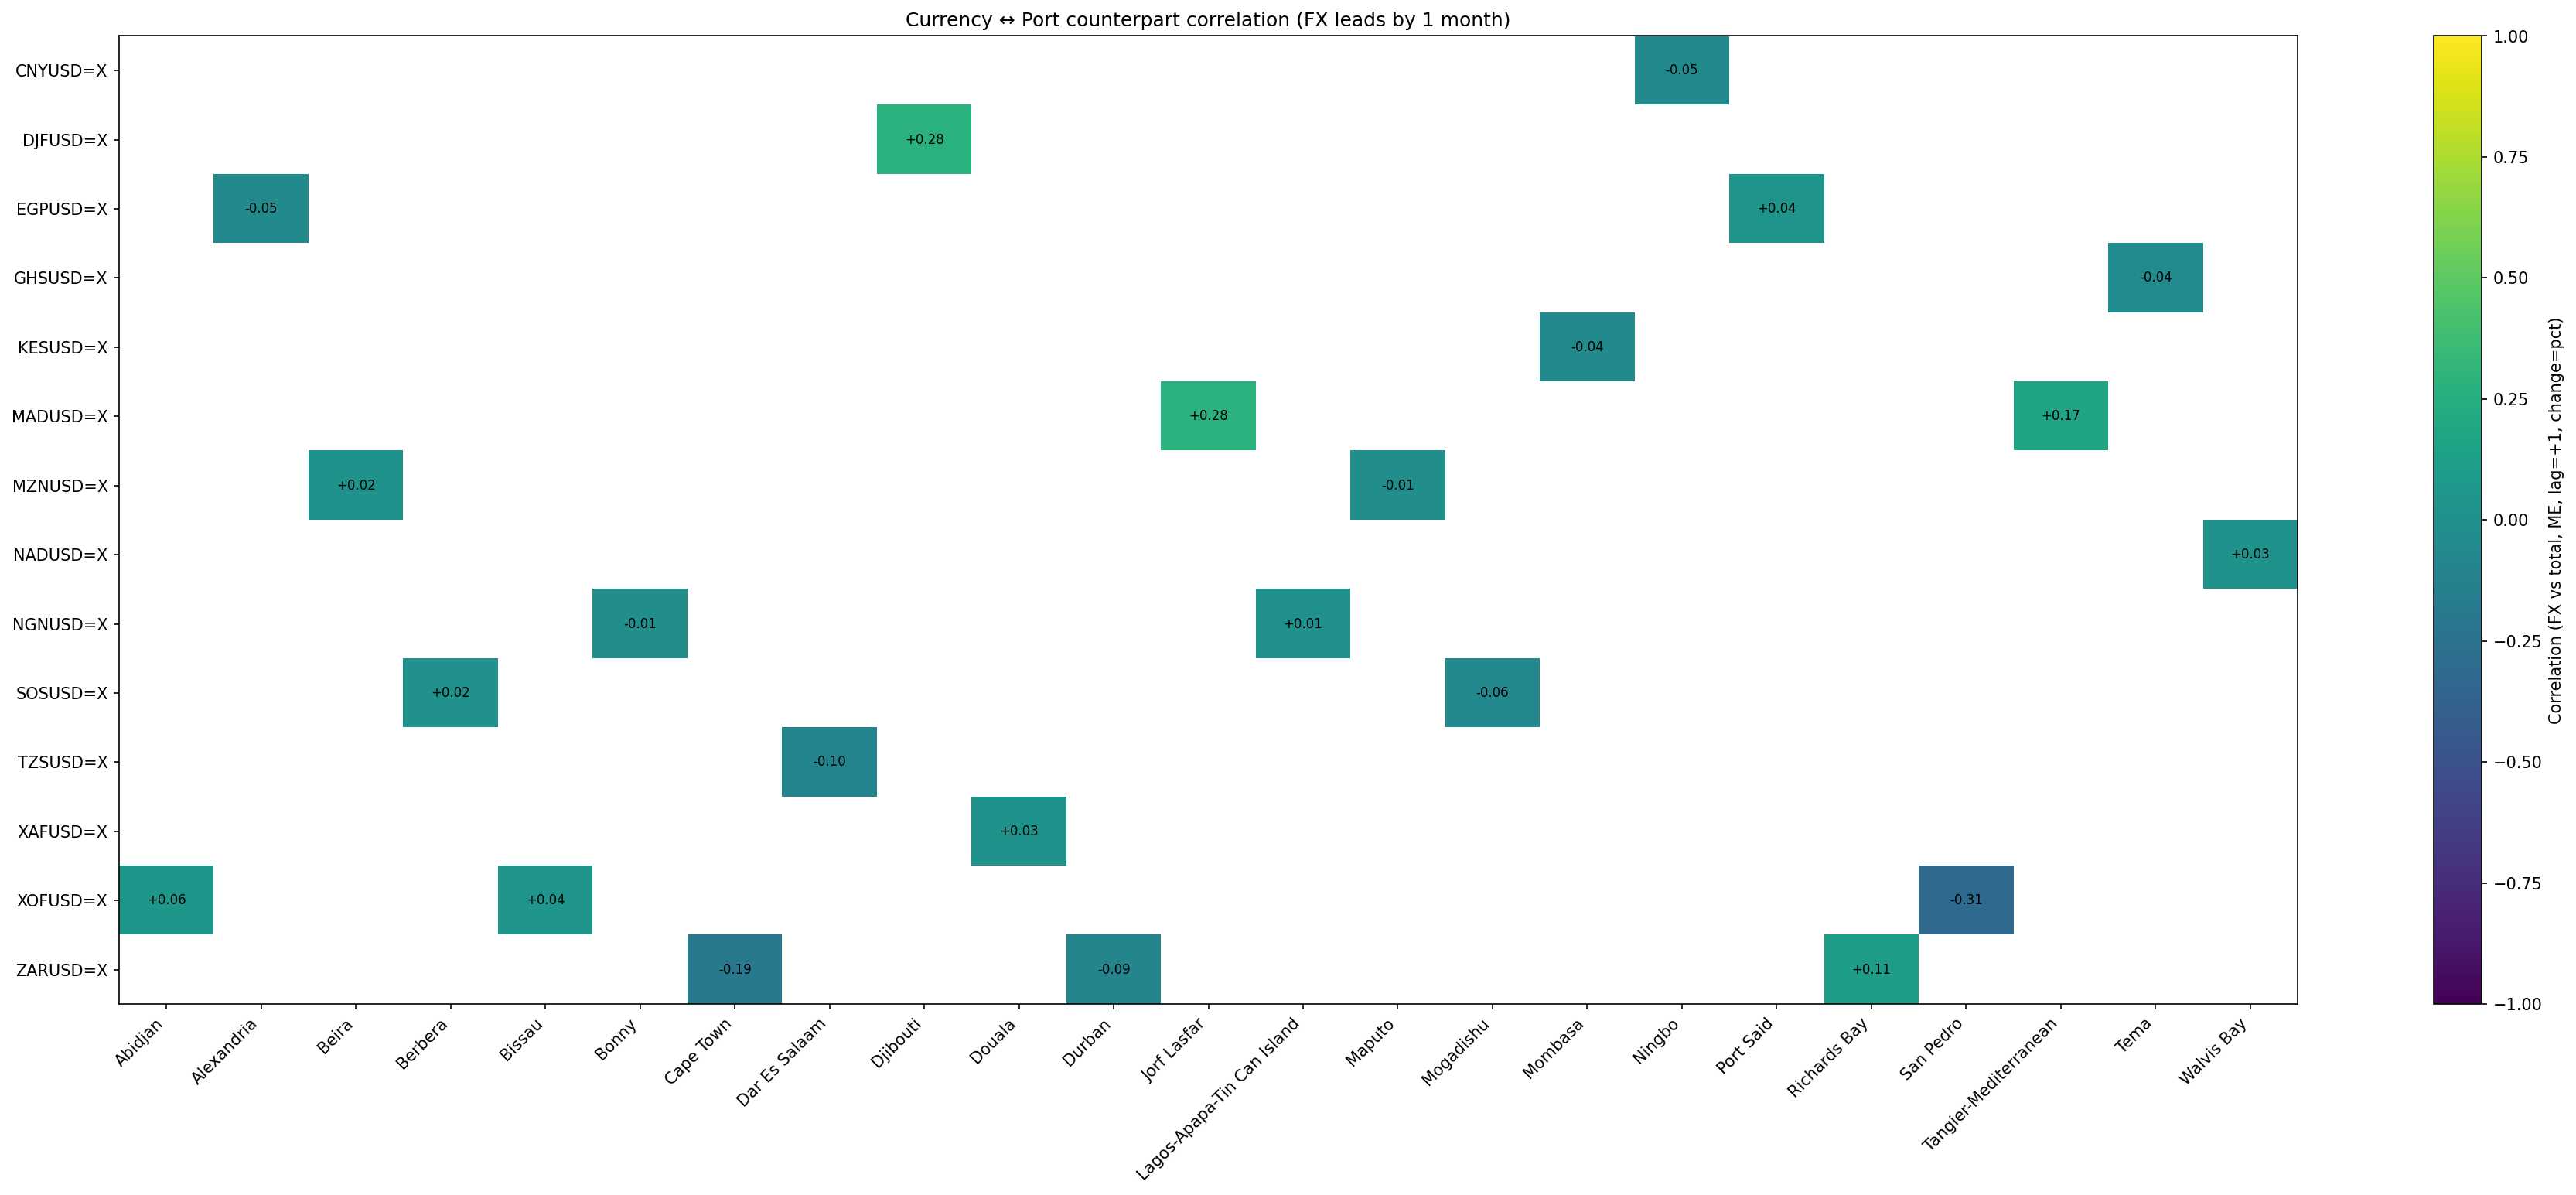

In [46]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# --- knobs ---
FREQ    = "ME"          # month-end
FX_AGG  = "last"       # month-end FX; use "mean" if you prefer
CHANGE  = "pct"     # "level", "diff", "pct", or "logret"
LAG     = 1            # <-- FX leads volumes by 1 month
FX_COL_FINDER = lambda cols: [c for c in cols if isinstance(c, str) and c.endswith("=X")]

# pdc: {city: cleaned_df} with columns: 'date','import','export', and one FX col like 'ZARUSD=X'

# 1) monthly series + port->currency map
per_port_total, per_port_fx, port_ccy = {}, {}, {}
for city, df in pdc.items():
    if isinstance(df, list):
        if not df: 
            continue
        df = df[0]
    if not isinstance(df, pd.DataFrame):
        continue

    fx_cols = FX_COL_FINDER(df.columns)
    if not fx_cols:
        continue
    fx_col = fx_cols[0]
    port_ccy[city] = fx_col

    tot_m = (df.assign(total=pd.to_numeric(df["import"], errors="coerce")
                               + pd.to_numeric(df["export"], errors="coerce"))
               .set_index("date")["total"]
               .resample(FREQ).sum())
    fx_m  = (df.set_index("date")[fx_col].resample(FREQ).agg(FX_AGG))

    per_port_total[city] = tot_m
    per_port_fx[city]    = fx_m

cities     = sorted(per_port_total.keys())
currencies = sorted(set(port_ccy.values()))

# 2) transform helper
def transform(s, how):
    s = s.sort_index().astype(float)
    if   how == "level":  return s
    if   how == "diff":   return s.diff()
    if   how == "pct":    return s.pct_change()
    if   how == "logret": return np.log(s).diff()
    raise ValueError("CHANGE must be one of: level, diff, pct, logret")

# 3) corr matrix with only counterpart cells, FX shifted by +1 month
corr_mat = pd.DataFrame(np.nan, index=currencies, columns=cities, dtype=float)
for city in cities:
    ccy   = port_ccy[city]
    tot_t = transform(per_port_total[city], CHANGE)
    fx_t  = transform(per_port_fx[city], CHANGE).shift(LAG)  # <-- fixed 1-month lead

    df_xy = pd.concat([tot_t.rename("tot"), fx_t.rename("fx")], axis=1).dropna()
    corr  = df_xy["tot"].corr(df_xy["fx"]) if len(df_xy) >= 6 else np.nan
    corr_mat.loc[ccy, city] = corr

# 4) plot (only counterpart squares visible)
fig, ax = plt.subplots(figsize=(0.9*len(cities)+4, 0.6*len(currencies)+2), dpi=150)
data   = corr_mat.values.astype(float)
masked = np.ma.masked_invalid(data)
cmap   = plt.cm.viridis.copy(); cmap.set_bad(color=(1,1,1,0))
im = ax.imshow(masked, vmin=-1, vmax=1, cmap=cmap, aspect="auto")

ax.set_xticks(range(len(cities)));     ax.set_xticklabels(cities, rotation=45, ha="right")
ax.set_yticks(range(len(currencies))); ax.set_yticklabels(currencies)
fig.colorbar(im, ax=ax).set_label(f"Correlation (FX vs total, {FREQ}, lag=+1, change={CHANGE})")
ax.set_title("Currency ↔ Port counterpart correlation (FX leads by 1 month)")

for i, ccy in enumerate(currencies):
    for j, city in enumerate(cities):
        v = corr_mat.iat[i, j]
        if pd.notna(v):
            ax.text(j, i, f"{v:+.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout(); plt.show()


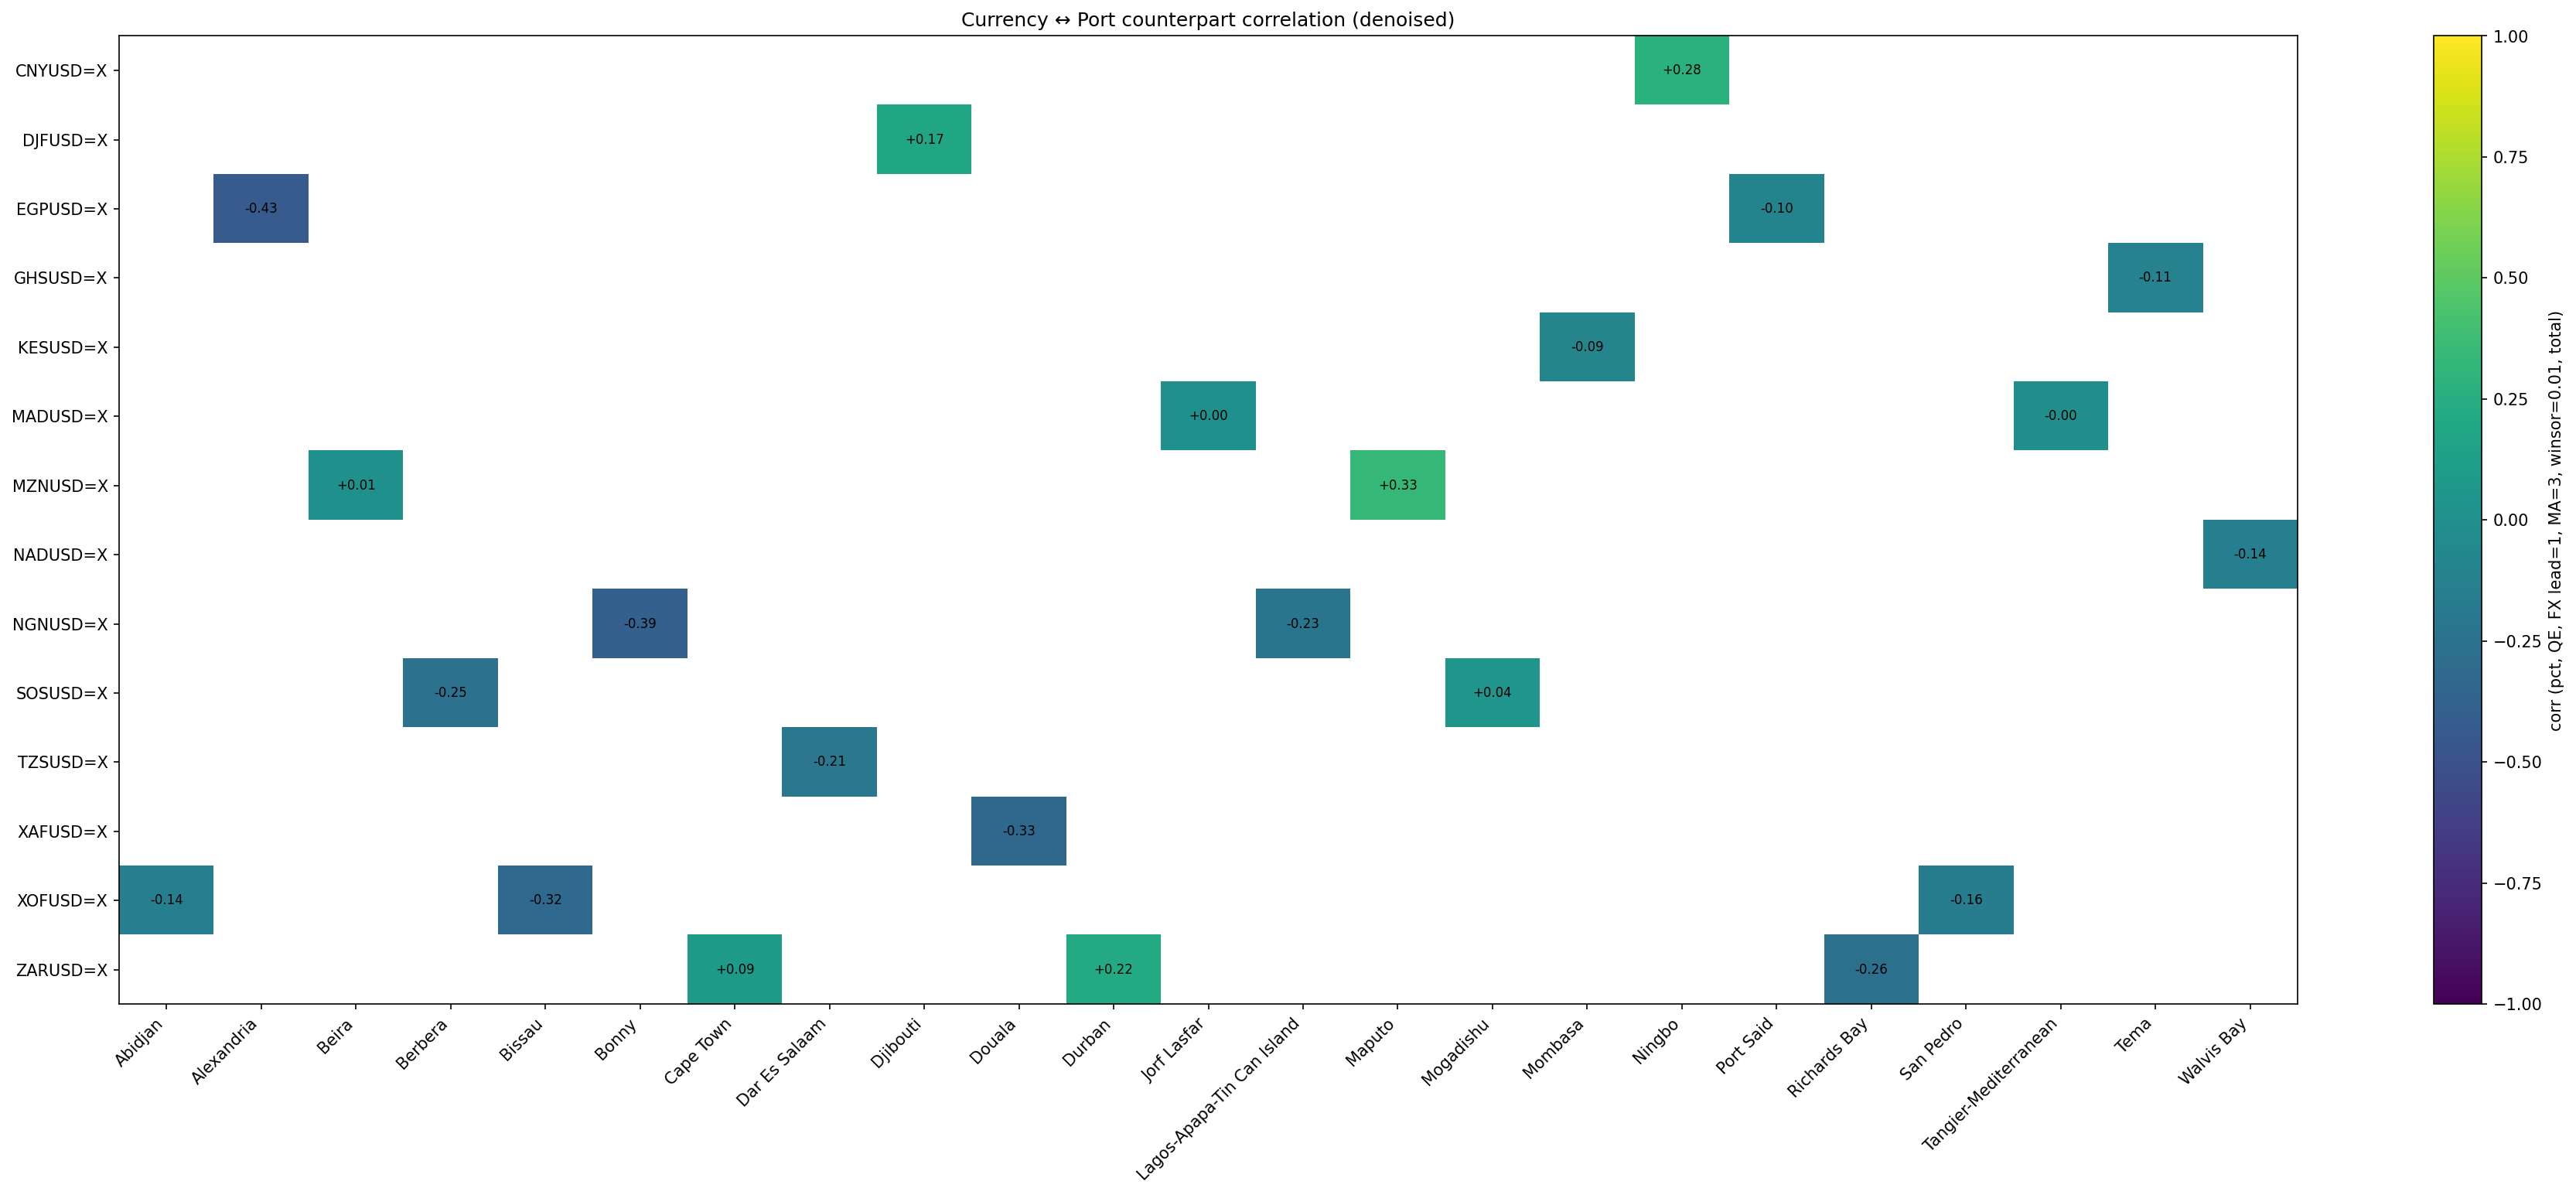

In [53]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# ===== knobs =====
FREQ      = "QE"        # "M" (month-end) or "W-FRI"
FX_AGG    = "mean"     # FX period value: "last" or "mean"
CHANGE    = "pct"   # "level","diff","pct","logret"  (recommend "logret" or "pct")
LAG       = 1          # FX leads volumes by 1 period
SMOOTH_K  = 3          # 0 = off, else rolling mean window (e.g., 3 months)
WINSOR_Q  = 0.01       # 0 = off, else clip extremes at [q,1-q]
USE_EXPORTS_ONLY = False  # focus mechanism: exports at export hubs

FX_COL_FINDER = lambda cols: [c for c in cols if isinstance(c, str) and c.endswith("=X")]

# pdc: your dict {city: df} with columns 'date','import','export' and one FX column like 'ZARUSD=X'

def _winsor(s, q):
    if not (0 < q < 0.5): return s
    lo, hi = s.quantile(q), s.quantile(1-q)
    return s.clip(lo, hi)

def _transform(s, how):
    s = s.sort_index().astype(float)
    if how == "level":  out = s
    elif how == "diff": out = s.diff()
    elif how == "pct":  out = s.pct_change()
    elif how == "logret": out = np.log(s).diff()
    else: raise ValueError("CHANGE must be one of: level,diff,pct,logret")
    return out

def _stl_deseasonalize(x, period):
    # returns residuals (x minus seasonal+trend)
    x = x.dropna()
    if len(x) < period*2: return x  # not enough data for STL; fall back
    res = STL(x, period=period, robust=True).fit()
    return (x - res.seasonal - res.trend).reindex_like(x)

# 1) build monthly series & map ports->ccy
per_port_total, per_port_fx, port_ccy = {}, {}, {}
for city, df in pdc.items():
    if isinstance(df, list):
        if not df: continue
        df = df[0]
    if not isinstance(df, pd.DataFrame): continue

    fx_cols = FX_COL_FINDER(df.columns)
    if not fx_cols: 
        print(f"[WARN] {city}: no FX col found"); 
        continue
    fx_col = fx_cols[0]
    port_ccy[city] = fx_col

    # choose metric
    metric = "export" if USE_EXPORTS_ONLY else None
    if metric is None:
        total = (pd.to_numeric(df["import"], errors="coerce") +
                 pd.to_numeric(df["export"], errors="coerce"))
    else:
        total = pd.to_numeric(df[metric], errors="coerce")

    tot_m = (df.assign(total=total)
               .set_index("date")["total"]
               .resample(FREQ).sum())

    fx_m  = (df.set_index("date")[fx_col]
               .resample(FREQ)
               .agg(FX_AGG))

    per_port_total[city] = tot_m
    per_port_fx[city]    = fx_m

cities     = sorted(per_port_total.keys())
currencies = sorted(set(port_ccy.values()))
corr_mat   = pd.DataFrame(np.nan, index=currencies, columns=cities, dtype=float)

# 2) compute correlation after: transform -> smooth -> winsorize -> deseasonalize -> align -> lag
period = 12 if FREQ == "M" else 52  # STL season length

for city in cities:
    ccy = port_ccy[city]
    vol = per_port_total[city]
    fx  = per_port_fx[city]

    # transform
    vol_t = _transform(vol, CHANGE)
    fx_t  = _transform(fx, CHANGE)

    # smoothing
    if SMOOTH_K and SMOOTH_K > 1:
        vol_t = vol_t.rolling(SMOOTH_K, min_periods=SMOOTH_K).mean()
        fx_t  = fx_t.rolling(SMOOTH_K, min_periods=SMOOTH_K).mean()

    # winsorize
    vol_t = _winsor(vol_t, WINSOR_Q)
    fx_t  = _winsor(fx_t,  WINSOR_Q)

    # deseasonalize (residuals)
    vol_t = _stl_deseasonalize(vol_t, period) if CHANGE in ("level","diff") else vol_t
    fx_t  = _stl_deseasonalize(fx_t,  period)

    # apply lag (FX leads)
    fx_t = fx_t.shift(LAG)

    # align & correlate
    pair = pd.concat([vol_t.rename("vol"), fx_t.rename("fx")], axis=1).dropna()
    corr = pair["vol"].corr(pair["fx"]) if len(pair) >= 12 else np.nan
    corr_mat.loc[ccy, city] = corr

# 3) plot counterpart-only heatmap (blank elsewhere)
fig, ax = plt.subplots(figsize=(0.9*len(cities)+4, 0.6*len(currencies)+2), dpi=150)
masked = np.ma.masked_invalid(corr_mat.values.astype(float))
cmap = plt.cm.viridis.copy(); cmap.set_bad(color=(1,1,1,0))
im = ax.imshow(masked, vmin=-1, vmax=1, cmap=cmap, aspect="auto")
ax.set_xticks(range(len(cities)));  ax.set_xticklabels(cities, rotation=45, ha="right")
ax.set_yticks(range(len(currencies))); ax.set_yticklabels(currencies)
fig.colorbar(im, ax=ax).set_label(f"corr ({CHANGE}, {FREQ}, FX lead={LAG}, MA={SMOOTH_K}, winsor={WINSOR_Q}, {'exports' if USE_EXPORTS_ONLY else 'total'})")
ax.set_title("Currency ↔ Port counterpart correlation (denoised)")
for i, ccy in enumerate(currencies):
    for j, city in enumerate(cities):
        v = corr_mat.iat[i, j]
        if pd.notna(v): ax.text(j, i, f"{v:+.2f}", ha="center", va="center", fontsize=8)
plt.tight_layout(); plt.show()


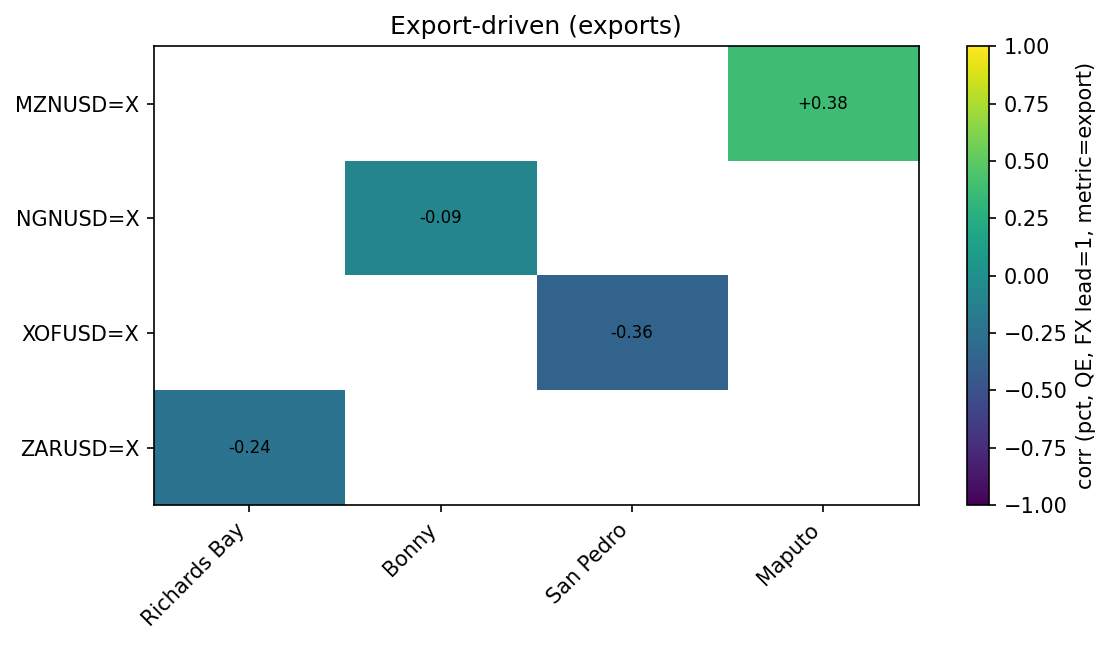

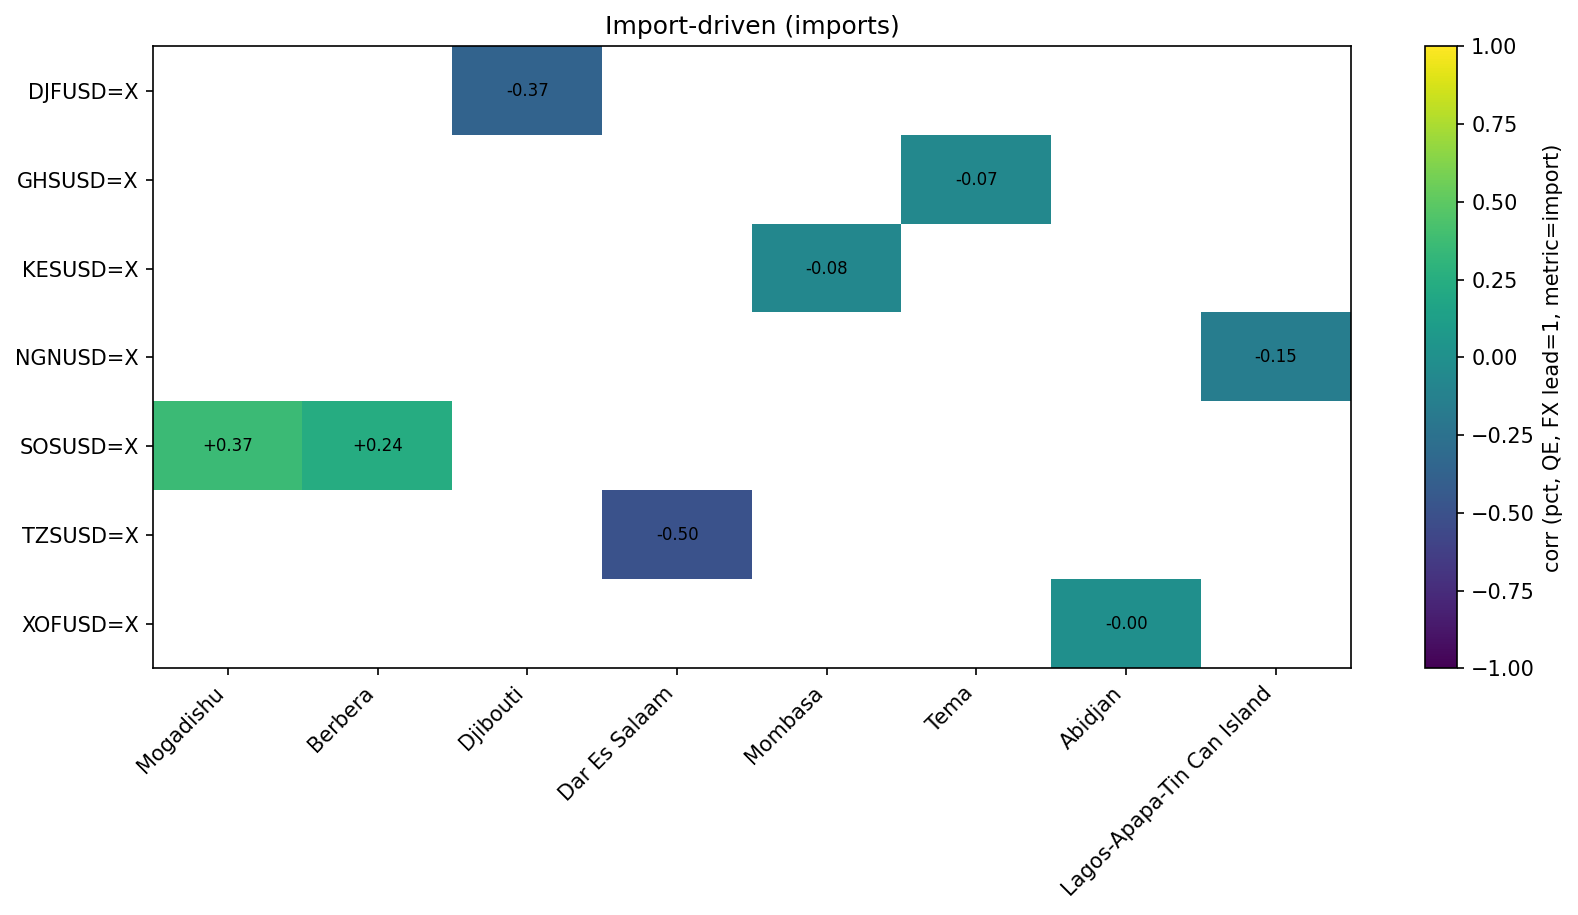

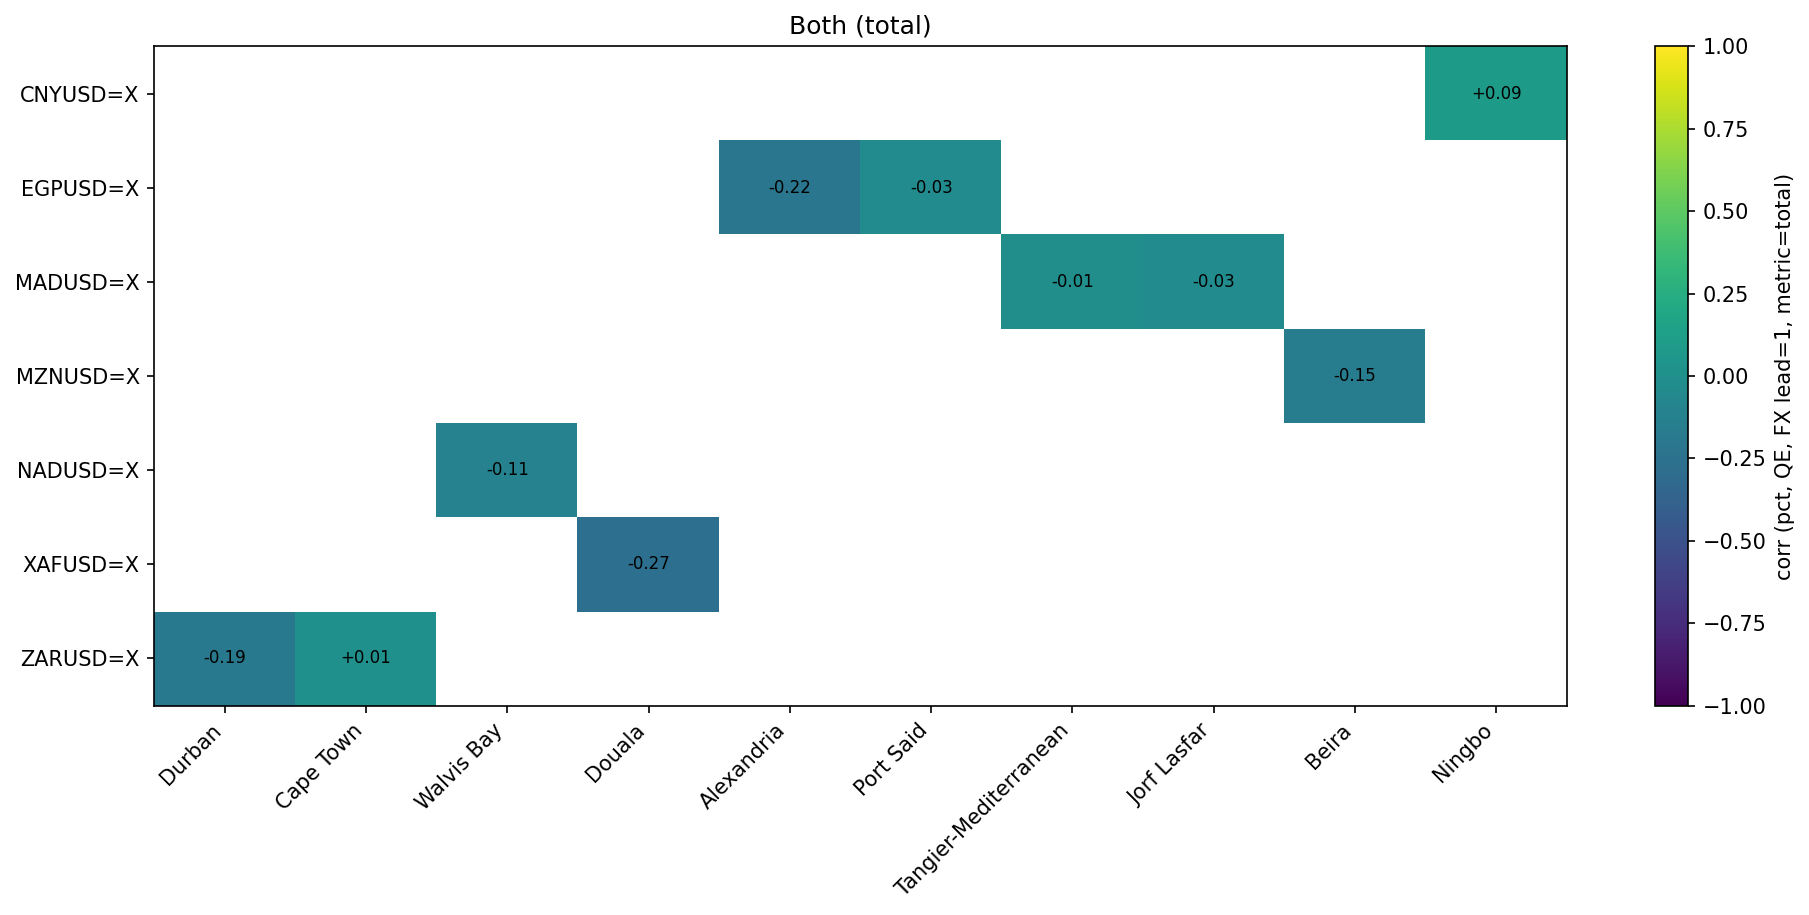

In [55]:
# Something to keep in mind regarding currencies and pegs
# DJF pegged to USD, XOF+XAF+MAD pegged to EURO, CNY is a managed float, NAD pegged to ZAR
# The only actual floats are ZAR, TZS, KES, MZN (up until 2021), EGP (goes through regime changes), GHS, 



import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ===================== knobs =====================
FREQ    = "QE"          # monthly
FX_AGG  = "mean"       # month-end FX ("mean" also ok)
CHANGE  = "pct"     # "level", "diff", "pct", or "logret"
LAG     = 1            # FX leads volumes by 1 month
FX_COL_FINDER = lambda cols: [c for c in cols if isinstance(c, str) and c.endswith("=X")]
# =================================================

# ---- 0) your buckets (edit as you like) ----
export_driven = [
    "Richards Bay", "Bonny", "San Pedro", "Maputo"
]
import_driven = [
    "Mogadishu", "Berbera", "Djibouti", "Dar Es Salaam",
    "Mombasa", "Tema", "Abidjan", "Lagos-Apapa-Tin Can Island"
]
both_driven = [
    "Durban", "Cape Town", "Walvis Bay", "Douala",
    "Alexandria", "Port Said", "Tangier-Mediterranean",
    "Jorf Lasfar", "Beira", "Ningbo"
]

buckets = {
    "Export-driven (exports)": (export_driven, "export"),
    "Import-driven (imports)": (import_driven, "import"),
    "Both (total)":            (both_driven,  "total"),
}

# ---- helper: transform choice ----
def _transform(s, how):
    s = s.sort_index().astype(float)
    if   how == "level":  return s
    if   how == "diff":   return s.diff()
    if   how == "pct":    return s.pct_change()
    if   how == "logret": return np.log(s).diff()
    raise ValueError("CHANGE must be one of: level, diff, pct, logret")

# ---- 1) build monthly port series + port→currency map ----
def build_series_for_ports(pdc, cities, metric):
    """
    metric: 'import', 'export', or 'total'
    returns: per_port_metric (city->Series), per_port_fx (city->FX Series), port_ccy (city->pair)
    """
    per_port_metric, per_port_fx, port_ccy = {}, {}, {}
    for city in cities:
        df = pdc.get(city)
        if df is None: continue
        if isinstance(df, list):
            if not df: continue
            df = df[0]
        if not isinstance(df, pd.DataFrame): continue

        # find currency column
        fx_cols = FX_COL_FINDER(df.columns)
        if not fx_cols: 
            print(f"[WARN] {city}: no FX column found; skipping")
            continue
        fx_col = fx_cols[0]
        port_ccy[city] = fx_col

        # choose the metric series
        if metric == "total":
            metric_series = (pd.to_numeric(df["import"], errors="coerce") +
                             pd.to_numeric(df["export"], errors="coerce"))
        else:
            metric_series = pd.to_numeric(df[metric], errors="coerce")

        y = (df.assign(y=metric_series)
                .set_index("date")["y"]
                .resample(FREQ).sum())

        fx = (df.set_index("date")[fx_col]
                .resample(FREQ)
                .agg(FX_AGG))

        per_port_metric[city] = y
        per_port_fx[city] = fx
    return per_port_metric, per_port_fx, port_ccy

# ---- 2) compute counterpart-only corr matrix + plot ----
def plot_counterpart_heatmap(title, pdc, cities, metric):
    per_port_metric, per_port_fx, port_ccy = build_series_for_ports(pdc, cities, metric)
    cities = [c for c in cities if c in per_port_metric]  # keep only those we have

    currencies = sorted(set(port_ccy[c] for c in cities))
    corr_mat = pd.DataFrame(np.nan, index=currencies, columns=cities, dtype=float)

    for city in cities:
        pair = port_ccy[city]
        vol  = _transform(per_port_metric[city], CHANGE)
        fx   = _transform(per_port_fx[city], CHANGE).shift(LAG)  # FX leads

        df_xy = pd.concat([vol.rename("vol"), fx.rename("fx")], axis=1).dropna()
        corr  = df_xy["vol"].corr(df_xy["fx"]) if len(df_xy) >= 6 else np.nan
        corr_mat.loc[pair, city] = corr

    # plot counterpart-only cells (others blank)
    fig, ax = plt.subplots(figsize=(0.9*len(cities)+4, 0.6*len(currencies)+2), dpi=150)
    data   = corr_mat.values.astype(float)
    masked = np.ma.masked_invalid(data)
    cmap   = plt.cm.viridis.copy(); cmap.set_bad(color=(1,1,1,0))
    im = ax.imshow(masked, vmin=-1, vmax=1, cmap=cmap, aspect="auto")

    ax.set_xticks(range(len(cities)));     ax.set_xticklabels(cities, rotation=45, ha="right")
    ax.set_yticks(range(len(currencies))); ax.set_yticklabels(currencies)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(f"corr ({CHANGE}, {FREQ}, FX lead={LAG}, metric={metric})")
    ax.set_title(title)

    # annotate only filled cells
    for i, ccy in enumerate(currencies):
        for j, city in enumerate(cities):
            v = corr_mat.iat[i, j]
            if pd.notna(v):
                ax.text(j, i, f"{v:+.2f}", ha="center", va="center", fontsize=8)

    plt.tight_layout(); plt.show()
    return corr_mat

# ---- 3) run all three heatmaps ----
results = {}
for title, (cities, metric) in buckets.items():
    results[title] = plot_counterpart_heatmap(title, pdc, cities, metric)

# results is a dict of the three correlation tables if you want to inspect them


/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Abidjan  Alexandria  Beira  Berbera  Bissau  \
Abidjan                        1.00        0.67   0.50     0.17    0.22   
Alexandria                     0.67        1.00   0.59     0.29    0.01   
Beira                          0.50        0.59   1.00     0.21    0.05   
Berbera                        0.17        0.29   0.21     1.00   -0.09   
Bissau                         0.22        0.01   0.05    -0.09    1.00   
Bonny                         -0.10       -0.08   0.04    -0.20    0.03   
Cape Town                      0.57        0.50   0.50     0.40    0.16   
Dar Es Salaam                  0.73        0.67   0.58     0.05    0.17   
Djibouti                       0.62        0.70   0.59     0.30    0.04   
Douala                         0.52        0.50   0.42     0.13    0.07   
Durban                         0.71        0.76   0.68     0.20    0.07   
Jorf Lasfar                    0.77        0.73   0.58     0.28    0.11   
Lagos-Apapa-Tin Can Island     0.70        0.70   0.58     0.15    0.06   
Maputo                         0.60        0.64   0.42     0.07    0.06   
Mogadishu                      0.12        0.19   0.15     0.14   -0.19   
Mombasa                        0.69        0.67   0.57     0.22    0.09   
Ningbo                         0.74        0.72   0.68     0.26    0.11   
Port Said                      0.42        0.53   0.41     0.24    0.14   
Richards Bay                   0.70        0.76   0.60     0.21   -0.05   
San Pedro                      0.30        0.18   0.21     0.06   -0.05   
Tangier-Mediterranean          0.75        0.69   0.64     0.13    0.11   
Tema                           0.65        0.61   0.63     0.19    0.08   
Walvis Bay                     0.49        0.41   0.33     0.02    0.12   

                            Bonny  Cape Town  Dar Es Salaam  Djibouti  Douala  \
Abidjan                     -0.10       0.57           0.73      0.62    0.52   
Alexandria                  -0.08       0.50           0.67      0.70    0.50   
Beira                        0.04       0.50           0.58      0.59    0.42   
Berbera                     -0.20       0.40           0.05      0.30    0.13   
Bissau                       0.03       0.16           0.17      0.04    0.07   
Bonny                        1.00       0.09           0.29     -0.02    0.14   
Cape Town                    0.09       1.00           0.48      0.46    0.39   
Dar Es Salaam                0.29       0.48           1.00      0.65    0.52   
Djibouti                    -0.02       0.46           0.65      1.00    0.41   
Douala                       0.14       0.39           0.52      0.41    1.00   
Durban                      -0.10       0.60           0.69      0.67    0.61   
Jorf Lasfar                 -0.07       0.56           0.74      0.69    0.62   
Lagos-Apapa-Tin Can Island   0.20       0.44           0.77      0.65    0.63   
Maputo                       0.18       0.46           0.62      0.61    0.51   
Mogadishu                   -0.07       0.03           0.21      0.26    0.19   
Mombasa                      0.01       0.48           0.70      0.75    0.48   
Ningbo                      -0.13       0.58           0.68      0.67    0.61   
Port Said                    0.03       0.38           0.33      0.36    0.34   
Richards Bay                -0.01       0.56           0.75      0.69    0.61   
San Pedro                    0.16       0.28           0.41      0.14    0.41   
Tangier-Mediterranean        0.06       0.60           0.81      0.69    0.66   
Tema                         0.25       0.54           0.63      0.60    0.50   
Walvis Bay                  -0.38       0.27           0.44      0.50    0.21   

                            ...  Maputo  Mogadishu  Mombasa  Ningbo  \
Abidjan                     ...    0.60       0.12     0.69    0.74   
Alexandria                  ...    0.64       0.19     0.67    0.72   
Beira                       ...    0.42       0.15     0.57    0.68  

port_a                 port_b  best_corr  best_lag  \
195                 Jorf Lasfar  Tangier-Mediterranean   0.843989         0   
191                 Jorf Lasfar                 Ningbo   0.835238         0   
235                      Ningbo  Tangier-Mediterranean   0.830326         0   
180                      Durban                 Ningbo   0.826777         0   
244                Richards Bay  Tangier-Mediterranean   0.824174         0   
182                      Durban           Richards Bay   0.821608         0   
193                 Jorf Lasfar           Richards Bay   0.820054         0   
145               Dar Es Salaam  Tangier-Mediterranean   0.812414         0   
203  Lagos-Apapa-Tin Can Island           Richards Bay   0.810057         0   
233                      Ningbo           Richards Bay   0.797791         0   

     nobs  
195    79  
191    79  
235    79  
180    79  
244    79  
182    79  
193    79  
145    79  
203    79  
233    79

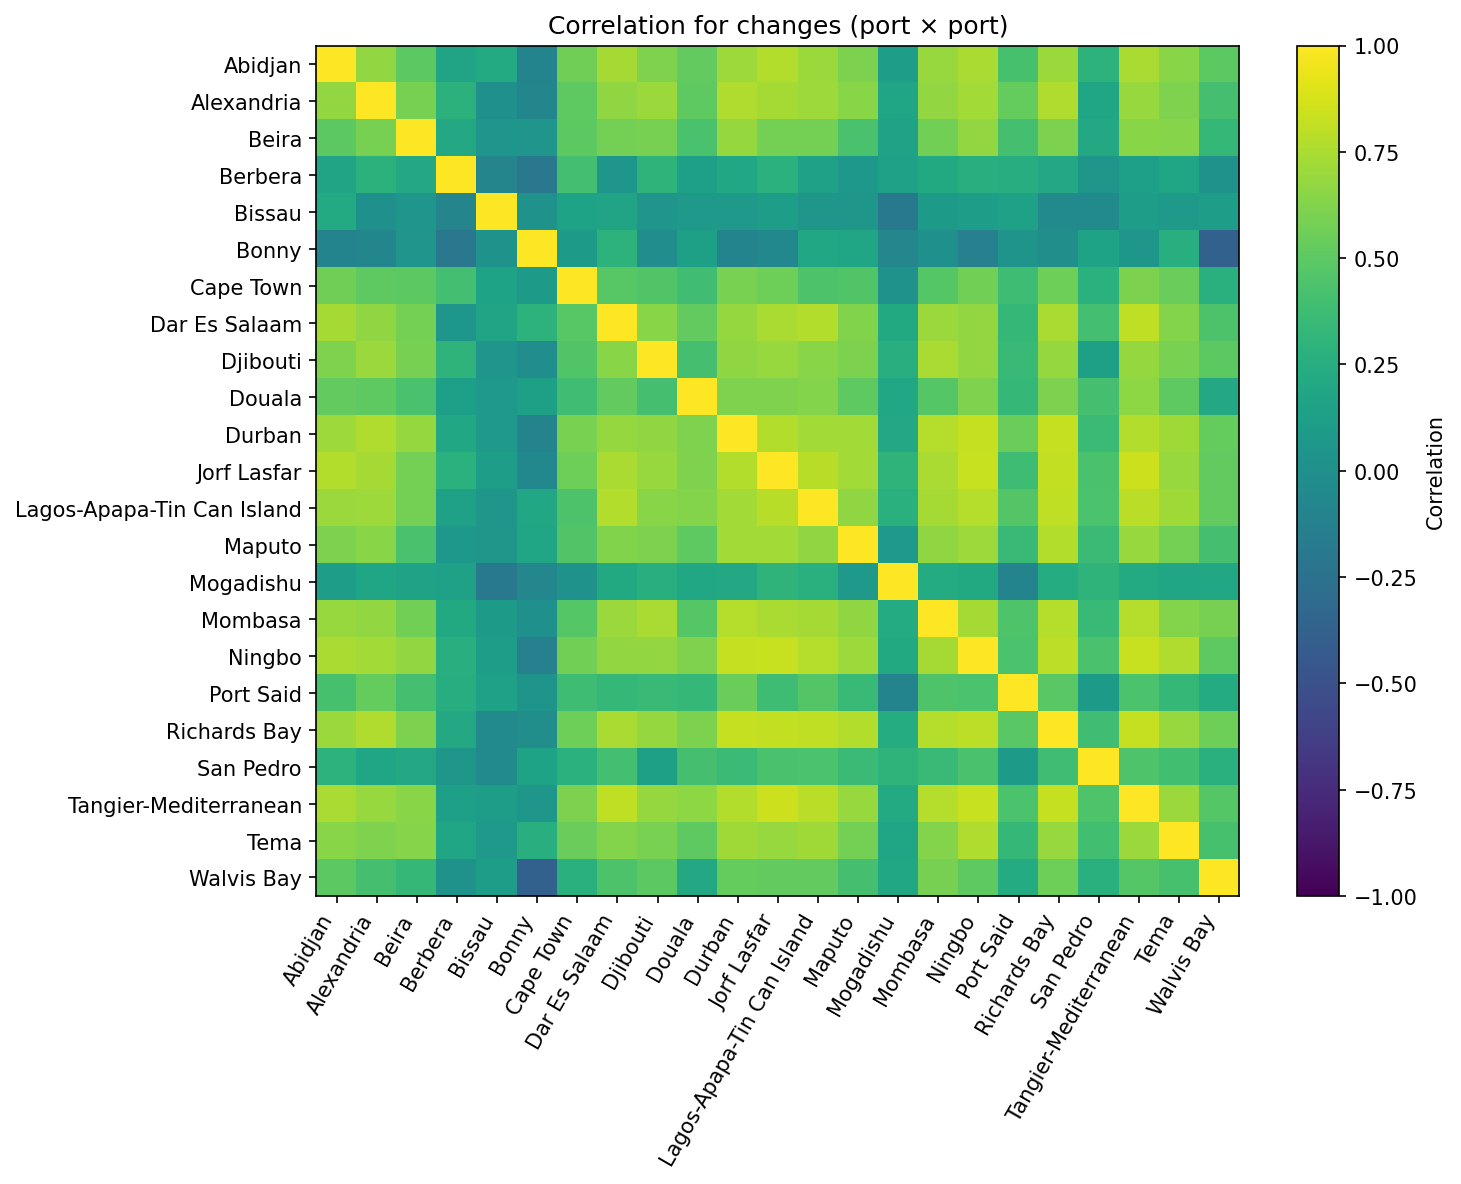

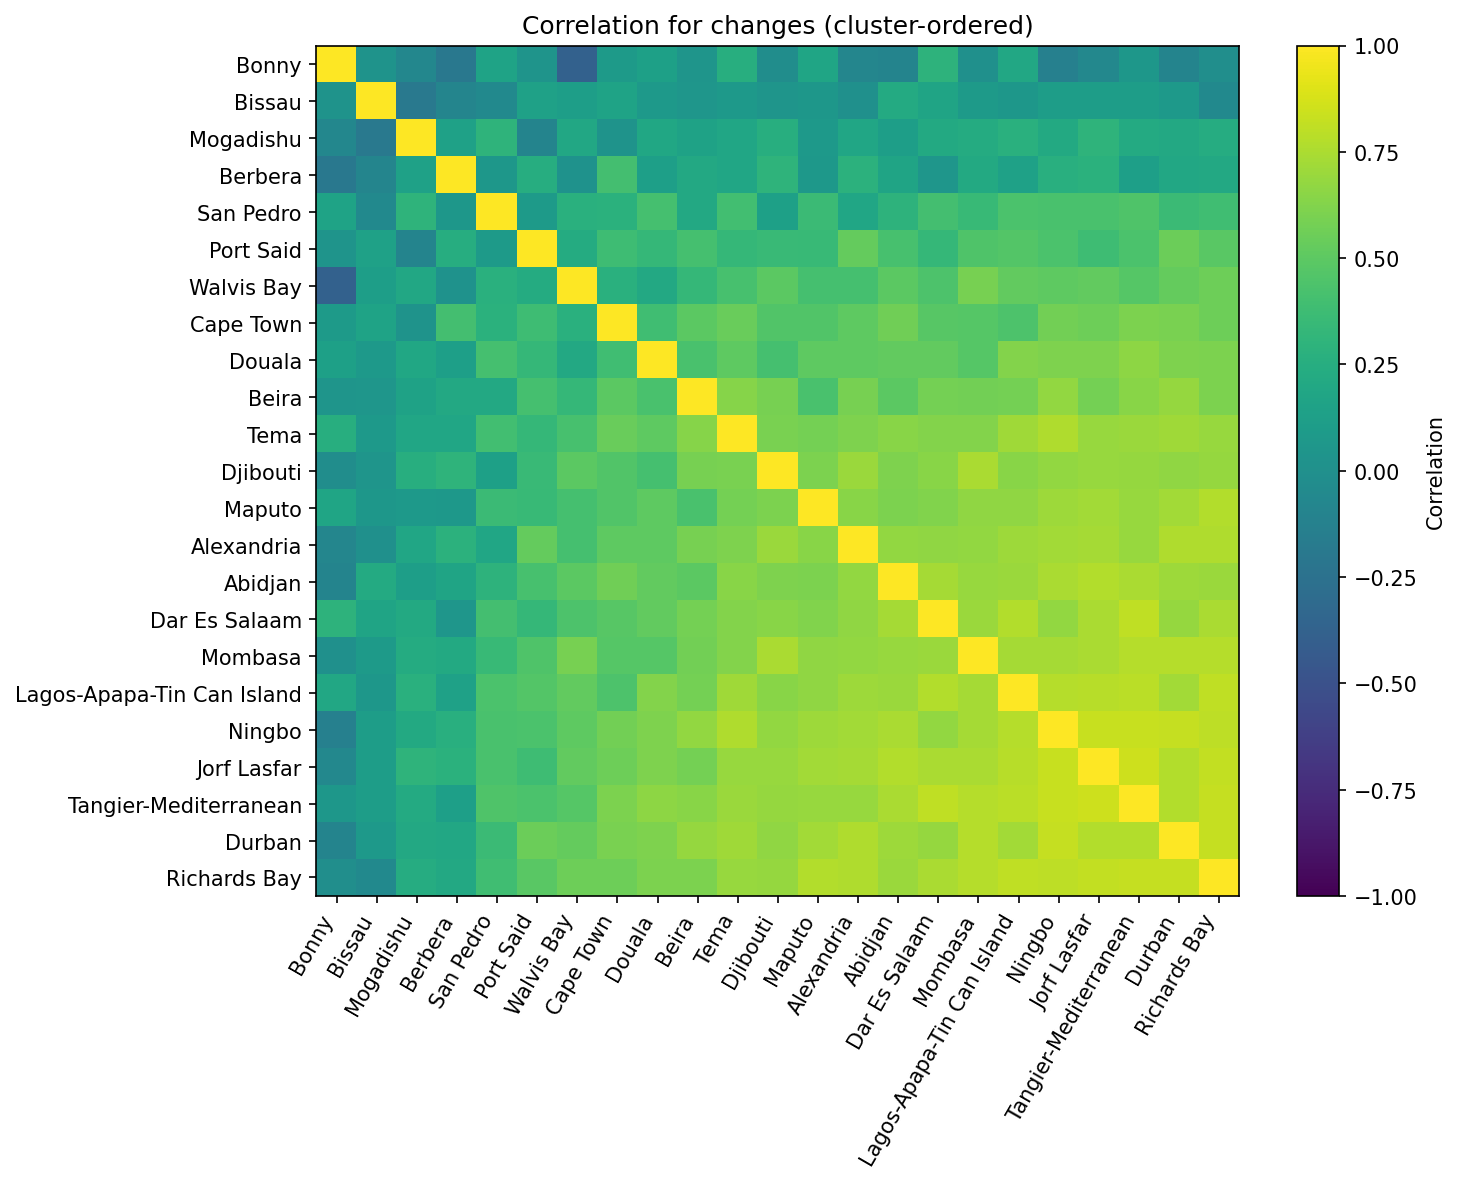

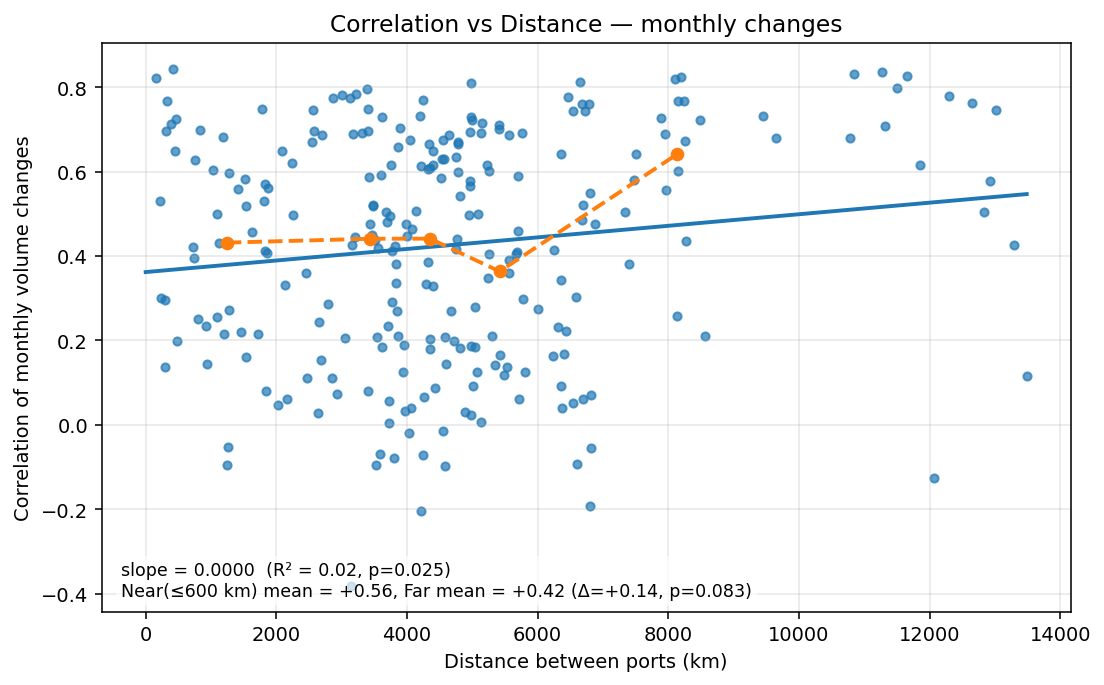

port_a                      port_b          km  \
182                      Durban                Richards Bay  154.949939   
37                   Alexandria                   Port Said  224.446219   
67                      Berbera                    Djibouti  238.753362   
103                       Bonny                      Douala  293.745730   
18                      Abidjan                   San Pedro  297.768697   
140               Dar Es Salaam                     Mombasa  308.369425   
212                      Maputo                Richards Bay  319.332750   
206  Lagos-Apapa-Tin Can Island                        Tema  382.589927   
195                 Jorf Lasfar       Tangier-Mediterranean  416.514289   
20                      Abidjan                        Tema  446.357294   
177                      Durban                      Maputo  460.986905   
106                       Bonny  Lagos-Apapa-Tin Can Island  475.781792   
53                        Beira                      Maputo  718.760131   
248                   San Pedro                        Tema  742.354841   
164                      Douala  Lagos-Apapa-Tin Can Island  758.870310   

         corr   near  
182  0.821608   True  
37   0.530047   True  
67   0.300091   True  
103  0.138173   True  
18   0.296738   True  
140  0.696468   True  
212  0.766537   True  
206  0.711592   True  
195  0.843989   True  
20   0.647861   True  
177  0.723731   True  
106  0.198193   True  
53   0.422336  False  
248  0.395590  False  
164  0.628262  False

In [97]:
# ======= CONFIG =======
import pandas as pd, numpy as np, matplotlib.pyplot as plt

METRIC    = "total"        # "import", "export", or "total"
FREQ      = "ME"            # "M" (month-end) or "W-FRI"
CHANGE    = "logret"       # "level","diff","pct","logret"
SMOOTH    = 3              # 0=off, else rolling mean window (e.g., 3)
MIN_OBS   = 18             # require ≥ this many overlapping periods
LAG_RANGE = range(-6, 7)   # scan -6..+6 months; L>0 => second series leads
# ======================

# 0) Build port series from pdc (monthly)
def build_series(pdc, metric=METRIC, freq=FREQ):
    out = {}
    for city, df in pdc.items():
        if isinstance(df, list):
            if not df: 
                continue
            df = df[0]
        if not isinstance(df, pd.DataFrame):
            continue

        if metric == "total":
            y = pd.to_numeric(df["import"], errors="coerce") + pd.to_numeric(df["export"], errors="coerce")
        else:
            y = pd.to_numeric(df[metric], errors="coerce")

        s = (df.assign(y=y).set_index("date")["y"].resample(freq).sum())
        out[city] = s
    return out

def transform(s, how=CHANGE, smooth=SMOOTH):
    s = s.sort_index().astype(float)
    if   how == "level":  t = s
    elif how == "diff":   t = s.diff()
    elif how == "pct":    t = s.pct_change()
    elif how == "logret": t = np.log(s).diff()
    else: raise ValueError("CHANGE must be level/diff/pct/logret")
    if smooth and smooth > 1:
        t = t.rolling(smooth, min_periods=smooth).mean()
    return t

# Build transformed series dict
raw_series = build_series(pdc, METRIC, FREQ)
series = {k: transform(v) for k, v in raw_series.items() if v is not None}

# 1a) SAME-TIME correlation matrix
def corr_matrix(series_dict, min_obs=MIN_OBS):
    names = sorted(series_dict.keys())
    C = pd.DataFrame(index=names, columns=names, dtype=float)
    for i, a in enumerate(names):
        A = series_dict[a]
        for j, b in enumerate(names[i:], start=i):
            B = series_dict[b]
            xy = pd.concat([A.rename("a"), B.rename("b")], axis=1).dropna()
            r = xy["a"].corr(xy["b"]) if len(xy) >= min_obs else np.nan
            C.loc[a, b] = C.loc[b, a] = r
    return C

C_same = corr_matrix(series)

# 1b) BEST LEAD/LAG per pair (scan shifts)
def best_lag_for_pair(A, B, lags=LAG_RANGE, min_obs=MIN_OBS):
    best = (np.nan, 0, 0)  # (corr, lag, nobs)
    for L in lags:
        # L>0 means B is shifted FORWARD -> B leads A by L (use older B to explain later A)
        xy = pd.concat([A.rename("a"), B.shift(L).rename("b")], axis=1).dropna()
        n = len(xy)
        if n >= min_obs:
            r = xy["a"].corr(xy["b"])
            if np.isnan(best[0]) or abs(r) > abs(best[0]):
                best = (r, L, n)
    return best

def best_lag_table(series_dict, lags=LAG_RANGE, min_obs=MIN_OBS):
    names = sorted(series_dict.keys())
    rows = []
    for i, a in enumerate(names):
        for b in names[i+1:]:
            r, lag, n = best_lag_for_pair(series_dict[a], series_dict[b], lags, min_obs)
            rows.append({"port_a": a, "port_b": b, "best_corr": r, "best_lag": lag, "nobs": n})
    df = pd.DataFrame(rows).sort_values(by="best_corr", key=lambda s: s.abs(), ascending=False)
    return df

best_lags = best_lag_table(series)

# 1c) Cross-Correlation Function (CCF) plot for any pair
def plot_ccf(city_a, city_b, lags=LAG_RANGE, min_obs=MIN_OBS):
    A, B = series[city_a], series[city_b]
    vals, good_lags = [], []
    for L in lags:
        xy = pd.concat([A.rename("a"), B.shift(L).rename("b")], axis=1).dropna()
        if len(xy) >= min_obs:
            vals.append(xy["a"].corr(xy["b"]))
            good_lags.append(L)
    fig, ax = plt.subplots(figsize=(7,3), dpi=130)
    # Removed 'use_line_collection=True' parameter as it's no longer supported
    # in newer versions of Matplotlib
    ax.stem(good_lags, vals)
    ax.axhline(0, color="k", lw=0.8)
    ax.set_xlabel("Lag (months)  —  L>0: second series leads")
    ax.set_ylabel("Correlation")
    ax.set_title(f"CCF: {city_a} vs {city_b}  ({METRIC}, {CHANGE}, MA={SMOOTH})")
    plt.tight_layout()
    plt.show()

# 1d) Rolling correlation (stability over time)
def plot_rolling_corr(city_a, city_b, window=24):
    A, B = series[city_a], series[city_b]
    xy = pd.concat([A.rename("a"), B.rename("b")], axis=1).dropna()
    r_roll = xy["a"].rolling(window).corr(xy["b"])
    fig, ax = plt.subplots(figsize=(7,3), dpi=130)
    ax.plot(r_roll.index, r_roll.values)
    ax.axhline(0, color="k", lw=0.8)
    ax.set_title(f"Rolling {window}-month corr: {city_a} vs {city_b}  ({METRIC}, {CHANGE}, MA={SMOOTH})")
    ax.set_ylabel("Correlation"); ax.set_xlabel("Date")
    ax.grid(alpha=0.3)
    plt.tight_layout(); plt.show()

# ----- EXAMPLES -----
# 1) View the same-time correlation matrix:
display(C_same.round(2))

# 2) See the top 10 lead/lag relationships (abs corr):
display(best_lags.head(10))

# 3) Plot a CCF for a pair you care about (who moves first?):
#plot_ccf("Durban", "Richards Bay")

# 4) Are relationships episodic?
#plot_rolling_corr("Durban", "Richards Bay", window=24)

# --- basic checks / ordering ---
C = C_same.copy()                        # your port×port correlation DataFrame
C = C.loc[C.index, C.index]              # ensure square / same order
C = C.astype(float)

# If there are NaNs, replace them with the off-diagonal median so colors render sensibly
vals = C.values
offdiag = vals[np.triu_indices_from(vals, k=1)]
fill_val = np.nanmedian(offdiag)
C = C.fillna(fill_val)

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 8), dpi=150)

im = ax.imshow(C.values, vmin=-1, vmax=1, aspect='auto')  # don't specify a colormap per your rules
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Correlation")

# ticks / labels
names = list(C.index)
ax.set_xticks(range(len(names)))
ax.set_yticks(range(len(names)))
ax.set_xticklabels(names, rotation=60, ha='right')
ax.set_yticklabels(names)

ax.set_title("Correlation for changes (port × port)")
ax.grid(False)

plt.tight_layout()
plt.show()

from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

D = 1 - C  # distance = 1 - corr
np.fill_diagonal(D.values, 0.0)
order = leaves_list(linkage(squareform(D.values, checks=False), method="average"))
C_ord = C.iloc[order, :].iloc[:, order]

fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
im = ax.imshow(C_ord.values, vmin=-1, vmax=1, aspect='auto')
fig.colorbar(im, ax=ax).set_label("Correlation")
names_ord = list(C_ord.index)
ax.set_xticks(range(len(names_ord))); ax.set_yticks(range(len(names_ord)))
ax.set_xticklabels(names_ord, rotation=60, ha='right'); ax.set_yticklabels(names_ord)
ax.set_title("Correlation for changes (cluster-ordered)")
plt.tight_layout(); plt.show()

# --- knobs ---
NEAR_KM   = 600        # radius to label "nearby"
N_PERMUTE = 5000       # permutations for p-value on slope/near-vs-far
TITLE     = "Correlation vs Distance — monthly changes"
# -------------

# 1) Build pairs: (a,b, km, corr)
def haversine_km(latlon1, latlon2):
    lat1, lon1 = map(radians, latlon1)
    lat2, lon2 = map(radians, latlon2)
    dlat, dlon = lat2-lat1, lon2-lon1
    h = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2*6371*asin(sqrt(h))

# Ensure C_same is square and aligned
C = C_same.loc[C_same.index, C_same.index].astype(float)

pairs = []
names = list(C.index)
for i, a in enumerate(names):
    if a not in city_to_coords: 
        continue
    for j in range(i+1, len(names)):
        b = names[j]
        if b not in city_to_coords: 
            continue
        r = C.loc[a, b]
        if pd.isna(r):
            continue
        km = haversine_km(city_to_coords[a], city_to_coords[b])
        pairs.append((a, b, km, r))

pairs_df = pd.DataFrame(pairs, columns=["port_a","port_b","km","corr"]).sort_values("km")
assert not pairs_df.empty, "No overlapping (coords, correlation) pairs."

# 2) Fit a simple line corr ~ km
x = pairs_df["km"].values
y = pairs_df["corr"].values
m, b = np.polyfit(x, y, 1)
yhat = m*x + b
ss_res = np.sum((y - yhat)**2)
ss_tot = np.sum((y - np.mean(y))**2)
R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

# 3) Permutation p-value for slope sign (shuffle corr against km)
rng = np.random.default_rng(0)
perm = []
for _ in range(N_PERMUTE):
    y_perm = rng.permutation(y)
    m_p, _ = np.polyfit(x, y_perm, 1)
    perm.append(m_p)
perm = np.array(perm)
p_slope = (np.sum(np.abs(perm) >= abs(m)) + 1) / (len(perm) + 1)

# 4) Near vs far summary + permutation p-value for mean difference
near_mask = pairs_df["km"] <= NEAR_KM
mu_near = float(pairs_df.loc[near_mask, "corr"].mean())
mu_far  = float(pairs_df.loc[~near_mask, "corr"].mean())

# permutation on labels
diff_obs = mu_near - mu_far
perm_diff = []
mask = near_mask.values.copy()
for _ in range(N_PERMUTE):
    rng.shuffle(mask)
    perm_diff.append(pairs_df["corr"].values[mask].mean() - pairs_df["corr"].values[~mask].mean())
perm_diff = np.array(perm_diff)
p_nearfar = (np.sum(np.abs(perm_diff) >= abs(diff_obs)) + 1) / (len(perm_diff) + 1)

# 5) Optional: bin curve (median corr per distance bin)
bins = np.quantile(pairs_df["km"], [0, .2, .4, .6, .8, 1.0])
bin_id = np.digitize(pairs_df["km"], bins[1:-1], right=True)
bin_x = pairs_df.groupby(bin_id)["km"].median()
bin_y = pairs_df.groupby(bin_id)["corr"].median()

# 6) Plots
fig, ax = plt.subplots(figsize=(8,5), dpi=140)
ax.scatter(pairs_df["km"], pairs_df["corr"], s=18, alpha=0.7)
xs = np.linspace(0, pairs_df["km"].max(), 200)
ax.plot(xs, m*xs + b, lw=2)
ax.plot(bin_x, bin_y, lw=2, linestyle="--", marker="o")  # bin curve

ax.set_xlabel("Distance between ports (km)")
ax.set_ylabel("Correlation of monthly volume changes")
ax.set_title(TITLE)
ax.grid(alpha=0.3)

txt = (f"slope = {m:.4f}  (R² = {R2:.2f}, p={p_slope:.3f})\n"
       f"Near(≤{NEAR_KM} km) mean = {mu_near:+.2f}, Far mean = {mu_far:+.2f} "
       f"(Δ={diff_obs:+.2f}, p={p_nearfar:.3f})")
ax.text(0.02, 0.02, txt, transform=ax.transAxes, va="bottom", ha="left", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, lw=0))

plt.tight_layout()
plt.show()

# (Optional) table of pairs for inspection
display(pairs_df.assign(near=near_mask).head(15))


In [81]:
# ---- knobs ----
FREQ    = "ME"          # monthly
CHANGE  = "pct"        # "pct" or "logret" are best for co-movement
SMOOTH  = 3            # 0=off, else small moving average
MIN_OBS = 18           # minimum overlapping periods for pairwise corr
NEAR_KM = 600          # "nearby" radius (tune: 300–800)
# ----------------

def _transform(s, how=CHANGE, smooth=SMOOTH):
    s = s.sort_index().astype(float)
    if   how == "pct":    s = s.pct_change()
    elif how == "logret": s = np.log(s).diff()
    elif how == "diff":   s = s.diff()
    elif how == "level":  s = s
    else: raise ValueError
    if smooth and smooth > 1:
        s = s.rolling(smooth, min_periods=smooth).mean()
    return s

# Build monthly export/import series per port
exp_series, imp_series = {}, {}
for city, df in pdc.items():
    if isinstance(df, list):
        if not df: 
            continue
        df = df[0]
    if not isinstance(df, pd.DataFrame):
        continue
    e = pd.to_numeric(df["export"], errors="coerce")
    m = pd.to_numeric(df["import"], errors="coerce")
    e_m = df.assign(y=e).set_index("date")["y"].resample(FREQ).sum()
    m_m = df.assign(y=m).set_index("date")["y"].resample(FREQ).sum()
    exp_series[city] = _transform(e_m)
    imp_series[city] = _transform(m_m)

ports = sorted(set(exp_series) & set(imp_series))


In [82]:
def corr_matrix(series_dict):
    names = sorted(series_dict.keys())
    C = pd.DataFrame(index=names, columns=names, dtype=float)
    for i, a in enumerate(names):
        A = series_dict[a]
        for j, b in enumerate(names[i:], start=i):
            B = series_dict[b]
            xy = pd.concat([A.rename("a"), B.rename("b")], axis=1).dropna()
            r = xy["a"].corr(xy["b"]) if len(xy) >= MIN_OBS else np.nan
            C.loc[a,b] = C.loc[b,a] = r
    return C

C_exp = corr_matrix({k: exp_series[k] for k in ports})
C_imp = corr_matrix({k: imp_series[k] for k in ports})

In [94]:
city_to_coords = {
    "Durban": (-29.86, 31.03),                  # :contentReference[oaicite:0]{index=0}
    "Richards Bay": (-28.78, 32.04),            # :contentReference[oaicite:1]{index=1}
    "Cape Town": (-33.92, 18.42),               # :contentReference[oaicite:2]{index=2}
    "Dar Es Salaam": (-6.78, 39.23),            # :contentReference[oaicite:3]{index=3}
    "Mombasa": (-4.04, 39.66),                  # :contentReference[oaicite:4]{index=4}
    "Maputo": (-25.95, 32.59),                  # :contentReference[oaicite:5]{index=5}
    "Beira": (-19.83, 34.85),                   # :contentReference[oaicite:6]{index=6}
    "Walvis Bay": (-22.96, 14.50),              # :contentReference[oaicite:7]{index=7}
    "Douala": (4.06, 9.79),                     # :contentReference[oaicite:8]{index=8}
    "Tangier-Mediterranean": (35.87, -5.52),    # (Tanger-Med) :contentReference[oaicite:9]{index=9}
    "Jorf Lasfar": (33.13, -8.62),              # :contentReference[oaicite:10]{index=10}
    "Alexandria": (31.21, 29.92),               # :contentReference[oaicite:11]{index=11}
    "Port Said": (31.26, 32.28),                # :contentReference[oaicite:12]{index=12}
    "Lagos-Apapa-Tin Can Island": (6.45, 3.37), # Apapa/Tin-Can area (rep. point) :contentReference[oaicite:13]{index=13}
    "Bonny": (4.45, 7.17),                      # :contentReference[oaicite:14]{index=14}
    "Tema": (5.67, 0.00),                       # :contentReference[oaicite:15]{index=15}
    "Abidjan": (5.35, -4.02),                   # :contentReference[oaicite:16]{index=16}
    "San Pedro": (4.75, -6.64),                 # :contentReference[oaicite:17]{index=17}
    "Bissau": (11.85, -15.57),                  # :contentReference[oaicite:18]{index=18}
    "Mogadishu": (2.05, 45.32),                 # :contentReference[oaicite:19]{index=19}
    "Berbera": (10.44, 45.01),                  # :contentReference[oaicite:20]{index=20}
    "Djibouti": (11.57, 43.15),                 # (Djibouti City) :contentReference[oaicite:21]{index=21}
    "Ningbo": (29.87, 121.54),                  # :contentReference[oaicite:22]{index=22}
}

def haversine_km(a, b):
    lat1, lon1 = map(radians, a); lat2, lon2 = map(radians, b)
    dlat, dlon = lat2-lat1, lon2-lon1
    h = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2*6371*asin(sqrt(h))

# Build distance DF for ports we have coords for
ports_geo = [p for p in ports if p in city_to_coords]
D_km = pd.DataFrame(index=ports_geo, columns=ports_geo, dtype=float)
for i, a in enumerate(ports_geo):
    for j, b in enumerate(ports_geo[i:], start=i):
        d = 0.0 if a==b else haversine_km(city_to_coords[a], city_to_coords[b])
        D_km.loc[a,b] = D_km.loc[b,a] = d

def near_vs_far(C, D, radius_km=NEAR_KM):
    pairs, near_vals, far_vals = [], [], []
    names = sorted(set(C.index) & set(D.index))
    for i, a in enumerate(names):
        for j, b in enumerate(names[i+1:], start=i+1):
            r = C.loc[a,b]
            if pd.isna(r): continue
            d = D.loc[a,b]
            (near_vals if d <= radius_km else far_vals).append(r)
            pairs.append((a,b,d,r))
    return pd.Series(near_vals).dropna(), pd.Series(far_vals).dropna(), pd.DataFrame(pairs, columns=["a","b","km","corr"])

near_e, far_e, pairs_e = near_vs_far(C_exp, D_km, NEAR_KM)
near_i, far_i, pairs_i = near_vs_far(C_imp, D_km, NEAR_KM)

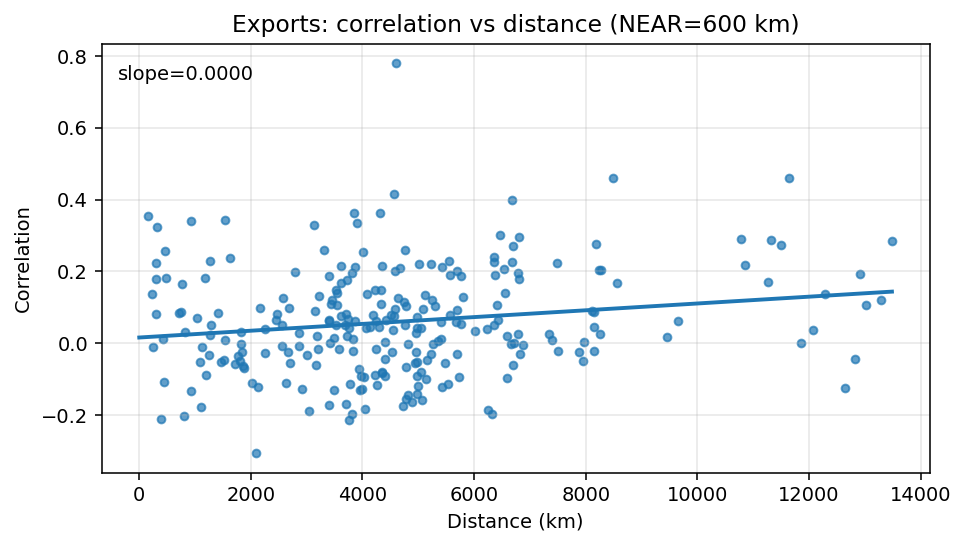

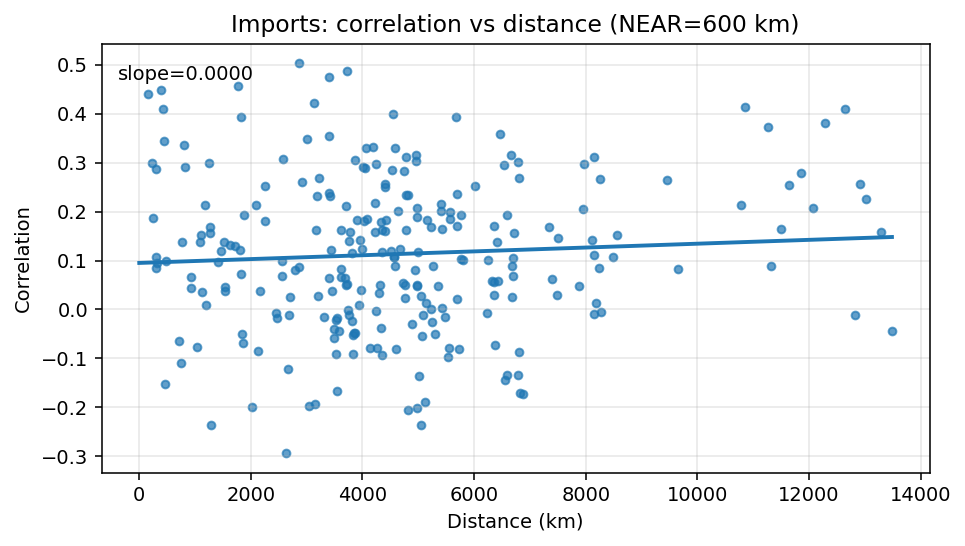

In [89]:
def plot_corr_vs_dist(pairs_df, title):
    fig, ax = plt.subplots(figsize=(7,4), dpi=140)
    ax.scatter(pairs_df["km"], pairs_df["corr"], s=16, alpha=0.7)
    # simple line fit
    x = pairs_df["km"].values; y = pairs_df["corr"].values
    if len(x) >= 3:
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(0, x.max(), 200); ax.plot(xs, m*xs + b, lw=2)
        ax.text(0.02, 0.95, f"slope={m:.4f}", transform=ax.transAxes, va="top")
    ax.set_xlabel("Distance (km)"); ax.set_ylabel("Correlation")
    ax.set_title(title); ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

plot_corr_vs_dist(pairs_e, f"Exports: correlation vs distance (NEAR={NEAR_KM} km)")
plot_corr_vs_dist(pairs_i, f"Imports: correlation vs distance (NEAR={NEAR_KM} km)")


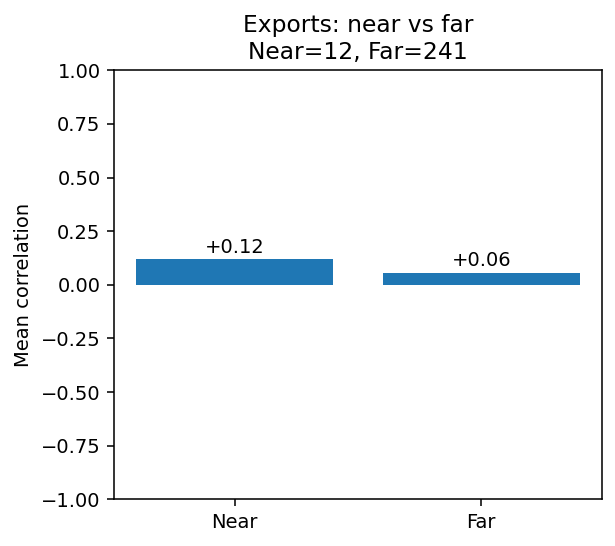

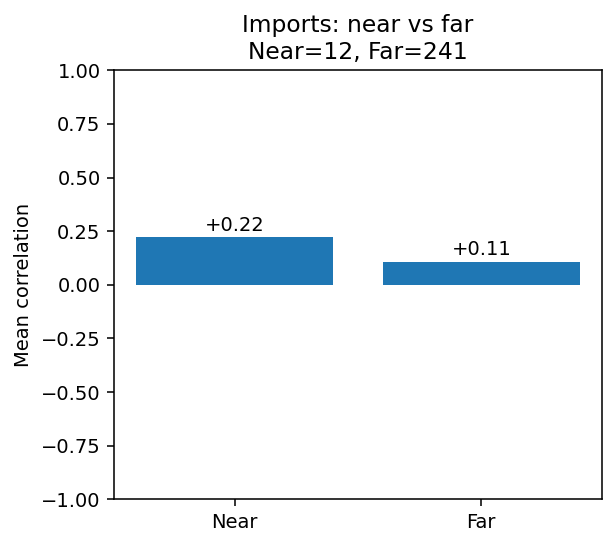

In [90]:
def plot_near_far(near_vals, far_vals, title):
    mu_n, mu_f = float(near_vals.mean()), float(far_vals.mean())
    fig, ax = plt.subplots(figsize=(4.5,4), dpi=140)
    ax.bar(["Near","Far"], [mu_n, mu_f])
    ax.set_ylim(-1,1); ax.set_ylabel("Mean correlation")
    ax.set_title(title + f"\nNear={len(near_vals)}, Far={len(far_vals)}")
    for i,v in enumerate([mu_n, mu_f]): ax.text(i, v + 0.03*np.sign(v), f"{v:+.2f}", ha="center")
    plt.tight_layout(); plt.show()

plot_near_far(near_e, far_e, "Exports: near vs far")
plot_near_far(near_i, far_i, "Imports: near vs far")


/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in l

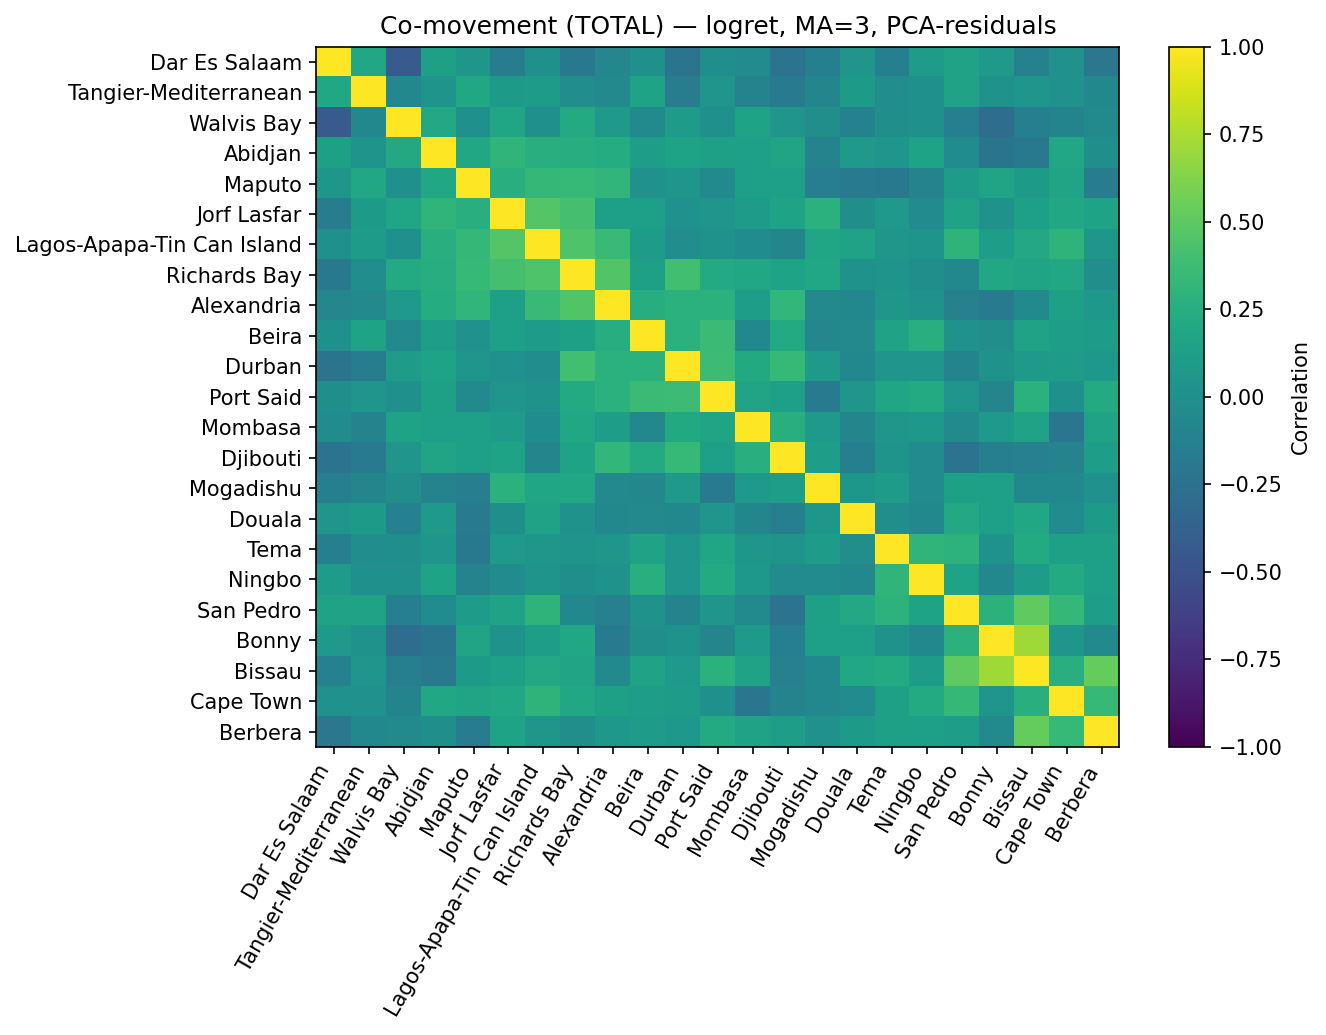

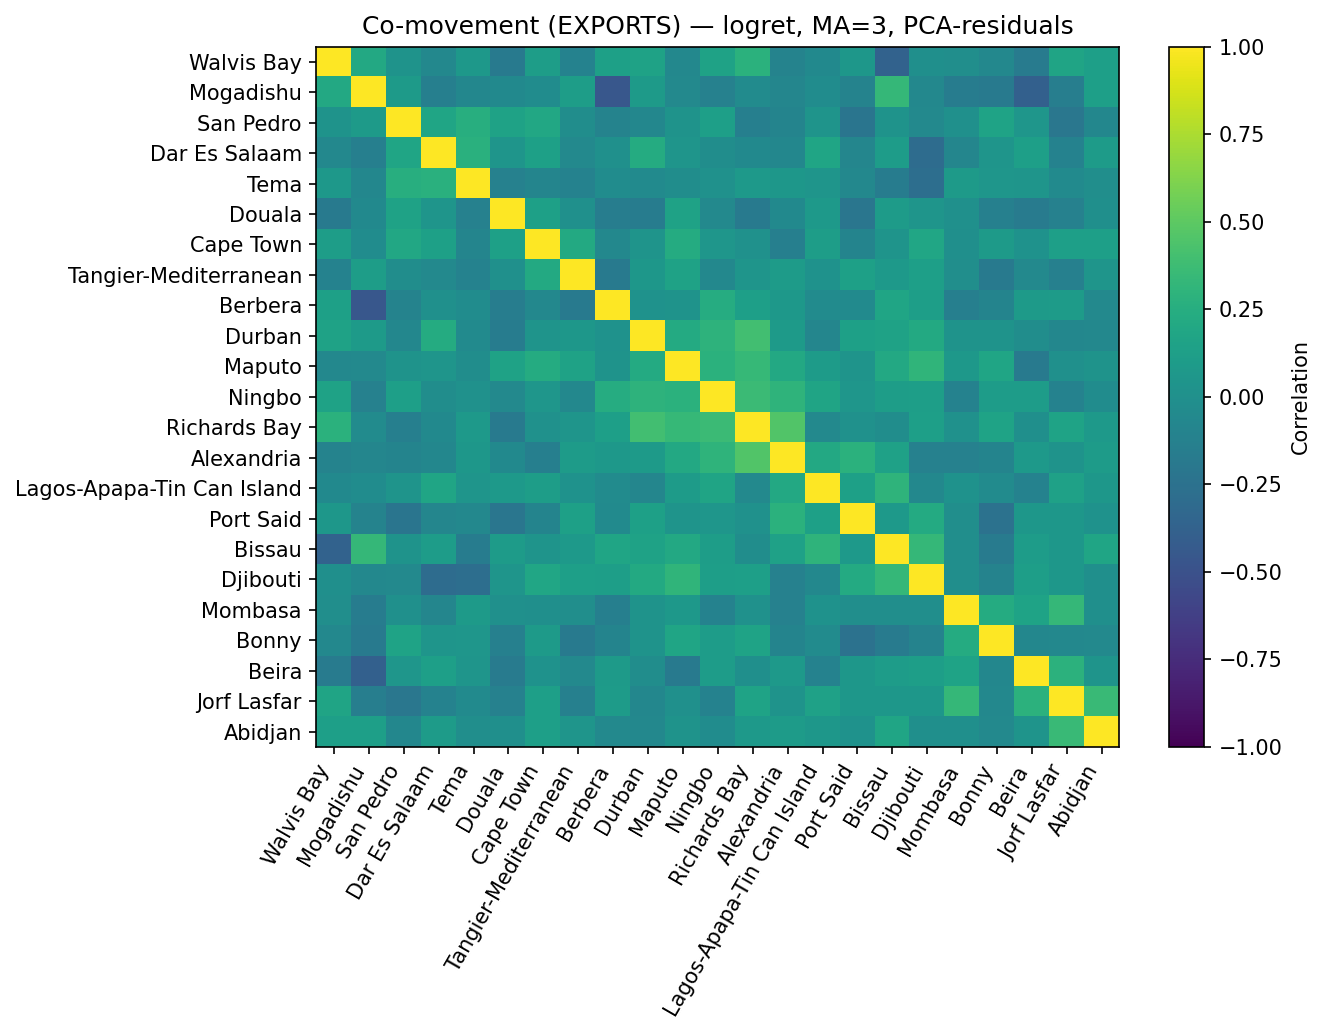

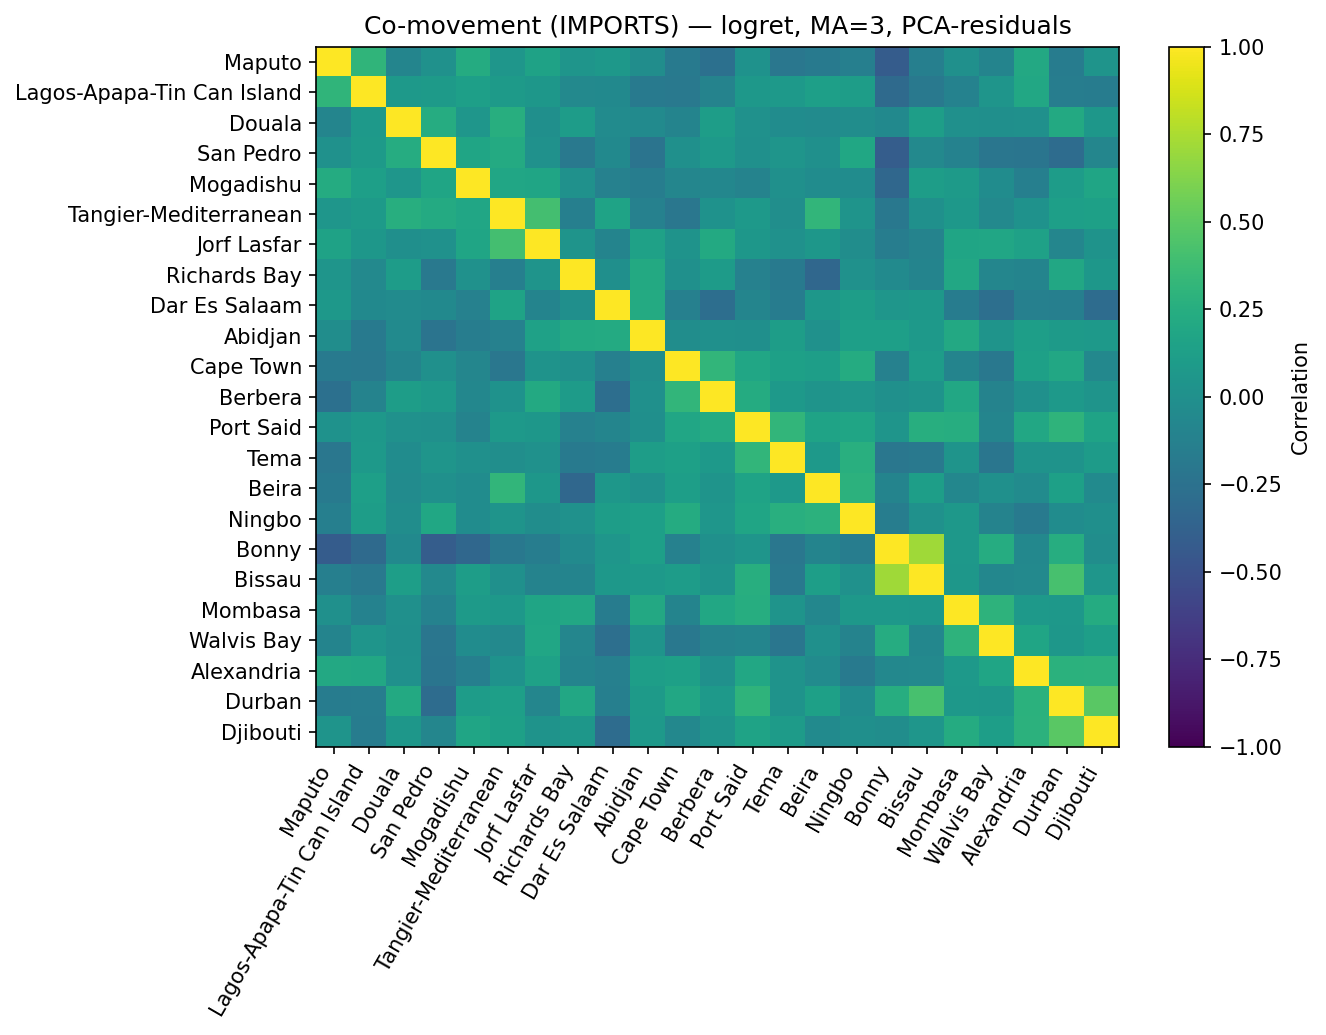

TOTAL: corr vs distance (logret, MA=3, PCA-residuals): slope (corr vs km) = 0.0000


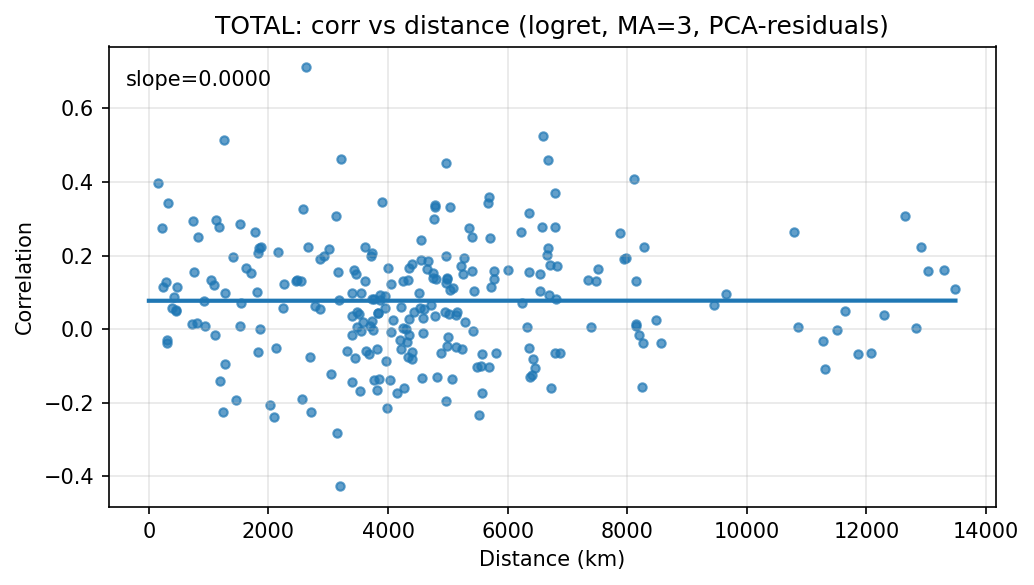

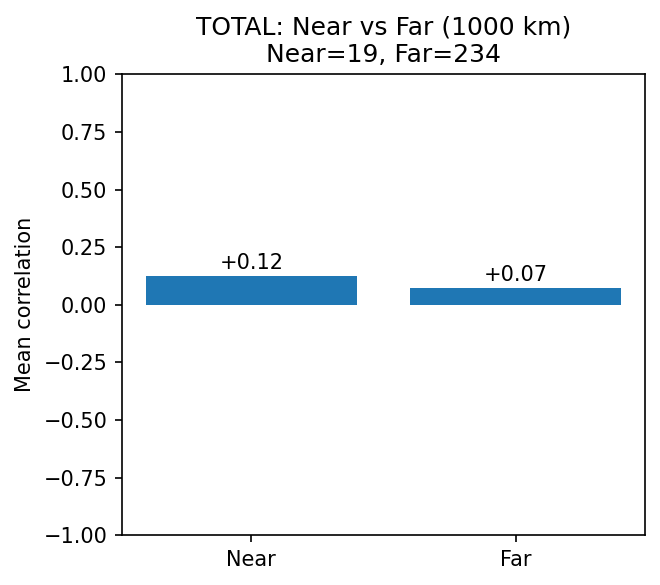

TOTAL: Near vs Far (1000 km): mean Near=+0.124, mean Far=+0.073, Δ=+0.051
EXPORTS: corr vs distance (logret, MA=3, PCA-residuals): slope (corr vs km) = 0.0000


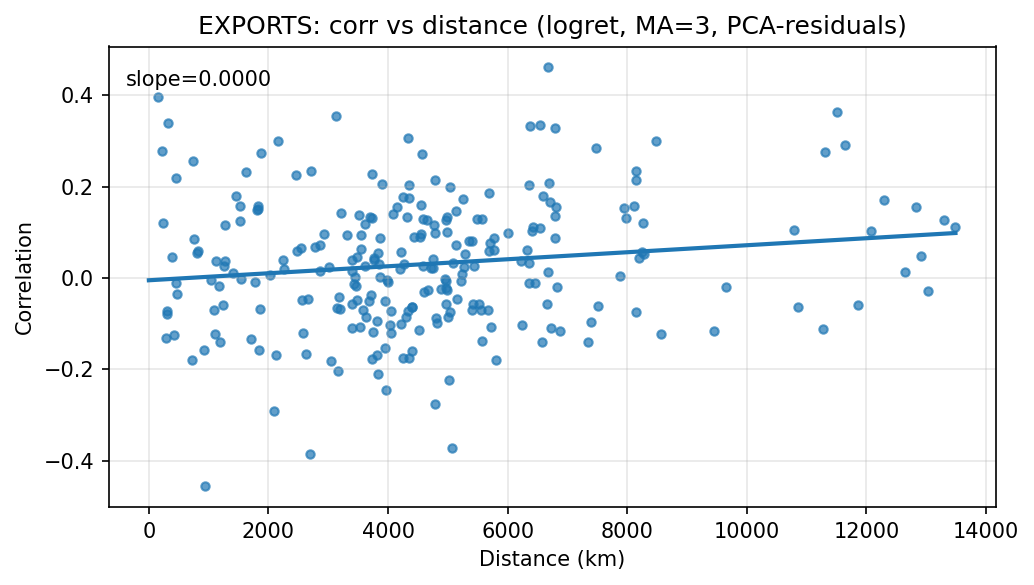

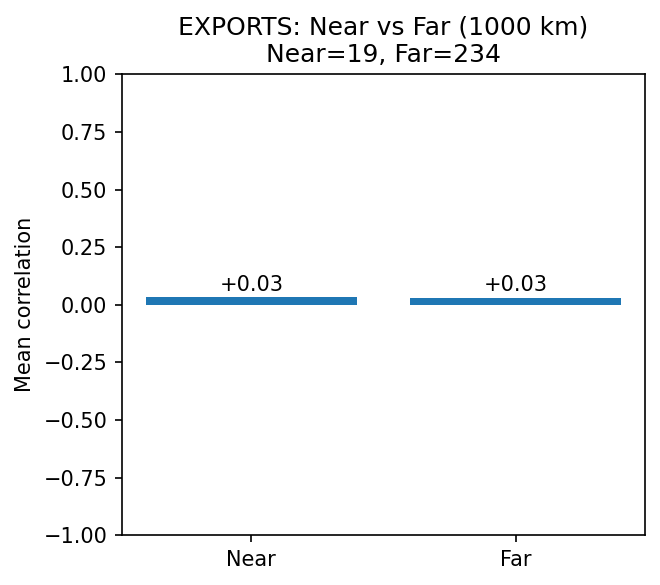

EXPORTS: Near vs Far (1000 km): mean Near=+0.032, mean Far=+0.031, Δ=+0.002
IMPORTS: corr vs distance (logret, MA=3, PCA-residuals): slope (corr vs km) = 0.0000


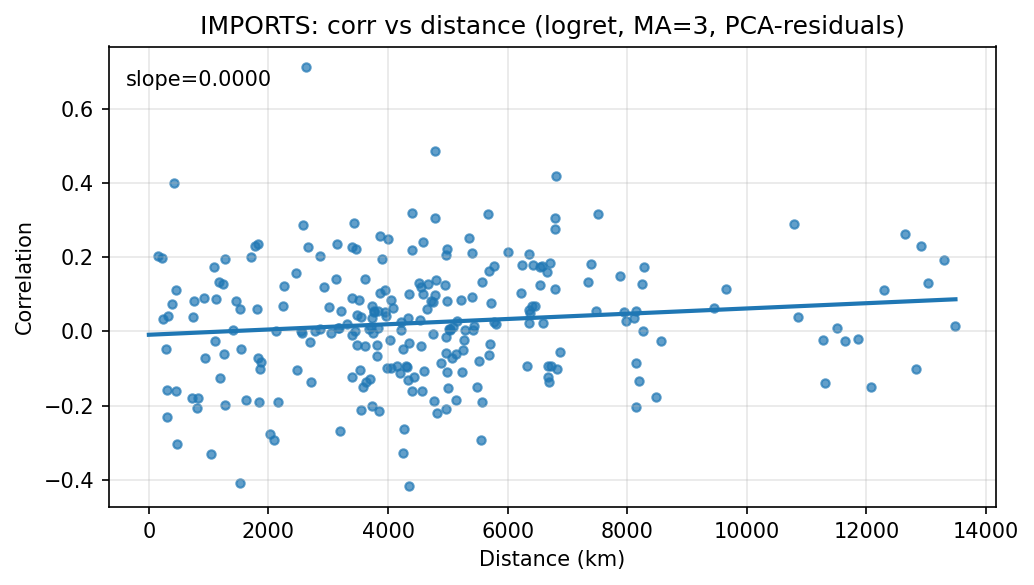

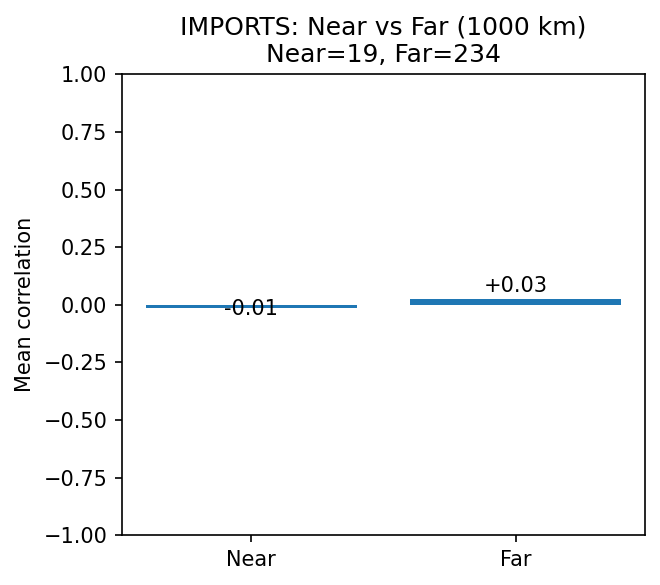

IMPORTS: Near vs Far (1000 km): mean Near=-0.014, mean Far=+0.027, Δ=-0.041

TOTAL residual corr — mean off-diagonal: +0.077 (after global-factor removal)
EXPORTS residual corr — mean off-diagonal: +0.031
IMPORTS residual corr — mean off-diagonal: +0.024


In [96]:
# ====== CONFIG ======
FREQ     = "MS"         # monthly start; your 'date' can be daily
TRANS    = "logret"     # "pct" or "logret" (recommended), or "diff"/"level"
SMOOTH   = 3            # 0=off, else simple MA window (e.g., 3)
WINS     = (0.01, 0.99) # winsorize tails
MIN_OBS  = 18           # min overlap for pairwise corr
NEAR_KM  = 1000          # radius to call ports "nearby"
MAKE_IMPORT_EXPORT = True  # also compute import-only, export-only flavors
TITLE_NOTE = f"{TRANS}, MA={SMOOTH}, PCA-residuals"

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt

# Optional seasonal adjustment (STL). If unavailable, we skip it gracefully.
try:
    from statsmodels.tsa.seasonal import STL
    HAS_STL = True
except Exception:
    HAS_STL = False

# ========== HELPERS ==========
def _resample_monthly(series, freq=FREQ):
    return series.resample(freq).sum()

def seasonal_adjust_level(s):
    """Return seasonally adjusted level. If STL not available, return as-is."""
    if not HAS_STL or len(s) < 24:
        return s
    s = s.asfreq(FREQ).interpolate("time")
    res = STL(s, period=12, robust=True).fit()
    return (res.trend + res.resid)

def winsorize(s, q_lo=0.01, q_hi=0.99):
    lo, hi = s.quantile(q_lo), s.quantile(q_hi)
    return s.clip(lower=lo, upper=hi)

def transform_change(s, how=TRANS, smooth=SMOOTH, wins=WINS):
    s = s.sort_index()
    # change transformation
    if how == "pct":
        t = s.pct_change()
    elif how == "logret":
        t = np.log(s).diff()
    elif how == "diff":
        t = s.diff()
    elif how == "level":
        t = s
    else:
        raise ValueError("TRANS must be one of: pct/logret/diff/level")
    # winsorize small tails (after change)
    if wins and 0 < wins[0] < wins[1] < 1:
        t = winsorize(t, wins[0], wins[1])
    # de-noise with small MA
    if smooth and smooth > 1:
        t = t.rolling(smooth, min_periods=smooth).mean()
    return t.dropna()

def build_monthly_series(pdc):
    """Returns dicts of monthly totals/imports/exports (levels)."""
    totals, imports, exports = {}, {}, {}
    for city, df in pdc.items():
        if isinstance(df, list):
            if not df: 
                continue
            df = df[0]
        if not isinstance(df, pd.DataFrame) or "date" not in df:
            continue
        dfx = df.copy()
        dfx["import"] = pd.to_numeric(dfx["import"], errors="coerce")
        dfx["export"] = pd.to_numeric(dfx["export"], errors="coerce")
        dfx = dfx.set_index("date").sort_index()
        tot = _resample_monthly(dfx["import"] + dfx["export"])
        imp = _resample_monthly(dfx["import"])
        exp = _resample_monthly(dfx["export"])
        totals[city], imports[city], exports[city] = tot, imp, exp
    return totals, imports, exports

def prepare_changes(level_dict):
    """Seasonal-adjust levels, then convert to stabilized changes."""
    out = {}
    for k, s in level_dict.items():
        s_adj = seasonal_adjust_level(s)
        out[k] = transform_change(s_adj)
    return out

def align_to_dataframe(series_dict):
    """Stack dict of Series into aligned DataFrame (T x N)."""
    return pd.DataFrame(series_dict).dropna(how="all")

def pca_residuals(X):
    """Remove 1st principal component (global factor). Returns residual DataFrame."""
    X0 = X.sub(X.mean(0), axis=1).fillna(0.0)
    # SVD: X0 = U S V^T
    U, s, Vt = np.linalg.svd(X0.values, full_matrices=False)
    if len(s) == 0:
        return X0.copy()
    g = U[:, 0] * s[0]       # time scores
    load = Vt.T[:, 0]        # port loadings
    G = np.outer(g, load)    # rank-1 approx
    R = X0.values - G
    return pd.DataFrame(R, index=X0.index, columns=X0.columns)

def corr_matrix(df, min_obs=MIN_OBS):
    return df.corr(min_periods=min_obs)

def cluster_order(C):
    from scipy.cluster.hierarchy import linkage, leaves_list
    from scipy.spatial.distance import squareform
    D = 1 - C.fillna(C.stack().median())
    np.fill_diagonal(D.values, 0.0)
    order = leaves_list(linkage(squareform(D.values, checks=False), method="average"))
    return list(C.index[order])

def plot_heatmap(C, title):
    C2 = C.copy()
    vals = C2.values
    off = vals[np.triu_indices_from(vals, k=1)]
    fill = np.nanmedian(off) if np.isfinite(off).any() else 0.0
    C2 = C2.fillna(fill)
    order = cluster_order(C2)
    C2 = C2.loc[order, order]
    fig, ax = plt.subplots(figsize=(9, 7), dpi=150)
    im = ax.imshow(C2.values, vmin=-1, vmax=1, aspect="auto")
    cb = fig.colorbar(im, ax=ax); cb.set_label("Correlation")
    names = list(C2.index)
    ax.set_xticks(range(len(names))); ax.set_yticks(range(len(names)))
    ax.set_xticklabels(names, rotation=60, ha="right"); ax.set_yticklabels(names)
    ax.set_title(title); plt.tight_layout(); plt.show()

def haversine_km(latlon_a, latlon_b):
    lat1, lon1 = map(radians, latlon_a); lat2, lon2 = map(radians, latlon_b)
    dlat, dlon = lat2 - lat1, lon2 - lon1
    h = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * 6371 * asin(sqrt(h))

def pairs_corr_vs_km(C, city_to_coords):
    rows = []
    names = [n for n in C.index if n in city_to_coords]
    for i, a in enumerate(names):
        for b in names[i+1:]:
            r = C.loc[a, b]
            if pd.isna(r): 
                continue
            km = haversine_km(city_to_coords[a], city_to_coords[b])
            rows.append((a, b, km, r))
    return pd.DataFrame(rows, columns=["a", "b", "km", "corr"])

def plot_corr_vs_dist(pairs_df, title):
    if pairs_df.empty:
        print(f"[info] No distance/corr pairs to plot for: {title}")
        return
    fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
    ax.scatter(pairs_df["km"], pairs_df["corr"], s=16, alpha=0.7)
    x = pairs_df["km"].values; y = pairs_df["corr"].values
    if len(x) >= 3:
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(0, x.max(), 200); ax.plot(xs, m*xs + b, lw=2)
        ax.text(0.02, 0.95, f"slope={m:.4f}", transform=ax.transAxes, va="top")
        print(f"{title}: slope (corr vs km) = {m:.4f}")
    ax.set_xlabel("Distance (km)"); ax.set_ylabel("Correlation")
    ax.set_title(title); ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

def plot_near_far_bar(pairs_df, radius_km, title):
    near = pairs_df.loc[pairs_df["km"] <= radius_km, "corr"]
    far  = pairs_df.loc[pairs_df["km"] >  radius_km, "corr"]
    if near.empty or far.empty:
        print(f"[info] Not enough near/far pairs for: {title}")
        return
    mu_n, mu_f = float(near.mean()), float(far.mean())
    fig, ax = plt.subplots(figsize=(4.5, 4), dpi=150)
    ax.bar(["Near","Far"], [mu_n, mu_f])
    ax.set_ylim(-1, 1); ax.set_ylabel("Mean correlation")
    ax.set_title(title + f"\nNear={len(near)}, Far={len(far)}")
    for i, v in enumerate([mu_n, mu_f]): ax.text(i, v + 0.03*np.sign(v), f"{v:+.2f}", ha="center")
    plt.tight_layout(); plt.show()
    print(f"{title}: mean Near={mu_n:+.3f}, mean Far={mu_f:+.3f}, Δ={mu_n-mu_f:+.3f}")

# ========== PIPELINE ==========
# 1) Build monthly level series
tot_level, imp_level, exp_level = build_monthly_series(pdc)

# 2) Prep stabilized changes (seasonal adjust -> changes -> winsorize -> smooth)
tot_chg = prepare_changes(tot_level)
if MAKE_IMPORT_EXPORT:
    imp_chg = prepare_changes(imp_level)
    exp_chg = prepare_changes(exp_level)

# 3) Align into DataFrames
X_tot = align_to_dataframe(tot_chg)
X_imp = align_to_dataframe(imp_chg) if MAKE_IMPORT_EXPORT else None
X_exp = align_to_dataframe(exp_chg) if MAKE_IMPORT_EXPORT else None

# 4) Remove global factor with PCA (rank-1) and compute correlation matrices
R_tot = pca_residuals(X_tot)
C_tot = corr_matrix(R_tot, MIN_OBS)

if MAKE_IMPORT_EXPORT:
    R_imp = pca_residuals(X_imp) if X_imp is not None and not X_imp.empty else None
    R_exp = pca_residuals(X_exp) if X_exp is not None and not X_exp.empty else None
    C_imp = corr_matrix(R_imp, MIN_OBS) if R_imp is not None else None
    C_exp = corr_matrix(R_exp, MIN_OBS) if R_exp is not None else None

# 5) Heatmaps (cluster-ordered)
plot_heatmap(C_tot, f"Co-movement (TOTAL) — {TITLE_NOTE}")
if MAKE_IMPORT_EXPORT and C_exp is not None:
    plot_heatmap(C_exp, f"Co-movement (EXPORTS) — {TITLE_NOTE}")
if MAKE_IMPORT_EXPORT and C_imp is not None:
    plot_heatmap(C_imp, f"Co-movement (IMPORTS) — {TITLE_NOTE}")

# 6) Corr vs distance + Near vs Far (requires `city_to_coords`)
if "city_to_coords" in globals() and isinstance(city_to_coords, dict):
    pairs_tot = pairs_corr_vs_km(C_tot, city_to_coords)
    plot_corr_vs_dist(pairs_tot, f"TOTAL: corr vs distance ({TITLE_NOTE})")
    plot_near_far_bar(pairs_tot, NEAR_KM, f"TOTAL: Near vs Far ({NEAR_KM} km)")

    if MAKE_IMPORT_EXPORT and C_exp is not None:
        pairs_exp = pairs_corr_vs_km(C_exp, city_to_coords)
        plot_corr_vs_dist(pairs_exp, f"EXPORTS: corr vs distance ({TITLE_NOTE})")
        plot_near_far_bar(pairs_exp, NEAR_KM, f"EXPORTS: Near vs Far ({NEAR_KM} km)")

    if MAKE_IMPORT_EXPORT and C_imp is not None:
        pairs_imp = pairs_corr_vs_km(C_imp, city_to_coords)
        plot_corr_vs_dist(pairs_imp, f"IMPORTS: corr vs distance ({TITLE_NOTE})")
        plot_near_far_bar(pairs_imp, NEAR_KM, f"IMPORTS: Near vs Far ({NEAR_KM} km)")
else:
    print("[info] Skipping distance analysis (no `city_to_coords` dict found).")

# --- Key summaries you may want in text ---
if not C_tot.empty:
    mu_offdiag = C_tot.where(~np.eye(C_tot.shape[0], dtype=bool)).stack().mean()
    print(f"\nTOTAL residual corr — mean off-diagonal: {mu_offdiag:+.3f} (after global-factor removal)")
if MAKE_IMPORT_EXPORT and C_exp is not None and not C_exp.empty:
    mu_offdiag = C_exp.where(~np.eye(C_exp.shape[0], dtype=bool)).stack().mean()
    print(f"EXPORTS residual corr — mean off-diagonal: {mu_offdiag:+.3f}")
if MAKE_IMPORT_EXPORT and C_imp is not None and not C_imp.empty:
    mu_offdiag = C_imp.where(~np.eye(C_imp.shape[0], dtype=bool)).stack().mean()
    print(f"IMPORTS residual corr — mean off-diagonal: {mu_offdiag:+.3f}")
